In [1]:
import sys
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume, Returns
from zipline.utils.calendars import get_calendar
from zipline.data import bundles
from zipline.data.bundles import ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.data.data_portal import DataPortal
import graphviz
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.factors import SimpleMovingAverage
from sklearn.decomposition import PCA

import extension
import project_helper

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

tickers_df:
     sid asset_name
0      1          A
1      2        AAL
2      3        AAP
3      4       AAPL
4      5       ABBV
5      6        ABC
6      7        ABT
7      8        ACN
8      9       ADBE
9     10        ADI
10    11        ADM
11    12        ADP
12    13        ADS
13    14       ADSK
14    15        AEE
15    16        AEP
16    17        AES
17    18        AFL
18    19        AGN
19    20        AIG
20    21        AIV
21    22        AIZ
22    23        AJG
23    24       AKAM
24    25        ALB
25    26       ALGN
26    27        ALK
27    28        ALL
28    29       ALLE
29    30       ALXN
..   ...        ...
436  437        VNO
437  438       VRSK
438  439       VRSN
439  440       VRTX
440  441        VTR
441  442         VZ
442  443        WAT
443  444        WBA
444  445        WDC
445  446        WEC
446  447        WFC
447  448        WHR
448  449         WM
449  450        WMB
450  451        WMT
451  452        WRK
452  453         WU
453  454

read AAP sql and get df data:
                  open        high         low       close   volume
date                                                               
2001-11-29   13.386666   14.466666   13.360000   13.880000   371100
2001-11-30   13.880000   14.266666   13.880000   14.266666   165300
2001-12-03   14.233334   14.233334   13.783334   13.783334   127500
2001-12-04   13.783334   13.783334   13.233334   13.233334    95400
2001-12-05   13.433333   14.783334   13.433333   14.666667   598200
2001-12-06   14.733334   14.733334   14.570000   14.573334   157200
2001-12-07   14.583333   14.666667   14.466666   14.666667   215100
2001-12-10   14.633333   14.640000   14.586667   14.616667   119100
2001-12-11   14.600000   14.710000   14.586667   14.586667   378600
2001-12-12   14.583333   14.583333   14.036667   14.100000   114600
2001-12-13   14.083333   14.266666   13.966666   13.966666   113700
2001-12-14   13.950000   13.950000   13.516666   13.630000   233400
2001-12-17   13.66

read ABC sql and get df data:
                 open       high        low      close    volume
date                                                            
1995-04-04   2.937500   2.968750   2.812500   2.953125  40387200
1995-04-05   2.906250   2.968750   2.843750   2.843750  12236800
1995-04-06   2.843750   2.937500   2.843750   2.890625   3776000
1995-04-07   2.906250   2.906250   2.843750   2.843750   1920800
1995-04-10   2.843750   2.906250   2.843750   2.875000   2047200
1995-04-11   2.843750   2.906250   2.843750   2.859375   4096800
1995-04-12   2.843750   2.875000   2.843750   2.859375   2457600
1995-04-13   2.843750   2.875000   2.843750   2.875000   2297600
1995-04-17   2.843750   2.953125   2.843750   2.953125   2233600
1995-04-18   2.890625   2.953125   2.875000   2.937500   2441600
1995-04-19   2.875000   2.906250   2.812500   2.843750   1422400
1995-04-20   2.812500   2.812500   2.718750   2.734375   1023200
1995-04-21   2.718750   2.812500   2.718750   2.796875   280

read ACN sql and get df data:
                  open        high         low       close    volume
date                                                                
2001-07-19   15.100000   15.290000   15.000000   15.170000  34994300
2001-07-20   15.050000   15.050000   14.800000   15.010000   9238500
2001-07-23   15.000000   15.010000   14.550000   15.000000   7501000
2001-07-24   14.950000   14.970000   14.700000   14.860000   3537300
2001-07-25   14.700000   14.950000   14.650000   14.950000   4208100
2001-07-26   14.950000   14.990000   14.500000   14.500000   6335300
2001-07-27   14.510000   14.590000   14.500000   14.510000   3524000
2001-07-30   14.500000   14.780000   14.500000   14.700000   3654300
2001-07-31   14.710000   15.010000   14.600000   14.960000   1429000
2001-08-01   15.000000   15.500000   14.900000   15.500000   2087900
2001-08-02   15.400000   15.500000   15.100000   15.400000   1717400
2001-08-03   15.400000   15.400000   14.980000   15.150000    983600
2001

read ADI sql and get df data:
                  open        high         low       close   volume
date                                                               
1980-03-17    0.000000    0.764000    0.728000    0.728000   374600
1980-03-18    0.000000    0.728000    0.708000    0.720000   211400
1980-03-19    0.000000    0.736000    0.720000    0.720000   151200
1980-03-20    0.000000    0.728000    0.720000    0.720000    41000
1980-03-21    0.000000    0.720000    0.688000    0.688000   553000
1980-03-24    0.000000    0.692000    0.632000    0.640000   380200
1980-03-25    0.000000    0.624000    0.592000    0.616000   322600
1980-03-26    0.000000    0.640000    0.620000    0.640000    98600
1980-03-27    0.000000    0.624000    0.596000    0.604000   511400
1980-03-28    0.000000    0.640000    0.616000    0.640000   242600
1980-03-31    0.000000    0.640000    0.628000    0.640000    60200
1980-04-01    0.000000    0.648000    0.640000    0.640000    48200
1980-04-02    0.00

read ADP sql and get df data:
                  open        high         low       close   volume
date                                                               
1980-03-17    0.000000    0.827141    0.808554    0.817847  1158000
1980-03-18    0.000000    0.830239    0.814749    0.827141  1622000
1980-03-19    0.000000    0.842631    0.827141    0.842631  1367800
1980-03-20    0.000000    0.861218    0.839533    0.839533  3046300
1980-03-21    0.000000    0.848826    0.836435    0.836435  1020700
1980-03-24    0.000000    0.842631    0.830239    0.830239   778700
1980-03-25    0.000000    0.842631    0.827141    0.830239   944100
1980-03-26    0.000000    0.842631    0.827141    0.842631  2332200
1980-03-27    0.000000    0.830239    0.811652    0.811652   770600
1980-03-28    0.000000    0.842631    0.830239    0.836435   459900
1980-03-31    0.000000    0.851924    0.836435    0.845729   250100
1980-04-01    0.000000    0.861218    0.845729    0.858120   201700
1980-04-02    0.00

[8677 rows x 5 columns]
start_date: 
1985-06-28 00:00:00
sid-{}:symbol-{} 14 ADSK
start_date <class 'pandas.tslib.Timestamp'> 1985-06-28 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-11-29 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-11-30 00:00:00
read AEE sql and get df data:
                 open       high        low      close   volume
date                                                           
1998-01-02  43.000000  43.062500  42.375000  42.812500   444000
1998-01-05  43.062500  43.125000  42.062500  42.500000   564300
1998-01-06  42.125000  42.187500  41.750000  41.875000   253600
1998-01-07  41.875000  41.875000  40.875000  41.500000   358100
1998-01-08  41.562500  41.562500  40.750000  41.000000   325100
1998-01-09  40.937500  41.812500  40.937500  41.375000   306600
1998-01-12  41.125000  41.812500  41.000000  41.750000   268300
1998-01-13  41.750000  41.750000  41.187500  41.437500   193300
1998-01-14  41.437500  41.437500  41.125000  41.250000   1395

read AFL sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   0.123106   0.119949   0.119949  1236000
1980-03-18   0.000000   0.119949   0.115215   0.119949  1010400
1980-03-19   0.000000   0.119949   0.116793   0.119949   540000
1980-03-20   0.000000   0.115215   0.110480   0.112058  1668000
1980-03-21   0.000000   0.107323   0.101010   0.104167  2882400
1980-03-24   0.000000   0.102588   0.094697   0.094697  3446400
1980-03-25   0.000000   0.102588   0.096275   0.101010  4572000
1980-03-26   0.000000   0.108902   0.101010   0.108902  1934400
1980-03-27   0.000000   0.107323   0.102588   0.105745   960000
1980-03-28   0.000000   0.108902   0.105745   0.108902   602400
1980-03-31   0.000000   0.110480   0.105745   0.110480   648000
1980-04-01   0.000000   0.112058   0.110480   0.112058  1430400
1980-04-02   0.000000   0.112058   0.108902   0.110480   398400
1980-04-03

read AIG sql and get df data:
                 open       high        low      close   volume
date                                                           
1973-01-02  24.704105  24.704105  24.704105  24.704105        0
1973-01-03  24.811983  24.811983  24.811983  24.811983        0
1973-01-04  24.524309  24.524309  24.524309  24.524309        0
1973-01-05  24.668146  24.668146  24.668146  24.668146        0
1973-01-08  24.596228  24.596228  24.596228  24.596228        0
1973-01-09  24.740065  24.740065  24.740065  24.740065        0
1973-01-10  24.740065  24.740065  24.740065  24.740065        0
1973-01-11  24.919861  24.919861  24.919861  24.919861        0
1973-01-12  24.955822  24.955822  24.955822  24.955822        0
1973-01-15  25.027740  25.027740  25.027740  25.027740        0
1973-01-16  24.632187  24.632187  24.632187  24.632187        0
1973-01-17  24.236633  24.236633  24.236633  24.236633        0
1973-01-18  24.092796  24.092796  24.092796  24.092796        0
1973-01-19

read AJG sql and get df data:
                 open       high        low      close   volume
date                                                           
1984-06-20   0.000000   1.875000   1.843750   1.843750  2004000
1984-06-21   0.000000   1.843750   1.781250   1.781250   626400
1984-06-22   0.000000   1.812500   1.781250   1.781250   229600
1984-06-25   0.000000   1.812500   1.750000   1.750000   102400
1984-06-26   0.000000   1.750000   1.718750   1.718750   129600
1984-06-27   0.000000   1.781250   1.750000   1.750000   213600
1984-06-28   0.000000   1.781250   1.750000   1.750000   212000
1984-06-29   0.000000   1.875000   1.812500   1.812500   208000
1984-07-02   0.000000   1.875000   1.812500   1.812500   144800
1984-07-03   0.000000   1.875000   1.812500   1.812500    48000
1984-07-05   0.000000   1.906250   1.843750   1.843750   108000
1984-07-06   0.000000   1.906250   1.843750   1.843750     2400
1984-07-09   0.000000   1.875000   1.843750   1.843750    76800
1984-07-10

read ALGN sql and get df data:
                  open        high         low       close   volume
date                                                               
2001-01-30   18.125000   18.187500   16.250000   16.875000   812300
2001-01-31   17.125000   17.187500   13.437500   13.500000  1212700
2001-02-01   13.125000   14.375000   13.000000   14.187500   669100
2001-02-02   14.000000   14.562500   13.750000   14.125000   775000
2001-02-05   14.437500   14.500000   13.875000   14.125000   489400
2001-02-06   14.015625   14.062500   13.875000   14.000000   737900
2001-02-07   14.000000   14.062500   13.000000   13.062500  1361000
2001-02-08   13.125000   13.187500   13.000000   13.062500   712000
2001-02-09   13.046875   13.062500   11.875000   12.000000  1100800
2001-02-12   12.046875   12.125000   10.937500   11.062500   552000
2001-02-13   11.000000   11.562500   11.000000   11.437500   304300
2001-02-14   11.421875   11.750000   11.000000   11.625000   136900
2001-02-15   12.0

read ALL sql and get df data:
                  open        high         low       close    volume
date                                                                
1993-06-03   14.875000   15.000000   14.500000   14.687500  56603000
1993-06-04   14.562500   14.687500   14.312500   14.312500  12644400
1993-06-07   14.125000   14.250000   14.000000   14.062500  10043800
1993-06-08   14.062500   14.125000   13.812500   13.875000   6974600
1993-06-09   13.937500   14.250000   13.937500   14.125000   4043200
1993-06-10   14.062500   14.125000   13.937500   14.000000   2605400
1993-06-11   14.000000   14.187500   14.000000   14.000000   2641600
1993-06-14   14.062500   14.125000   13.875000   13.875000   1806200
1993-06-15   14.000000   14.000000   13.875000   13.937500   2257600
1993-06-16   13.937500   14.000000   13.875000   14.000000   2391600
1993-06-17   14.000000   14.125000   13.937500   14.000000   2126800
1993-06-18   14.000000   14.000000   13.812500   13.812500   2128600
1993

read AMAT sql and get df data:
                 open       high        low      close    volume
date                                                            
1980-03-17   0.000000   0.098090   0.095486   0.095486   3584000
1980-03-18   0.000000   0.096354   0.093750   0.093750   3699200
1980-03-19   0.000000   0.098090   0.095486   0.095486   2009600
1980-03-20   0.000000   0.099826   0.097222   0.097222   3648000
1980-03-21   0.000000   0.103299   0.100694   0.100694   3008000
1980-03-24   0.000000   0.098090   0.095486   0.095486   2649600
1980-03-25   0.000000   0.095486   0.092882   0.092882   4313600
1980-03-26   0.000000   0.085938   0.083333   0.083333   3302400
1980-03-27   0.000000   0.079861   0.076389   0.076389   9984000
1980-03-28   0.000000   0.088542   0.085069   0.085069   6118400
1980-03-31   0.000000   0.098090   0.094618   0.094618   6118400
1980-04-01   0.000000   0.097222   0.093750   0.093750   3532800
1980-04-02   0.000000   0.092448   0.088542   0.088542   41

read AME sql and get df data:
                 open       high        low      close   volume
date                                                           
1984-07-19   1.796296   1.805556   1.777778   1.796296    70200
1984-07-20   1.787037   1.805556   1.777778   1.777778    52600
1984-07-23   1.768519   1.777778   1.731481   1.731481   113400
1984-07-24   1.740741   1.750000   1.722222   1.731481    55300
1984-07-25   1.703704   1.731481   1.694444   1.731481   116100
1984-07-26   1.750000   1.750000   1.740741   1.750000    66100
1984-07-27   1.750000   1.759259   1.731481   1.750000   144400
1984-07-30   1.768519   1.768519   1.740741   1.740741   135000
1984-07-31   1.740741   1.777778   1.731481   1.777778    82300
1984-08-01   1.777778   1.916667   1.777778   1.888889   697900
1984-08-02   1.898148   1.898148   1.861111   1.870370  2164000
1984-08-03   1.879630   1.962963   1.879630   1.953704   783000
1984-08-06   2.000000   2.027778   1.898148   1.953704   909900
1984-08-07

read AMGN sql and get df data:
                  open        high         low       close    volume
date                                                                
1983-06-17    0.000000    0.348958    0.343750    0.343750  42936000
1983-06-20    0.000000    0.307292    0.302083    0.302083   7329600
1983-06-21    0.000000    0.312500    0.302083    0.302083   2280000
1983-06-22    0.000000    0.317708    0.312500    0.312500   5937600
1983-06-23    0.000000    0.317708    0.312500    0.312500   1272000
1983-06-24    0.000000    0.312500    0.307292    0.307292   1574400
1983-06-27    0.000000    0.281250    0.270833    0.270833   5884800
1983-06-28    0.000000    0.276042    0.270833    0.270833   4987200
1983-06-29    0.000000    0.270833    0.265625    0.265625   1056000
1983-06-30    0.000000    0.278646    0.270833    0.270833   2164800
1983-07-01    0.000000    0.276042    0.270833    0.270833    350400
1983-07-05    0.000000    0.270833    0.260417    0.260417    576000
198

read AMZN sql and get df data:
                   open         high          low        close    volume
date                                                                    
1997-05-15     2.437500     2.500000     1.927083     1.958333  72156000
1997-05-16     1.968750     1.979167     1.708333     1.729167  14700000
1997-05-19     1.760417     1.770833     1.625000     1.708333   6106800
1997-05-20     1.729167     1.750000     1.635417     1.635417   5467200
1997-05-21     1.635417     1.645833     1.375000     1.427083  18853200
1997-05-22     1.437500     1.447917     1.312500     1.395833  11776800
1997-05-23     1.406250     1.520833     1.333333     1.500000  15937200
1997-05-27     1.510417     1.645833     1.458333     1.583333   8697600
1997-05-28     1.625000     1.635417     1.531250     1.531250   4574400
1997-05-29     1.541667     1.541667     1.479167     1.505208   3472800
1997-05-30     1.500000     1.510417     1.479167     1.500000   2594400
1997-06-02     1.510

read AON sql and get df data:
                  open        high         low       close   volume
date                                                               
1980-06-02    0.000000    2.703704    2.685185    2.685185   118800
1980-06-03    0.000000    2.722222    2.685185    2.722222   141700
1980-06-04    0.000000    2.722222    2.703704    2.722222   102600
1980-06-05    0.000000    2.740741    2.703704    2.740741   575100
1980-06-06    0.000000    2.759259    2.703704    2.703704    88300
1980-06-09    0.000000    2.740741    2.703704    2.722222   151800
1980-06-10    0.000000    2.796296    2.703704    2.796296   238200
1980-06-11    0.000000    2.907408    2.777778    2.907408   154500
1980-06-12    0.000000    3.000000    2.907408    2.962963   213300
1980-06-13    0.000000    3.055556    2.981482    3.000000   369100
1980-06-16    0.000000    3.018518    2.962963    3.018518   509500
1980-06-17    0.000000    3.074074    2.944444    3.000000   168700
1980-06-18    0.00

read APA sql and get df data:
                 open       high        low      close    volume
date                                                            
1979-05-15   3.559404   3.607504   3.511303   3.559404     22000
1979-05-16   3.583454   3.823954   3.583454   3.799904     65600
1979-05-17   3.799904   3.848004   3.799904   3.848004     57200
1979-05-18   3.848004   3.992304   3.848004   3.968254    118600
1979-05-21   3.968254   4.064454   3.920154   4.040404    106200
1979-05-22   4.040404   4.136604   4.040404   4.088504    127000
1979-05-23   4.088504   4.088504   3.968254   3.968254     85400
1979-05-24   3.968254   3.992304   3.872054   3.920154     80200
1979-05-25   3.920154   3.992304   3.872054   3.968254     63200
1979-05-29   3.968254   4.184704   3.968254   4.112554    122800
1979-05-30   4.184704   4.377104   4.184704   4.353055    113600
1979-05-31   4.329004   4.329004   4.256854   4.329004     80200
1979-06-01   4.329004   4.377104   4.329004   4.329004    10

read APH sql and get df data:
                  open        high         low       close    volume
date                                                                
1991-11-08    0.578125    0.578125    0.578125    0.578125  44014400
1991-11-11    0.578125    0.578125    0.578125    0.578125   5929600
1991-11-12    0.578125    0.578125    0.578125    0.578125   6548800
1991-11-13    0.578125    0.578125    0.562500    0.562500   9529600
1991-11-14    0.523438    0.546875    0.523438    0.546875  10417600
1991-11-15    0.546875    0.546875    0.515625    0.515625  10873600
1991-11-18    0.507813    0.515625    0.476563    0.484375   4436800
1991-11-19    0.484375    0.500000    0.468750    0.484375   4979200
1991-11-20    0.492188    0.492188    0.484375    0.492188    486400
1991-11-21    0.484375    0.484375    0.468750    0.468750    841600
1991-11-22    0.468750    0.468750    0.437500    0.445313   1305600
1991-11-25    0.453125    0.484375    0.437500    0.460938   2828800
1991

read ARNC sql and get df data:
                 open       high        low      close   volume
date                                                           
1962-01-02   6.125844   6.160982   6.125844   6.125844    59700
1962-01-03   6.125844   6.219546   6.114130   6.219546    79600
1962-01-04   6.219546   6.266398   6.219546   6.219546    86000
1962-01-05   6.219546   6.254685   6.196121   6.207834    75300
1962-01-08   6.184408   6.184408   5.950150   5.997002   100300
1962-01-09   5.997002   6.090704   5.973576   5.973576    68900
1962-01-10   5.973576   5.997002   5.950150   5.985289    36900
1962-01-11   5.961863   5.961863   5.926724   5.950150    29800
1962-01-12   5.950150   5.961863   5.809595   5.809595    28400
1962-01-15   5.762743   5.762743   5.692466   5.692466    68900
1962-01-16   5.669041   5.669041   5.622189   5.622189    29800
1962-01-17   5.622189   5.645615   5.622189   5.622189    85300
1962-01-18   5.622189   5.622189   5.622189   5.622189    96000
1962-01-1

read AVGO sql and get df data:
                  open        high         low       close    volume
date                                                                
2009-08-06   16.500000   16.910000   15.560000   16.180000  24197800
2009-08-07   16.150000   16.760000   16.030001   16.430000   2454300
2009-08-10   16.629999   16.629999   15.610000   15.970000   2421000
2009-08-11   15.980000   16.000000   15.500000   15.670000   2305400
2009-08-12   16.150000   16.200001   15.660000   16.000000   1451300
2009-08-13   16.000000   16.719999   16.000000   16.549999   1150600
2009-08-14   16.500000   17.000000   16.250000   16.600000    637800
2009-08-17   16.270000   16.370001   16.200001   16.219999    254400
2009-08-18   16.480000   17.200001   16.350000   17.070000   1446700
2009-08-19   16.840000   17.940001   16.799999   17.889999   2070800
2009-08-20   17.950001   17.950001   17.290001   17.760000   1882100
2009-08-21   17.790001   17.969999   17.580000   17.820000    863600
200

read AWK sql and get df data:
                  open        high         low       close    volume
date                                                                
2008-04-23   20.600000   21.450001   20.219999   20.600000  23402800
2008-04-24   20.719999   21.000000   20.309999   20.809999   4960900
2008-04-25   21.000000   21.250000   20.700001   21.170000   1956800
2008-04-28   21.490000   21.490000   20.809999   21.000000    709400
2008-04-29   21.389999   21.389999   20.820000   21.070000    859700
2008-04-30   21.080000   21.200001   20.920000   21.150000    893300
2008-05-01   21.219999   22.000000   21.000000   21.910000   2999000
2008-05-02   22.160000   22.160000   21.490000   22.010000   1639400
2008-05-05   22.450001   22.450001   21.559999   21.910000    579000
2008-05-06   21.799999   21.860001   21.370001   21.549999   1040200
2008-05-07   21.500000   21.600000   20.650000   21.209999   1240100
2008-05-08   21.230000   21.299999   21.030001   21.250000    888100
2008

read AYI sql and get df data:
                  open        high         low       close  volume
date                                                              
2001-12-03   13.600000   13.840000   13.500000   13.800000  847400
2001-12-04   13.700000   13.840000   13.600000   13.750000  780700
2001-12-05   13.750000   14.200000   13.750000   14.060000  906200
2001-12-06   13.950000   14.200000   13.700000   13.980000  291300
2001-12-07   13.880000   13.880000   13.400000   13.480000  399500
2001-12-10   13.100000   13.100000   11.200000   11.200000  348800
2001-12-11   11.300000   12.580000   11.300000   12.580000  595400
2001-12-12   12.480000   12.850000   11.950000   12.000000  226700
2001-12-13   12.100000   12.400000   11.750000   12.000000  248600
2001-12-14   11.900000   12.080000   11.760000   11.980000  146000
2001-12-17   11.650000   12.100000   10.800000   11.000000  523600
2001-12-18   10.900000   11.500000   10.700000   11.500000  685500
2001-12-19   11.160000   12.1000

read BA sql and get df data:
                  open        high         low       close    volume
date                                                                
1962-01-02    0.837449    0.837449    0.823045    0.823045    352200
1962-01-03    0.835391    0.851852    0.835391    0.839506    710400
1962-01-04    0.839506    0.853909    0.831276    0.831276    911000
1962-01-05    0.831276    0.835391    0.792181    0.814815    880400
1962-01-08    0.814815    0.829218    0.804527    0.816872    473600
1962-01-09    0.816872    0.837449    0.810700    0.818930    576800
1962-01-10    0.818930    0.833333    0.816872    0.818930    352200
1962-01-11    0.820988    0.845679    0.820988    0.827160    692400
1962-01-12    0.835391    0.855967    0.835391    0.849794    972000
1962-01-15    0.845679    0.845679    0.829218    0.833333    625400
1962-01-16    0.833333    0.837449    0.827160    0.827160    376400
1962-01-17    0.827160    0.845679    0.827160    0.829218    674000
1962-

read BAX sql and get df data:
                 open       high        low      close    volume
date                                                            
1981-10-27   0.000000   3.885014   3.807931   3.854181   3155400
1981-10-28   0.000000   3.885014   3.838764   3.854181   1704000
1981-10-29   0.000000   3.854181   3.823347   3.823347   1115600
1981-10-30   0.000000   3.877306   3.807931   3.877306    903100
1981-11-02   0.000000   4.039182   3.992931   4.023765   2832900
1981-11-03   0.000000   4.062306   4.008348   4.046890   2124100
1981-11-04   0.000000   4.062306   3.992931   4.000640    761800
1981-11-05   0.000000   4.008348   3.946681   3.946681   1289000
1981-11-06   0.000000   3.915848   3.854181   3.869597   5863500
1981-11-09   0.000000   3.962098   3.869597   3.931264   1382200
1981-11-10   0.000000   3.992931   3.931264   3.962098   1997400
1981-11-11   0.000000   3.977515   3.931264   3.977515    476400
1981-11-12   0.000000   3.992931   3.946681   3.962098    84

read BBY sql and get df data:
                 open       high        low      close    volume
date                                                            
1985-04-18   0.000000   0.169753   0.166667   0.166667  15957000
1985-04-19   0.168210   0.169753   0.168210   0.168210  13064400
1985-04-22   0.166667   0.166667   0.166667   0.166667   2890800
1985-04-23   0.166667   0.166667   0.163580   0.163580   5718600
1985-04-24   0.163580   0.165123   0.163580   0.163580   2122200
1985-04-25   0.157407   0.157407   0.155864   0.155864   6172200
1985-04-26   0.155864   0.155864   0.152778   0.152778   2381400
1985-04-29   0.151235   0.151235   0.148148   0.148148   2502000
1985-04-30   0.148148   0.152778   0.148148   0.148148   2745000
1985-05-01   0.143519   0.143519   0.140432   0.140432   5029200
1985-05-02   0.140432   0.141975   0.138889   0.138889   1805400
1985-05-03   0.143519   0.148148   0.143519   0.143519   1740600
1985-05-06   0.146605   0.151235   0.146605   0.146605    21

read BEN sql and get df data:
                 open       high        low      close   volume
date                                                           
1983-09-23   0.000000   0.067160   0.063210   0.063210   707400
1983-09-26   0.000000   0.066173   0.063210   0.063210   567000
1983-09-27   0.000000   0.072099   0.069136   0.069136  1071000
1983-09-28   0.000000   0.071111   0.069136   0.069136   342000
1983-09-29   0.000000   0.068148   0.065185   0.065185   504000
1983-09-30   0.000000   0.064198   0.061235   0.061235   950400
1983-10-03   0.000000   0.064198   0.061235   0.061235   120600
1983-10-04   0.000000   0.068148   0.064198   0.064198   363600
1983-10-05   0.000000   0.069136   0.065185   0.065185   302400
1983-10-06   0.000000   0.070123   0.067160   0.067160   606600
1983-10-07   0.000000   0.074074   0.070123   0.070123   828000
1983-10-10   0.000000   0.073086   0.070123   0.070123   363600
1983-10-11   0.070123   0.070123   0.070123   0.070123        0
1983-10-12

read BK sql and get df data:
                 open       high        low      close   volume
date                                                           
1973-05-03   1.479577   1.490619   1.479577   1.490619    76900
1973-05-04   1.490619   1.490619   1.479577   1.490619    56600
1973-05-07   1.490619   1.490619   1.468536   1.490619    61100
1973-05-08   1.479577   1.479577   1.479577   1.479577    22600
1973-05-09   1.479577   1.501661   1.468536   1.501661   378100
1973-05-10   1.501661   1.501661   1.501661   1.501661    20300
1973-05-11   1.501661   1.501661   1.490619   1.501661    15800
1973-05-14   1.490619   1.490619   1.479577   1.490619    15800
1973-05-15   1.490619   1.490619   1.468536   1.479577    72400
1973-05-16   1.479577   1.501661   1.479577   1.479577    54300
1973-05-17   1.479577   1.490619   1.479577   1.490619    13500
1973-05-18   1.490619   1.490619   1.468536   1.490619    40700
1973-05-21   1.490619   1.490619   1.468536   1.468536    86000
1973-05-22 

read BLL sql and get df data:
                 open       high        low      close   volume
date                                                           
1973-02-21   0.279297   0.279297   0.279297   0.279297    57600
1973-02-22   0.275391   0.275391   0.275391   0.275391   140800
1973-02-23   0.263672   0.263672   0.263672   0.263672   288000
1973-02-26   0.248047   0.248047   0.248047   0.248047   345600
1973-02-27   0.248047   0.248047   0.248047   0.248047   243200
1973-02-28   0.253906   0.253906   0.253906   0.253906   179200
1973-03-01   0.250000   0.250000   0.250000   0.250000    76800
1973-03-02   0.251953   0.251953   0.251953   0.251953   313600
1973-03-05   0.255859   0.255859   0.255859   0.255859   569600
1973-03-06   0.265625   0.265625   0.265625   0.265625   147200
1973-03-07   0.265625   0.265625   0.265625   0.265625    76800
1973-03-08   0.265625   0.265625   0.265625   0.265625    51200
1973-03-09   0.255859   0.255859   0.255859   0.255859   224000
1973-03-12

read BSX sql and get df data:
                 open       high        low      close    volume
date                                                            
1992-05-19   4.250000   4.343750   4.218750   4.281250   7799600
1992-05-20   4.343750   4.375000   4.312500   4.375000   2560400
1992-05-21   4.375000   4.375000   4.312500   4.375000   1854000
1992-05-22   4.406250   4.593750   4.375000   4.531250   3206400
1992-05-26   4.500000   4.531250   4.375000   4.375000   1727600
1992-05-27   4.406250   4.468750   4.406250   4.437500    794000
1992-05-28   4.468750   4.500000   4.437500   4.468750    250800
1992-05-29   4.500000   4.593750   4.468750   4.562500   1041600
1992-06-01   4.562500   4.656250   4.562500   4.625000    859600
1992-06-02   4.687500   4.687500   4.562500   4.656250   1385600
1992-06-03   4.625000   4.625000   4.468750   4.500000   1222000
1992-06-04   4.500000   4.500000   4.375000   4.375000    464000
1992-06-05   4.343750   4.343750   4.250000   4.312500    94

read C sql and get df data:
                 open       high        low      close    volume
date                                                            
1977-01-03  16.133125  16.236876  16.133125  16.236876     47800
1977-01-04  16.236876  16.288750  16.184999  16.288750     34200
1977-01-05  16.288750  16.288750  16.133125  16.184999     15300
1977-01-06  16.133125  16.133125  15.925625  16.081249     39000
1977-01-07  16.081249  16.133125  15.925625  16.133125     20400
1977-01-10  16.133125  16.340626  16.133125  16.288750     42800
1977-01-11  16.288750  16.392500  16.288750  16.340626     22000
1977-01-12  16.340626  16.340626  16.133125  16.340626     34900
1977-01-13  16.340626  16.548124  16.340626  16.444374     34400
1977-01-14  16.444374  16.548124  16.392500  16.496250     20600
1977-01-17  16.288750  16.288750  16.029375  16.133125     33700
1977-01-18  16.133125  16.184999  16.029375  16.184999     34200
1977-01-19  16.184999  16.236876  16.081249  16.236876     196

read CAH sql and get df data:
                 open       high        low      close   volume
date                                                           
1983-08-04   0.000000   1.404200   1.379125   1.379125  2550700
1983-08-05   0.000000   1.404200   1.379125   1.379125   769600
1983-08-08   0.000000   1.379125   1.354050   1.354050   498100
1983-08-09   0.000000   1.404200   1.354050   1.354050   202600
1983-08-10   0.000000   1.404200   1.354050   1.354050   132400
1983-08-11   0.000000   1.429275   1.379125   1.379125   123400
1983-08-12   0.000000   1.429275   1.379125   1.379125   110200
1983-08-15   0.000000   1.529575   1.479425   1.479425   223600
1983-08-16   0.000000   1.705099   1.629874   1.629874   293800
1983-08-17   0.000000   1.680025   1.629874   1.629874   162900
1983-08-18   0.000000   1.654950   1.629874   1.629874   135600
1983-08-19   0.000000   1.654950   1.629874   1.629874    95400
1983-08-22   0.000000   1.629874   1.579725   1.579725   211500
1983-08-23

read CB sql and get df data:
                  open        high         low       close   volume
date                                                               
1984-09-07    3.927080    3.927080    3.864580    3.864580   118400
1984-09-10    3.864580    3.875000    3.833330    3.854170   254400
1984-09-11    3.927080    3.958330    3.916670    3.916670   747200
1984-09-12    3.927080    3.979170    3.885420    3.958330  1231200
1984-09-13    3.979170    4.020830    3.968750    4.020830   188000
1984-09-14    4.052080    4.104170    4.041670    4.104170  1092000
1984-09-17    4.114580    4.145830    4.083330    4.125000  1891200
1984-09-18    4.083330    4.093750    4.052080    4.052080  1260800
1984-09-19    4.052080    4.052080    4.000000    4.010420  1030400
1984-09-20    4.020830    4.031250    4.000000    4.031250   144800
1984-09-21    4.041670    4.041670    4.010420    4.020830   518400
1984-09-24    4.020830    4.020830    3.968750    3.968750   663200
1984-09-25    3.979

read CCI sql and get df data:
                  open        high         low       close   volume
date                                                               
1998-08-18   12.875000   13.125000   12.875000   13.000000  5783000
1998-08-19   13.000000   13.250000   13.000000   13.000000   388700
1998-08-20   13.125000   13.250000   13.000000   13.000000   348500
1998-08-21   13.000000   13.000000   13.000000   13.000000   804000
1998-08-24   13.000000   13.000000   13.000000   13.000000   119700
1998-08-25   13.000000   13.000000   12.875000   13.000000   294100
1998-08-26   13.000000   13.000000   12.125000   12.250000   383800
1998-08-27   12.250000   12.375000   10.750000   11.125000   435300
1998-08-28   11.375000   11.375000   10.000000   10.000000   192400
1998-08-31   10.000000   10.125000    7.625000    8.125000   150800
1998-09-01    8.250000    9.000000    6.687500    8.500000   440700
1998-09-02    8.500000   10.500000    8.500000    9.562500   509200
1998-09-03    9.75

read CELG sql and get df data:
                  open        high         low       close     volume
date                                                                 
1987-07-28    0.000000    0.484375    0.479167    0.479167    7893600
1987-07-29    0.000000    0.489583    0.484375    0.484375    2196000
1987-07-30    0.000000    0.489583    0.484375    0.484375    1936800
1987-07-31    0.000000    0.510417    0.505208    0.505208    1514400
1987-08-03    0.000000    0.557292    0.541667    0.541667    1888800
1987-08-04    0.000000    0.625000    0.614583    0.614583    5001600
1987-08-05    0.000000    0.682292    0.666667    0.666667    3206400
1987-08-06    0.000000    0.666667    0.651042    0.651042    1728000
1987-08-07    0.000000    0.671875    0.661458    0.661458    1228800
1987-08-10    0.000000    0.645833    0.635417    0.635417     912000
1987-08-11    0.000000    0.614583    0.609375    0.609375    1132800
1987-08-12    0.000000    0.614583    0.609375    0.609375 

[3601 rows x 5 columns]
start_date: 
2005-08-11 00:00:00
sid-{}:symbol-{} 83 CF
start_date <class 'pandas.tslib.Timestamp'> 2005-08-11 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-11-29 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-11-30 00:00:00
read CFG sql and get df data:
                 open       high        low      close    volume
date                                                            
2014-09-24  21.500000  23.219999  21.350000  23.080000  60450900
2014-09-25  22.559999  23.410000  22.450001  23.049999   8430000
2014-09-26  23.180000  23.370001  22.910000  23.250000   2504400
2014-09-29  23.139999  23.450001  22.910000  23.230000   4832600
2014-09-30  23.110001  23.570000  23.049999  23.420000   4103100
2014-10-01  23.219999  23.610001  23.110001  23.440001   3915500
2014-10-02  23.340000  23.590000  23.302999  23.340000   3121400
2014-10-03  23.379999  23.469999  23.010000  23.230000   1585900
2014-10-06  23.280001  23.370001  22.610001  22.63999

read CHK sql and get df data:
                open      high       low     close     volume
date                                                         
1993-02-05  1.261432  1.287712  1.261432  1.274572   10212000
1993-02-08  1.261432  1.287712  1.261432  1.261432     587900
1993-02-09  1.261432  1.287712  1.261432  1.261432     695200
1993-02-10  1.274572  1.287712  1.261432  1.261432     546800
1993-02-11  1.287712  1.287712  1.261432  1.261432     642000
1993-02-12  1.274572  1.274572  1.261432  1.261432     487000
1993-02-16  1.261432  1.261432  1.103753  1.103753    1067300
1993-02-17  1.051193  1.103753  1.051193  1.051193     951300
1993-02-18  1.051193  1.077473  1.051193  1.051193     197800
1993-02-19  1.077473  1.077473  1.051193  1.051193     508800
1993-02-22  1.051193  1.077473  1.051193  1.051193     339500
1993-02-23  1.051193  1.051193  0.919794  0.919794     471800
1993-02-24  0.919794  0.998633  0.893514  0.919794     207300
1993-02-25  0.919794  1.103753  0.919794

read CI sql and get df data:
                  open        high         low       close   volume
date                                                               
1982-03-31    5.680555    5.805555    5.555555    5.805555  1474200
1982-04-01    5.680555    5.805555    5.555555    5.805555  1474200
1982-04-02    5.944445    6.055555    5.833333    6.000000  1710900
1982-04-05    6.055555    6.111111    6.000000    6.055555  1604700
1982-04-06    5.986111    6.027778    5.944445    6.027778  1361700
1982-04-07    6.055555    6.097222    6.013889    6.055555  1206000
1982-04-08    6.083333    6.152778    6.013889    6.111111  1188000
1982-04-12    6.083333    6.138889    6.013889    6.027778   805500
1982-04-13    6.055555    6.097222    6.013889    6.083333  1282500
1982-04-14    6.041667    6.069445    6.013889    6.055555   207000
1982-04-15    6.013889    6.055555    5.972222    6.041667   331200
1982-04-16    6.055555    6.083333    6.013889    6.041667   576900
1982-04-19    6.083

read CL sql and get df data:
                 open       high        low      close   volume
date                                                           
1973-05-02   0.000000   2.000000   1.966146   2.000000   672000
1973-05-03   0.000000   2.013021   1.953125   2.005208   739200
1973-05-04   0.000000   2.028646   1.989583   2.000000  1339200
1973-05-07   0.000000   2.015625   1.984375   1.989583   316800
1973-05-08   0.000000   1.989583   1.947917   1.986979   619200
1973-05-09   0.000000   2.000000   1.979167   1.979167   508800
1973-05-10   0.000000   1.989583   1.971354   1.979167   307200
1973-05-11   0.000000   1.989583   1.973958   1.979167   451200
1973-05-14   0.000000   1.984375   1.950521   1.950521   657600
1973-05-15   0.000000   1.968750   1.942708   1.958333   830400
1973-05-16   0.000000   1.973958   1.942708   1.958333   331200
1973-05-17   0.000000   1.958333   1.942708   1.942708   619200
1973-05-18   0.000000   1.932292   1.906250   1.908854   604800
1973-05-21 

read CMA sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   2.925926   2.814815   2.814815    84000
1980-03-18   0.000000   2.962963   2.851852   2.851852    24300
1980-03-19   0.000000   3.000000   2.888889   2.888889    24600
1980-03-20   0.000000   3.000000   2.888889   2.888889    16200
1980-03-21   0.000000   2.962963   2.851852   2.851852     6600
1980-03-24   0.000000   2.888889   2.777778   2.777778    84000
1980-03-25   0.000000   2.888889   2.777778   2.777778     5700
1980-03-26   0.000000   2.962963   2.851852   2.851852    70500
1980-03-27   0.000000   2.925926   2.814815   2.814815    66600
1980-03-28   0.000000   2.925926   2.814815   2.814815     5400
1980-03-31   0.000000   2.962963   2.851852   2.851852    10800
1980-04-01   0.000000   3.111111   3.000000   3.000000   171900
1980-04-02   0.000000   3.444444   3.333333   3.333333    73200
1980-04-03

read CME sql and get df data:
                  open        high         low       close    volume
date                                                                
2002-12-06    7.800000    8.640000    7.780000    8.580000  27551000
2002-12-09    8.540000    8.560000    8.228000    8.404000   3149500
2002-12-10    8.410000    8.660000    8.330000    8.550000   1723000
2002-12-11    8.540000    9.100000    8.460000    9.012000   2549000
2002-12-12    9.012000    9.012000    8.720000    8.782000   1355500
2002-12-13    8.782000    8.794000    8.650000    8.730000    987500
2002-12-16    8.700000    8.750000    8.590000    8.620000    798000
2002-12-17    8.600000    8.800000    8.560000    8.654000   1646000
2002-12-18    8.640000    8.640000    8.510000    8.534000    742000
2002-12-19    8.510000    8.540000    8.434000    8.460000    684000
2002-12-20    8.480000    8.920000    8.400000    8.890000    904500
2002-12-23    8.870000    8.910000    8.670000    8.680000    638500
2002

read CMI sql and get df data:
                  open        high         low       close   volume
date                                                               
1973-02-21    0.000000    5.562500    5.234375    5.234375    18400
1973-02-22    0.000000    5.328125    5.234375    5.281250    31200
1973-02-23    0.000000    5.281250    5.062500    5.062500    29600
1973-02-26    0.000000    5.093750    5.000000    5.000000    21600
1973-02-27    0.000000    5.031250    4.953125    4.953125    12800
1973-02-28    0.000000    4.953125    4.859375    4.937500    44800
1973-03-01    0.000000    5.000000    4.953125    4.953125    23200
1973-03-02    0.000000    4.984375    4.843750    4.921875    52800
1973-03-05    0.000000    4.937500    4.906250    4.906250    21600
1973-03-06    0.000000    4.828125    4.765625    4.796875    18400
1973-03-07    0.000000    4.812500    4.625000    4.656250   141600
1973-03-08    0.000000    4.750000    4.625000    4.687500    40000
1973-03-09    0.00

read CNC sql and get df data:
                 open       high        low      close    volume
date                                                            
2001-12-13   1.189167   1.475000   1.189167   1.433333  56373600
2001-12-14   1.434167   1.440833   1.370833   1.391667  11307200
2001-12-17   1.391667   1.425000   1.383333   1.415000   1756800
2001-12-18   1.408333   1.447500   1.391667   1.438333   3585600
2001-12-19   1.437500   1.775000   1.433333   1.725833   3352800
2001-12-20   1.700000   1.900000   1.645833   1.654167   3855200
2001-12-21   1.674167   1.675000   1.654167   1.658333   3245600
2001-12-24   1.661667   1.687500   1.634167   1.662500    968000
2001-12-26   1.658333   1.716667   1.651667   1.693333   2115200
2001-12-27   1.708333   1.740833   1.690000   1.733333   2372000
2001-12-28   1.720833   1.816667   1.720833   1.791667   1108800
2001-12-31   1.823333   1.925000   1.772500   1.829167    451200
2002-01-02   1.889167   1.889167   1.820000   1.833333   144

read COF sql and get df data:
                 open        high        low       close   volume
date                                                             
1994-11-16   5.333333    5.375000   5.333333    5.333333  8343900
1994-11-17   5.333333    5.416667   5.291667    5.416667  4872000
1994-11-18   5.458333    5.541667   5.416667    5.500000  1468800
1994-11-21   5.541667    5.541667   5.375000    5.375000   348600
1994-11-22   5.333333    5.375000   5.125000    5.125000   709800
1994-11-23   5.083333    5.166667   5.041667    5.083333   906600
1994-11-25   5.083333    5.166667   5.083333    5.166667   132600
1994-11-28   5.208333    5.208333   5.083333    5.083333   280500
1994-11-29   5.083333    5.125000   5.083333    5.125000   187500
1994-11-30   5.083333    5.125000   5.083333    5.083333   130800
1994-12-01   5.125000    5.125000   4.916667    4.916667   794400
1994-12-02   4.916667    4.916667   4.875000    4.916667    54600
1994-12-05   4.916667    4.916667   4.875000  

read COO sql and get df data:
                  open        high         low       close  volume
date                                                              
1983-01-21    0.000000   32.250000   31.500000   31.500000  140600
1983-01-24    0.000000   33.750000   33.562500   33.562500  596800
1983-01-25    0.000000   35.625000   35.437500   35.437500  308600
1983-01-26    0.000000   35.625000   35.437500   35.437500  156400
1983-01-27    0.000000   37.500000   37.312500   37.312500  148200
1983-01-28    0.000000   36.937500   36.750000   36.750000  148800
1983-01-31    0.000000   36.562500   36.187500   36.187500  126600
1983-02-01    0.000000   35.250000   35.062500   35.062500   79200
1983-02-02    0.000000   35.062500   34.875000   34.875000   86600
1983-02-03    0.000000   35.437500   35.250000   35.250000   50600
1983-02-04    0.000000   35.625000   35.437500   35.437500   34800
1983-02-07    0.000000   36.000000   35.625000   35.625000   78800
1983-02-08    0.000000   35.8125

read COST sql and get df data:
                  open        high         low       close   volume
date                                                               
1986-07-09   10.687500   11.062500   10.562500   11.000000  1116800
1986-07-10   11.062500   11.125000   10.687500   10.937500   595600
1986-07-11   10.875000   10.937500   10.562500   10.562500   800400
1986-07-14   10.625000   10.625000   10.125000   10.250000   738000
1986-07-15   10.187500   10.187500    9.312500    9.937500  2059200
1986-07-16    9.937500   10.500000    9.937500   10.125000  1160400
1986-07-17   10.125000   10.250000   10.000000   10.187500  1046000
1986-07-18   10.187500   10.343750   10.000000   10.250000  1420000
1986-07-21   10.250000   10.312500   10.187500   10.250000   322800
1986-07-22   10.250000   10.281250   10.187500   10.187500   390800
1986-07-23   10.250000   10.250000   10.000000   10.062500  1004000
1986-07-24   10.062500   10.125000    9.812500    9.937500  1071600
1986-07-25    9.9

read CPB sql and get df data:
                 open       high        low      close   volume
date                                                           
1973-02-21   0.000000   2.062500   2.007813   2.062500   268800
1973-02-22   0.000000   2.101563   2.062500   2.093750   208000
1973-02-23   0.000000   2.093750   2.078125   2.093750   390400
1973-02-26   0.000000   2.109375   2.078125   2.078125   403200
1973-02-27   0.000000   2.093750   2.078125   2.078125    64000
1973-02-28   0.000000   2.085938   2.078125   2.078125    89600
1973-03-01   0.000000   2.093750   2.031250   2.031250   176000
1973-03-02   0.000000   2.015625   1.968750   2.000000   150400
1973-03-05   0.000000   2.000000   1.921875   1.937500    65600
1973-03-06   0.000000   1.976563   1.937500   1.976563    52800
1973-03-07   0.000000   2.000000   1.976563   2.000000   124800
1973-03-08   0.000000   2.000000   1.968750   1.968750    25600
1973-03-09   0.000000   1.968750   1.945313   1.968750   132800
1973-03-12

read CSX sql and get df data:
                 open       high        low      close    volume
date                                                            
1980-11-03   1.173611   1.173611   1.145833   1.173611   1486800
1980-11-05   1.184028   1.260417   1.184028   1.184028   2736000
1980-11-06   1.184028   1.184028   1.145833   1.159722    871200
1980-11-07   1.156250   1.156250   1.142361   1.152778    662400
1980-11-10   1.152778   1.163194   1.152778   1.156250   1087200
1980-11-11   1.163194   1.211806   1.163194   1.194444   2221200
1980-11-12   1.201389   1.250000   1.201389   1.236111   2869200
1980-11-13   1.243056   1.267361   1.243056   1.267361   2026800
1980-11-14   1.267361   1.281250   1.250000   1.263889   2088000
1980-11-17   1.253472   1.253472   1.246528   1.253472   2599200
1980-11-18   1.253472   1.288194   1.250000   1.274306   2901600
1980-11-19   1.274306   1.291667   1.270833   1.274306   5814000
1980-11-20   1.274306   1.277778   1.250000   1.253472   147

read CTL sql and get df data:
             open       high        low      close    volume
date                                                        
1980-03-17   0.00   0.938272   0.888889   0.888889     12300
1980-03-18   0.00   0.938272   0.905350   0.938272     22500
1980-03-19   0.00   0.938272   0.921811   0.921811     19500
1980-03-20   0.00   0.971193   0.938272   0.954733     24300
1980-03-21   0.00   0.987654   0.971193   0.987654     21100
1980-03-24   0.00   0.971193   0.921811   0.954733     83800
1980-03-25   0.00   0.954733   0.938272   0.938272     16300
1980-03-26   0.00   0.954733   0.921811   0.921811    569800
1980-03-27   0.00   0.921811   0.888889   0.888889     13500
1980-03-28   0.00   0.938272   0.905350   0.938272     14100
1980-03-31   0.00   0.971193   0.954733   0.971193      8100
1980-04-01   0.00   0.987654   0.954733   0.971193     21100
1980-04-02   0.00   0.987654   0.987654   0.987654      6000
1980-04-03   0.00   0.987654   0.971193   0.987654     

read CVS sql and get df data:
                 open       high        low      close    volume
date                                                            
1973-02-21   1.625000   1.625000   1.625000   1.625000    420800
1973-02-22   1.656250   1.656250   1.656250   1.656250     92800
1973-02-23   1.703125   1.703125   1.703125   1.703125    400000
1973-02-26   1.671875   1.671875   1.671875   1.671875    187200
1973-02-27   1.546875   1.546875   1.546875   1.546875    657600
1973-02-28   1.656250   1.656250   1.656250   1.656250    235200
1973-03-01   1.679688   1.679688   1.679688   1.679688    235200
1973-03-02   1.695313   1.695313   1.695313   1.695313    128000
1973-03-05   1.656250   1.656250   1.656250   1.656250    244800
1973-03-06   1.664063   1.664063   1.664063   1.664063    235200
1973-03-07   1.695313   1.695313   1.695313   1.695313    478400
1973-03-08   1.750000   1.750000   1.750000   1.750000    299200
1973-03-09   1.718750   1.718750   1.718750   1.718750    72

[14579 rows x 5 columns]
start_date: 
1962-01-02 00:00:00
sid-{}:symbol-{} 117 CVX
start_date <class 'pandas.tslib.Timestamp'> 1962-01-02 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-11-29 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-11-30 00:00:00
read CXO sql and get df data:
                 open       high        low      close   volume
date                                                           
2007-08-03  11.610000  13.390000  11.600000  12.900000  6608700
2007-08-06  13.000000  13.230000  12.070000  12.700000   796500
2007-08-07  12.640000  12.900000  12.370000  12.600000   450100
2007-08-08  12.650000  13.000000  12.520000  12.880000   225500
2007-08-09  12.450000  13.100000  12.270000  12.940000   131900
2007-08-10  12.720000  13.200000  12.610000  12.810000   236000
2007-08-13  12.910000  13.210000  12.900000  13.070000   240400
2007-08-14  13.450000  13.490000  12.810000  13.010000    45600
2007-08-15  12.990000  13.100000  12.600000  12.880000   298

[10014 rows x 5 columns]
start_date: 
1980-03-17 00:00:00
sid-{}:symbol-{} 119 D
start_date <class 'pandas.tslib.Timestamp'> 1980-03-17 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-11-29 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-11-30 00:00:00
read DAL sql and get df data:
                 open       high        low      close   volume
date                                                           
2007-05-03  21.750000  21.950001  20.549999  20.719999  8052800
2007-05-04  21.250000  21.350000  20.700001  20.980000  5437300
2007-05-07  21.200001  21.290001  20.200001  20.360001  2646300
2007-05-08  20.000000  20.000000  19.299999  19.629999  4166100
2007-05-09  19.750000  20.200001  19.629999  19.790001  7541100
2007-05-10  19.790001  19.990000  19.549999  19.700001  3170600
2007-05-11  19.709999  19.799999  19.110001  19.299999  3539400
2007-05-14  19.150000  19.389999  18.750000  18.889999  1924800
2007-05-15  18.650000  18.850000  18.150000  18.200001  343870

[5777 rows x 5 columns]
start_date: 
1996-12-17 00:00:00
sid-{}:symbol-{} 124 DGX
start_date <class 'pandas.tslib.Timestamp'> 1996-12-17 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-11-29 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-11-30 00:00:00
read DHI sql and get df data:
                 open       high        low      close    volume
date                                                            
1992-06-05   1.652146   1.689695   1.652146   1.652146  14559600
1992-06-08   1.652146   1.689695   1.652146   1.652146   1305600
1992-06-09   1.652146   1.652146   1.577049   1.577049   1940500
1992-06-10   1.577049   1.633372   1.577049   1.577049    665300
1992-06-11   1.577049   1.577049   1.501951   1.501951   1381300
1992-06-12   1.501951   1.558274   1.501951   1.501951    500900
1992-06-15   1.501951   1.558274   1.501951   1.558274    207700
1992-06-16   1.520726   1.577049   1.501951   1.520726    339700
1992-06-17   1.520726   1.577049   1.520726   1.520

read DISCA sql and get df data:
                 open       high        low      close    volume
date                                                            
2005-07-08   7.920286   8.048033   7.537046   7.818089   4067600
2005-07-11   7.818089   7.894737   7.715892   7.843638   1382400
2005-07-12   8.022484   8.329075   7.971385   8.252427   1230100
2005-07-13   8.303526   8.303526   8.124681   8.124681   1233800
2005-07-14   8.175779   8.175779   8.073582   8.124681   2311600
2005-07-15   8.073582   8.099132   7.920286   8.022484   1099600
2005-07-18   7.945836   7.945836   7.588145   7.613695   3226300
2005-07-19   7.639244   7.664793   7.613695   7.634134   4084800
2005-07-20   7.639244   7.639244   7.588145   7.588145   3595900
2005-07-21   7.409300   7.715892   7.256004   7.710782  35754700
2005-07-22   7.690342   7.792540   7.613695   7.659683  30231100
2005-07-25   7.659683   7.664793   7.143587   7.179356  21772700
2005-07-26   7.179356   7.204906   7.020950   7.153807  20

read DLR sql and get df data:
                  open        high         low       close   volume
date                                                               
2004-10-29   12.000000   12.010000   12.000000   12.000000  5951800
2004-11-01   12.000000   12.010000   12.000000   12.000000   764400
2004-11-02   12.000000   12.010000   12.000000   12.000000   950100
2004-11-03   12.020000   12.200000   12.010000   12.150000   433600
2004-11-04   12.180000   12.180000   12.050000   12.060000   311200
2004-11-05   12.050000   12.100000   12.000000   12.080000   391800
2004-11-08   12.130000   12.130000   12.000000   12.010000    91100
2004-11-09   12.000000   12.060000   12.000000   12.010000    97600
2004-11-10   12.000000   12.040000   12.000000   12.010000   177500
2004-11-11   12.000000   12.020000   12.000000   12.020000    92700
2004-11-12   12.010000   12.380000   12.010000   12.290000   354900
2004-11-15   12.320000   12.450000   12.200000   12.390000   268100
2004-11-16   12.49

read DOV sql and get df data:
                  open        high         low       close   volume
date                                                               
1980-03-17    0.000000    1.482070    1.471596    1.471596     4700
1980-03-18    0.000000    1.466359    1.450648    1.455885   938000
1980-03-19    0.000000    1.455885    1.434937    1.434937   202700
1980-03-20    0.000000    1.445411    1.424463    1.424463    40400
1980-03-21    0.000000    1.424463    1.424463    1.424463    83400
1980-03-24    0.000000    1.445411    1.413989    1.424463   398500
1980-03-25    0.000000    1.424463    1.408752    1.424463   167000
1980-03-26    0.000000    1.445411    1.403515    1.403515   625300
1980-03-27    0.000000    1.403515    1.382567    1.382567   143100
1980-03-28    0.000000    1.413989    1.398278    1.413989   451000
1980-03-31    0.000000    1.455885    1.424463    1.455885  1515500
1980-04-01    0.000000    1.476833    1.445411    1.476833   386600
1980-04-02    0.00

read DRI sql and get df data:
                  open        high         low       close   volume
date                                                               
1995-05-09    5.437891    5.959333    5.437891    5.810350  2629200
1995-05-10    5.959333    6.331792    5.959333    6.182808  4705800
1995-05-11    6.182808    6.406283    6.182808    6.331792  3039000
1995-05-12    6.331792    6.406283    6.257300    6.257300  1584800
1995-05-15    6.257300    6.331792    6.257300    6.257300  1119300
1995-05-16    6.257300    6.331792    6.182808    6.257300  1203800
1995-05-17    6.257300    6.257300    6.033825    6.108317  1458800
1995-05-18    6.108317    6.257300    6.108317    6.182808   420200
1995-05-19    6.257300    6.257300    6.108317    6.182808   414400
1995-05-22    6.480775    6.778742    6.406283    6.629758  1283800
1995-05-23    6.555267    6.778742    6.480775    6.704250  1303500
1995-05-24    6.704250    6.704250    6.555267    6.555267   989700
1995-05-25    6.55

read DUK sql and get df data:
                 open       high        low      close    volume
date                                                            
1980-03-17   0.000000   6.646331   6.428419   6.428419    133500
1980-03-18   0.000000   6.918722   6.428419   6.918722    224800
1980-03-19   0.000000   6.973200   6.700809   6.700809    319300
1980-03-20   0.000000   6.755288   6.646331   6.755288    118800
1980-03-21   0.000000   6.755288   6.646331   6.700809    100200
1980-03-24   0.000000   6.646331   6.482897   6.537375    123900
1980-03-25   0.000000   6.646331   6.428419   6.591853    353300
1980-03-26   0.000000   6.809766   6.646331   6.700809     83900
1980-03-27   0.000000   6.700809   6.591853   6.591853    100000
1980-03-28   0.000000   6.700809   6.646331   6.700809     34600
1980-03-31   0.000000   6.918722   6.646331   6.918722     75700
1980-04-01   0.000000   7.245591   6.918722   7.191113    142700
1980-04-02   0.000000   7.300069   7.136634   7.191113    13

read DVN sql and get df data:
                 open       high        low      close    volume
date                                                            
1985-07-22   0.000000   5.625000   5.250000   5.625000     59400
1985-07-23   0.000000   5.812500   5.562500   5.625000     20800
1985-07-24   0.000000   5.562500   5.375000   5.500000     32600
1985-07-25   0.000000   5.562500   5.500000   5.562500     16600
1985-07-26   0.000000   5.562500   5.437500   5.500000     10400
1985-07-29   0.000000   5.500000   5.312500   5.437500     25000
1985-07-30   0.000000   5.437500   5.375000   5.375000     10400
1985-07-31   0.000000   5.375000   5.312500   5.375000     12800
1985-08-01   0.000000   5.375000   5.187500   5.375000     31800
1985-08-02   0.000000   5.312500   5.187500   5.250000     13000
1985-08-05   0.000000   5.250000   5.187500   5.250000      1200
1985-08-06   0.000000   5.250000   5.125000   5.187500     28600
1985-08-07   5.187500   5.187500   5.187500   5.187500      

read ECL sql and get df data:
                  open        high         low       close   volume
date                                                               
1973-02-21    2.500000    2.500000    2.500000    2.500000    54400
1973-02-22    2.500000    2.500000    2.500000    2.500000    56000
1973-02-23    2.476563    2.476563    2.476563    2.476563   113600
1973-02-26    2.484375    2.484375    2.484375    2.484375   280000
1973-02-27    2.468750    2.468750    2.468750    2.468750   387200
1973-02-28    2.484375    2.484375    2.484375    2.484375   144000
1973-03-01    2.460938    2.460938    2.460938    2.460938    80000
1973-03-02    2.468750    2.468750    2.468750    2.468750   422400
1973-03-05    2.453125    2.453125    2.453125    2.453125   281600
1973-03-06    2.453125    2.453125    2.453125    2.453125   184000
1973-03-07    2.429688    2.429688    2.429688    2.429688    91200
1973-03-08    2.421875    2.421875    2.421875    2.421875    38400
1973-03-09    2.41

read EFX sql and get df data:
                  open        high         low       close   volume
date                                                               
1980-03-17    0.000000    0.776042    0.760417    0.765625    57600
1980-03-18    0.000000    0.760417    0.750000    0.750000    19200
1980-03-19    0.750000    0.750000    0.750000    0.750000        0
1980-03-20    0.000000    0.755208    0.755208    0.755208     2400
1980-03-21    0.000000    0.744792    0.739583    0.739583    12000
1980-03-24    0.000000    0.750000    0.739583    0.739583     9600
1980-03-25    0.000000    0.734375    0.734375    0.734375     2400
1980-03-26    0.000000    0.734375    0.729167    0.729167     9600
1980-03-27    0.000000    0.739583    0.729167    0.729167    28800
1980-03-28    0.000000    0.729167    0.713542    0.723958    67200
1980-03-31    0.000000    0.734375    0.718750    0.718750    19200
1980-04-01    0.000000    0.734375    0.729167    0.734375    14400
1980-04-02    0.00

read EL sql and get df data:
                  open        high         low       close    volume
date                                                                
1995-11-17    8.125000    8.718750    8.093750    8.625000  35659200
1995-11-20    8.593750    8.812500    8.187500    8.312500   8434000
1995-11-21    8.250000    8.281250    7.937500    8.156250   6440000
1995-11-22    8.125000    8.531250    8.125000    8.406250   3480800
1995-11-24    8.468750    8.718750    8.437500    8.718750   1279200
1995-11-27    8.718750    8.906250    8.625000    8.750000   2403200
1995-11-28    8.750000    8.781250    8.500000    8.625000   1054800
1995-11-29    8.593750    8.968750    8.562500    8.750000   1331200
1995-11-30    8.843750    9.187500    8.812500    9.093750   2426000
1995-12-01    9.093750    9.125000    8.937500    9.000000    978400
1995-12-04    9.031250    9.093750    8.843750    8.906250    594000
1995-12-05    8.906250    8.906250    8.625000    8.781250   1148800
1995-

read EMR sql and get df data:
                 open       high        low      close   volume
date                                                           
1972-06-01   0.000000   3.578125   3.541667   3.552083   314400
1972-06-02   3.552083   3.562500   3.541667   3.552083  1396800
1972-06-05   3.552083   3.557292   3.531250   3.536458   372000
1972-06-06   3.541667   3.562500   3.541667   3.541667   177600
1972-06-07   3.526042   3.526042   3.479167   3.479167   379200
1972-06-08   3.479167   3.510417   3.479167   3.489583   552000
1972-06-09   3.489583   3.500000   3.468750   3.500000   177600
1972-06-12   3.500000   3.510417   3.468750   3.500000   506400
1972-06-13   3.500000   3.510417   3.479167   3.500000   288000
1972-06-14   3.500000   3.515625   3.489583   3.489583   789600
1972-06-15   3.489583   3.526042   3.489583   3.510417   220800
1972-06-16   3.510417   3.520833   3.458333   3.463542    96000
1972-06-19   3.463542   3.515625   3.447917   3.515625   124800
1972-06-20

read EQR sql and get df data:
                 open       high        low      close    volume
date                                                            
1993-08-12  14.500000  14.500000  13.687500  14.312500  13086600
1993-08-13  14.250000  14.250000  13.875000  13.875000   1277800
1993-08-16  13.875000  14.000000  13.812500  14.000000    559000
1993-08-17  14.000000  14.125000  13.937500  14.062500    545600
1993-08-18  14.062500  14.062500  14.062500  14.062500    469200
1993-08-19  14.062500  14.062500  13.812500  13.812500    409400
1993-08-20  13.875000  14.062500  13.875000  13.937500    540800
1993-08-23  13.937500  14.062500  13.875000  14.000000    335600
1993-08-24  14.000000  14.187500  14.000000  14.187500    234400
1993-08-25  14.062500  14.062500  14.000000  14.000000    102600
1993-08-26  14.000000  14.312500  14.000000  14.312500    180400
1993-08-27  14.312500  14.312500  14.062500  14.125000    119600
1993-08-30  14.062500  14.250000  14.062500  14.125000     7

read ES sql and get df data:
                 open       high        low      close   volume
date                                                           
1973-02-21   0.000000  15.625000  15.500000  15.500000     8100
1973-02-22   0.000000  15.875000  15.625000  15.750000    13700
1973-02-23   0.000000  15.250000  15.000000  15.250000    21800
1973-02-26   0.000000  15.125000  14.875000  15.125000    30900
1973-02-27   0.000000  15.125000  14.875000  15.000000     6200
1973-02-28   0.000000  15.500000  15.000000  15.000000    17100
1973-03-01   0.000000  15.125000  14.750000  14.875000    31100
1973-03-02   0.000000  14.875000  14.625000  14.750000    18600
1973-03-05   0.000000  14.750000  14.625000  14.750000    16200
1973-03-06   0.000000  15.125000  14.875000  15.125000    10700
1973-03-07   0.000000  15.250000  15.000000  15.000000    11500
1973-03-08   0.000000  15.250000  15.000000  15.000000    19500
1973-03-09   0.000000  15.125000  14.875000  14.875000     7600
1973-03-12 

[5863 rows x 5 columns]
start_date: 
1996-08-16 00:00:00
sid-{}:symbol-{} 155 ETFC
start_date <class 'pandas.tslib.Timestamp'> 1996-08-16 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-12-02 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-12-03 00:00:00
read ETN sql and get df data:
                 open       high        low      close   volume
date                                                           
1972-06-01   0.000000   2.283738   2.253610   2.271687    82800
1972-06-02   2.265661   2.265661   2.241558   2.247584   119600
1972-06-05   2.235533   2.235533   2.199378   2.205404   107600
1972-06-06   2.205404   2.217456   2.181301   2.193353   327200
1972-06-07   2.187327   2.187327   2.175276   2.175276    42400
1972-06-08   2.175276   2.187327   2.175276   2.175276    86400
1972-06-09   2.175276   2.175276   2.157199   2.157199   497600
1972-06-12   2.157199   2.163224   2.133096   2.133096   108400
1972-06-13   2.133096   2.169250   2.108993   2.169250   103

read EXC sql and get df data:
                 open       high        low      close    volume
date                                                            
1973-05-02   0.000000  11.187500  11.187500  11.187500     37600
1973-05-03   0.000000  11.250000  11.187500  11.187500     23600
1973-05-04   0.000000  11.250000  11.187500  11.250000     36000
1973-05-07   0.000000  11.312500  11.187500  11.250000     30200
1973-05-08   0.000000  11.312500  11.187500  11.250000     23000
1973-05-09   0.000000  11.312500  11.250000  11.250000     33400
1973-05-10   0.000000  11.312500  11.250000  11.250000     17800
1973-05-11   0.000000  11.312500  11.250000  11.250000     24600
1973-05-14   0.000000  11.312500  11.187500  11.187500     49800
1973-05-15   0.000000  11.250000  11.125000  11.187500     21600
1973-05-16   0.000000  11.187500  11.125000  11.125000     35400
1973-05-17   0.000000  11.187500  11.125000  11.125000     14000
1973-05-18   0.000000  11.187500  11.000000  11.125000     4

[3617 rows x 5 columns]
start_date: 
2005-07-21 00:00:00
sid-{}:symbol-{} 162 EXPE
start_date <class 'pandas.tslib.Timestamp'> 2005-07-21 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-12-02 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-12-03 00:00:00
read EXR sql and get df data:
                  open        high         low       close   volume
date                                                               
2004-08-16   12.500000   12.530000   12.500000   12.500000   188800
2004-08-17   12.500000   12.540000   12.500000   12.510000   153600
2004-08-18   12.500000   12.650000   12.500000   12.510000   149800
2004-08-19   12.500000   12.550000   12.500000   12.530000   126900
2004-08-20   12.530000   12.590000   12.500000   12.550000   144900
2004-08-23   12.550000   12.590000   12.500000   12.550000    64400
2004-08-24   12.550000   12.990000   12.550000   12.980000   382900
2004-08-25   12.750000   13.090000   12.750000   13.000000   500200
2004-08-26   13.0500

read FBHS sql and get df data:
                 open       high        low      close    volume
date                                                            
2011-09-16  11.900000  12.930000  11.000000  12.700000    969900
2011-09-19  12.250000  13.780000  12.000000  13.780000    665400
2011-09-20  13.980000  14.020000  13.330000  13.700000    794800
2011-09-21  13.800000  14.000000  13.180000  13.400000    619000
2011-09-22  13.090000  13.250000  12.400000  13.200000   1230500
2011-09-23  13.400000  13.400000  12.020000  12.250000    406200
2011-09-26  12.390000  12.670000  11.390000  12.670000    181900
2011-09-27  12.750000  14.340000  12.750000  13.370000   1788000
2011-09-28  13.290000  13.700000  12.750000  12.850000    251700
2011-09-29  13.000000  13.250000  12.670000  13.170000    222300
2011-09-30  13.030000  13.250000  12.060000  12.400000    623100
2011-10-03  12.000000  12.680000  11.750000  12.300000  23632200
2011-10-04  12.190000  13.250000  11.050000  12.300000   60

read FDX sql and get df data:
                  open        high         low       close    volume
date                                                                
1978-04-12    0.949219    0.980469    0.949219    0.949219  11657600
1978-04-13    0.988281    1.019531    0.988281    0.988281   7366400
1978-04-14    1.050781    1.089844    1.050781    1.050781   6771200
1978-04-17    1.050781    1.050781    1.019531    1.019531   4076800
1978-04-18    1.019531    1.039063    1.011719    1.011719   2966400
1978-04-19    1.031250    1.058594    1.031250    1.031250   2272000
1978-04-20    1.058594    1.089844    1.058594    1.058594   1699200
1978-04-21    1.058594    1.078125    1.050781    1.050781   1046400
1978-04-24    1.050781    1.058594    1.031250    1.031250    931200
1978-04-25    1.078125    1.109375    1.078125    1.078125   2256000
1978-04-26    1.128906    1.160156    1.128906    1.128906   1264000
1978-04-27    1.128906    1.160156    1.128906    1.128906   1075200
1978

read FIS sql and get df data:
                  open        high         low       close   volume
date                                                               
2001-06-20   24.000000   24.500000   23.900000   23.900000    11000
2001-06-21   24.500000   25.500000   24.500000   25.500000    39300
2001-06-22   25.500000   25.650000   25.500000   25.600000    33800
2001-06-25   25.900000   26.500000   25.900000   26.500000     9100
2001-06-26   26.500000   26.500000   26.150000   26.450001   109800
2001-06-27   26.450001   26.600000   26.440001   26.600000   185300
2001-06-28   26.799999   27.500000   26.799999   27.500000    66000
2001-06-29   27.549999   28.100000   27.549999   28.000000    71300
2001-07-02   28.000000   28.400000   28.000000   28.000000    69700
2001-07-03   28.010000   28.160000   28.010000   28.049999    56200
2001-07-05   28.049999   28.049999   27.940001   27.950001    61900
2001-07-06   27.950001   30.000000   26.900000   30.000000  3337400
2001-07-09   30.00

read FITB sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   0.556013   0.543007   0.543007    30300
1980-03-18   0.000000   0.552761   0.539755   0.539755    45400
1980-03-19   0.000000   0.549510   0.536504   0.536504    91300
1980-03-20   0.000000   0.546258   0.533252   0.533252    36600
1980-03-21   0.000000   0.546258   0.533252   0.533252   122800
1980-03-24   0.000000   0.539755   0.526749   0.526749    98500
1980-03-25   0.000000   0.530001   0.516994   0.516994   144000
1980-03-26   0.000000   0.523497   0.510491   0.510491   314100
1980-03-27   0.000000   0.523497   0.510491   0.510491   122800
1980-03-28   0.000000   0.520246   0.507240   0.507240    60900
1980-03-31   0.000000   0.523497   0.510491   0.510491   168300
1980-04-01   0.000000   0.520246   0.507240   0.507240    21100
1980-04-02   0.000000   0.520246   0.507240   0.507240    51900
1980-04-0

[14580 rows x 5 columns]
start_date: 
1962-01-02 00:00:00
sid-{}:symbol-{} 175 FL
start_date <class 'pandas.tslib.Timestamp'> 1962-01-02 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-12-02 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-12-03 00:00:00
read FLIR sql and get df data:
                 open       high        low      close    volume
date                                                            
1993-06-22   1.625000   1.625000   1.406250   1.437500  22363200
1993-06-23   1.468750   1.500000   1.437500   1.468750   3168800
1993-06-24   1.468750   1.500000   1.468750   1.468750    703200
1993-06-25   1.468750   1.531250   1.468750   1.500000   1654400
1993-06-28   1.500000   1.531250   1.500000   1.500000   1398400
1993-06-29   1.531250   1.531250   1.468750   1.531250    756800
1993-06-30   1.468750   1.468750   1.406250   1.406250   1027200
1993-07-01   1.468750   1.468750   1.406250   1.468750    627200
1993-07-02   1.468750   1.468750   1.406250   1.40

read FLS sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   1.629630   1.530864   1.530864    94800
1980-03-18   0.000000   1.629630   1.530864   1.530864    89400
1980-03-19   0.000000   1.629630   1.530864   1.530864    26100
1980-03-20   0.000000   1.604938   1.506173   1.506173    42300
1980-03-21   0.000000   1.530864   1.432099   1.432099    77400
1980-03-24   0.000000   1.530864   1.432099   1.432099    72900
1980-03-25   0.000000   1.530864   1.432099   1.432099    63300
1980-03-26   0.000000   1.530864   1.432099   1.432099    78600
1980-03-27   0.000000   1.456790   1.358025   1.358025   252900
1980-03-28   0.000000   1.530864   1.432099   1.432099    39000
1980-03-31   0.000000   1.555556   1.456790   1.456790    67500
1980-04-01   0.000000   1.530864   1.432099   1.432099   149700
1980-04-02   0.000000   1.530864   1.432099   1.432099    30000
1980-04-03

read FRT sql and get df data:
                  open        high         low       close  volume
date                                                              
1973-05-03    3.416667    3.541667    3.375000    3.375000     300
1973-05-04    3.416667    3.583333    3.416667    3.416667     600
1973-05-07    3.416667    3.583333    3.416667    3.416667    1500
1973-05-08    3.458333    3.625000    3.458333    3.458333     300
1973-05-09    3.458333    3.625000    3.458333    3.458333    9300
1973-05-10    3.458333    3.625000    3.458333    3.458333     600
1973-05-11    3.458333    3.583333    3.416667    3.416667     300
1973-05-14    3.416667    3.500000    3.333333    3.333333     600
1973-05-15    3.333333    3.500000    3.333333    3.333333     300
1973-05-16    3.375000    3.541667    3.375000    3.375000     300
1973-05-17    3.416667    3.583333    3.416667    3.416667     600
1973-05-18    3.416667    3.583333    3.416667    3.416667    1500
1973-05-21    3.416667    3.5833

read GD sql and get df data:
                  open        high         low       close   volume
date                                                               
1977-01-03    1.350000    1.368750    1.350000    1.362500  1715200
1977-01-04    1.362500    1.368750    1.340625    1.343750   411200
1977-01-05    1.343750    1.346875    1.325000    1.325000   320000
1977-01-06    1.325000    1.337500    1.325000    1.328125   592000
1977-01-07    1.325000    1.325000    1.300000    1.315625   387200
1977-01-10    1.309375    1.309375    1.300000    1.303125   168000
1977-01-11    1.300000    1.300000    1.268750    1.268750   387200
1977-01-12    1.268750    1.268750    1.231250    1.243750  1211200
1977-01-13    1.243750    1.243750    1.225000    1.234375   624000
1977-01-14    1.234375    1.306250    1.231250    1.306250  1104000
1977-01-17    1.303125    1.303125    1.293750    1.300000   280000
1977-01-18    1.300000    1.343750    1.293750    1.343750   592000
1977-01-19    1.356

read GILD sql and get df data:
                 open       high        low      close     volume
date                                                             
1992-01-22   0.539063   0.679688   0.539063   0.632813  168022400
1992-01-23   0.656250   0.710938   0.632813   0.687500   38368000
1992-01-24   0.695313   0.726563   0.671875   0.695313   12044800
1992-01-27   0.726563   0.750000   0.695313   0.750000   10716800
1992-01-28   0.742188   0.757813   0.710938   0.734375   19913600
1992-01-29   0.710938   0.734375   0.679688   0.679688   13238400
1992-01-30   0.687500   0.695313   0.609375   0.609375   10848000
1992-01-31   0.625000   0.648438   0.609375   0.648438    2496000
1992-02-03   0.656250   0.656250   0.632813   0.640625    2320000
1992-02-04   0.648438   0.679688   0.648438   0.679688    2499200
1992-02-05   0.679688   0.679688   0.664063   0.664063    1148800
1992-02-06   0.679688   0.687500   0.664063   0.687500    5504000
1992-02-07   0.671875   0.687500   0.648438  

read GLW sql and get df data:
                 open       high        low      close   volume
date                                                           
1981-12-31   2.158854   2.166667   2.151042   2.161458   674400
1982-01-04   2.171875   2.187500   2.151042   2.166667   914400
1982-01-05   2.151042   2.161458   2.140625   2.151042   876000
1982-01-06   2.125000   2.140625   2.104167   2.109375   770400
1982-01-07   2.062500   2.093750   2.026042   2.031250  1250400
1982-01-08   2.083333   2.125000   2.036458   2.104167   902400
1982-01-11   2.093750   2.125000   2.057292   2.062500   835200
1982-01-12   2.036458   2.057292   2.010417   2.057292   506400
1982-01-13   2.036458   2.052083   2.020833   2.026042  1408800
1982-01-14   1.994792   2.026042   1.958333   1.973958   830400
1982-01-15   1.989583   2.000000   1.973958   2.000000   936000
1982-01-18   2.005208   2.020833   1.989583   2.020833   688800
1982-01-19   2.020833   2.041667   1.994792   1.994792  1039200
1982-01-20

start_date: 
2004-08-19 00:00:00
sid-{}:symbol-{} 191 GOOGL
start_date <class 'pandas.tslib.Timestamp'> 2004-08-19 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-12-02 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-12-03 00:00:00
read GPC sql and get df data:
                  open        high         low       close   volume
date                                                               
1980-03-17    0.000000    4.197531    4.148148    4.197531   111600
1980-03-18    0.000000    4.345679    4.148148    4.345679    88300
1980-03-19    0.000000    4.419753    4.345679    4.419753    69000
1980-03-20    0.000000    4.493827    4.444445    4.444445    36400
1980-03-21    0.000000    4.444445    4.345679    4.345679    53500
1980-03-24    0.000000    4.370370    4.222222    4.246913   247200
1980-03-25    0.000000    4.271605    4.197531    4.222222    21600
1980-03-26    0.000000    4.444445    4.197531    4.444445   187600
1980-03-27    0.000000    4.370370    4.246

[4750 rows x 5 columns]
start_date: 
2001-01-16 00:00:00
sid-{}:symbol-{} 193 GPN
start_date <class 'pandas.tslib.Timestamp'> 2001-01-16 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-12-02 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-12-03 00:00:00
read GPS sql and get df data:
                 open       high        low      close    volume
date                                                            
1980-03-17   0.000000   0.037809   0.037037   0.037037    810000
1980-03-18   0.000000   0.038580   0.037037   0.038580    518400
1980-03-19   0.000000   0.038580   0.037809   0.038580    172800
1980-03-20   0.000000   0.038580   0.037037   0.038580    658800
1980-03-21   0.000000   0.039352   0.037037   0.038580    842400
1980-03-24   0.000000   0.037809   0.036265   0.036265    680400
1980-03-25   0.000000   0.037037   0.036265   0.036265    550800
1980-03-26   0.000000   0.037037   0.036265   0.037037    259200
1980-03-27   0.000000   0.037037   0.036265   0.036

read GT sql and get df data:
                 open       high        low      close   volume
date                                                           
1962-01-02   0.000000  11.187500  11.000000  11.125000    32000
1962-01-03   0.000000  11.093750  10.937500  10.937500    28000
1962-01-04   0.000000  11.062500  10.781250  10.875000    29200
1962-01-05   0.000000  11.093750  10.875000  11.000000    28000
1962-01-08   0.000000  11.000000  10.718750  10.781250    43200
1962-01-09   0.000000  11.437500  10.562500  10.687500    46000
1962-01-10   0.000000  10.843750  10.593750  10.750000    16000
1962-01-11   0.000000  10.875000  10.656250  10.750000    24800
1962-01-12   0.000000  11.062500  10.750000  10.750000    32000
1962-01-15   0.000000  10.750000  10.562500  10.718750    20800
1962-01-16   0.000000  10.750000  10.562500  10.718750    14800
1962-01-17   0.000000  10.718750  10.531250  10.593750    22000
1962-01-18   0.000000  10.468750   9.937500  10.343750    56000
1962-01-19 

read HAL sql and get df data:
                 open       high        low      close    volume
date                                                            
1972-06-01   0.000000   3.946057   3.891458   3.946057    158400
1972-06-02   3.946057   4.020511   3.921239   3.975839    704800
1972-06-05   3.951021   3.951021   3.812040   3.821967    284400
1972-06-06   3.821967   3.851749   3.802113   3.812040    203600
1972-06-07   3.812040   3.821967   3.792186   3.797149     85600
1972-06-08   3.797149   3.821967   3.782259   3.782259    191200
1972-06-09   3.772331   3.772331   3.702841   3.762404    292000
1972-06-12   3.762404   3.807076   3.762404   3.762404    128400
1972-06-13   3.762404   3.782259   3.722695   3.742550    720000
1972-06-14   3.742550   3.782259   3.737586   3.772331    594000
1972-06-15   3.772331   3.807076   3.772331   3.797149    251600
1972-06-16   3.797149   3.826931   3.792186   3.817003    279200
1972-06-19   3.821967   3.861676   3.821967   3.856712    51

read HBAN sql and get df data:
                 open       high        low      close    volume
date                                                            
1980-03-17   0.000000   1.903891   1.827735   1.827735     14800
1980-03-18   0.000000   1.865813   1.789657   1.789657     12900
1980-03-19   0.000000   1.884852   1.808696   1.808696     14800
1980-03-20   1.808696   1.808696   1.808696   1.808696         0
1980-03-21   0.000000   1.884852   1.808696   1.808696      4200
1980-03-24   0.000000   1.884852   1.808696   1.808696      2600
1980-03-25   0.000000   1.865813   1.789657   1.789657     15200
1980-03-26   0.000000   1.865813   1.789657   1.789657      4200
1980-03-27   0.000000   1.808696   1.732541   1.732541     15200
1980-03-28   0.000000   1.808696   1.732541   1.732541       200
1980-03-31   0.000000   1.999086   1.922930   1.922930     60500
1980-04-01   0.000000   2.208513   2.132358   2.132358    125000
1980-04-02   0.000000   2.170436   2.094280   2.094280     

read HCP sql and get df data:
                 open       high        low      close   volume
date                                                           
1985-05-23   0.000000   5.009108   4.781421   4.838343  3920200
1985-05-24   0.000000   4.866803   4.781421   4.838343   682500
1985-05-28   0.000000   4.923725   4.838343   4.923725   639000
1985-05-29   0.000000   4.980647   4.952186   4.980647   297700
1985-05-30   0.000000   4.980647   4.952186   4.980647   252500
1985-05-31   0.000000   4.980647   4.923725   4.952186    56200
1985-06-03   0.000000   5.151412   4.980647   5.151412   471700
1985-06-04   0.000000   5.265255   5.122951   5.151412   484800
1985-06-05   0.000000   5.208333   5.122951   5.151412   284600
1985-06-06   0.000000   5.236794   5.122951   5.236794   123400
1985-06-07   0.000000   5.350637   5.265255   5.265255   159800
1985-06-10   0.000000   5.293716   5.236794   5.236794   190100
1985-06-11   0.000000   5.293716   5.236794   5.265255   141400
1985-06-12

read HES sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   8.041667   7.687500   7.770833   747600
1980-03-18   0.000000   8.104167   7.562500   8.041667  1204800
1980-03-19   0.000000   8.250000   8.062500   8.062500   745200
1980-03-20   0.000000   8.166667   7.833333   7.875000   430800
1980-03-21   0.000000   7.958333   7.729167   7.729167   453000
1980-03-24   0.000000   7.687500   7.208333   7.270833   810000
1980-03-25   0.000000   7.437500   7.000000   7.083333  2117400
1980-03-26   0.000000   7.208333   6.937500   6.979167   816600
1980-03-27   0.000000   6.895833   6.270833   6.833333  1286400
1980-03-28   0.000000   7.333333   6.937500   7.208333   837600
1980-03-31   0.000000   7.354167   7.083333   7.250000   399600
1980-04-01   0.000000   7.312500   7.062500   7.145833   631200
1980-04-02   0.000000   7.312500   7.166667   7.250000   486000
1980-04-03

read HOG sql and get df data:
                 open       high        low      close    volume
date                                                            
1986-07-08   0.000000   0.351563   0.343750   0.343750  17004800
1986-07-09   0.000000   0.402344   0.347656   0.398438  11001600
1986-07-10   0.000000   0.417969   0.371094   0.406250   8822400
1986-07-11   0.000000   0.433594   0.402344   0.433594   5884800
1986-07-14   0.000000   0.433594   0.386719   0.390625   4313600
1986-07-15   0.000000   0.394531   0.367188   0.386719   3145600
1986-07-16   0.000000   0.394531   0.371094   0.371094   1475200
1986-07-17   0.000000   0.375000   0.355469   0.363281   2291200
1986-07-18   0.000000   0.363281   0.351563   0.359375   1238400
1986-07-21   0.000000   0.359375   0.351563   0.351563    646400
1986-07-22   0.000000   0.371094   0.351563   0.367188    681600
1986-07-23   0.000000   0.378906   0.371094   0.375000   1216000
1986-07-24   0.000000   0.382813   0.355469   0.355469    25

read HON sql and get df data:
                  open        high         low       close   volume
date                                                               
1970-01-02    3.912787    4.051820    3.912787    3.992235    56400
1970-01-05    4.031959    4.131268    4.031959    4.131268   116100
1970-01-06    4.131268    4.210715    4.091544    4.131268    92900
1970-01-07    4.131268    4.190854    4.111406    4.111406    67900
1970-01-08    4.131268    4.210715    4.131268    4.210715    59100
1970-01-09    4.210715    4.230577    4.131268    4.170992    79200
1970-01-12    4.170992    4.170992    4.111406    4.151130    59500
1970-01-13    4.151130    4.151130    4.012097    4.012097   109800
1970-01-14    4.012097    4.111406    4.012097    4.111406    46800
1970-01-15    4.071682    4.071682    3.992235    4.012097    69100
1970-01-16    4.012097    4.071682    3.972373    4.012097    46400
1970-01-19    4.012097    4.071682    3.972373    4.031959    45200
1970-01-20    4.03

read HPQ sql and get df data:
                 open       high        low      close    volume
date                                                            
1962-01-02   0.131273   0.131273   0.124177   0.124177   2480300
1962-01-03   0.124177   0.124177   0.121516   0.122846    507300
1962-01-04   0.122846   0.126838   0.117968   0.120185    845500
1962-01-05   0.119742   0.119742   0.117525   0.117525    338200
1962-01-08   0.117525   0.119299   0.115307   0.119299    873700
1962-01-09   0.119299   0.124177   0.117968   0.121072    930100
1962-01-10   0.121072   0.121959   0.119299   0.121959    450900
1962-01-11   0.121959   0.122403   0.120629   0.121516    422700
1962-01-12   0.121516   0.123290   0.120629   0.120629    535500
1962-01-15   0.120629   0.121072   0.118855   0.118855    310000
1962-01-16   0.118855   0.118855   0.117081   0.117525    197200
1962-01-17   0.117525   0.119299   0.117081   0.117081    422700
1962-01-18   0.117081   0.117081   0.115751   0.116638    47

read HRL sql and get df data:
                 open       high        low      close    volume
date                                                            
1980-03-17   0.000000   0.275391   0.259766   0.259766    620800
1980-03-18   0.000000   0.261719   0.257813   0.257813    390400
1980-03-19   0.000000   0.261719   0.257813   0.259766     70400
1980-03-20   0.000000   0.261719   0.257813   0.259766     51200
1980-03-21   0.000000   0.255859   0.255859   0.255859     38400
1980-03-24   0.000000   0.255859   0.255859   0.255859      6400
1980-03-25   0.000000   0.253906   0.253906   0.253906     19200
1980-03-26   0.000000   0.255859   0.253906   0.253906    102400
1980-03-27   0.000000   0.251953   0.242188   0.242188    256000
1980-03-28   0.000000   0.248047   0.242188   0.248047     57600
1980-03-31   0.000000   0.253906   0.250000   0.253906     96000
1980-04-01   0.000000   0.259766   0.253906   0.259766    460800
1980-04-02   0.000000   0.261719   0.257813   0.261719     5

read HST sql and get df data:
                 open       high        low      close    volume
date                                                            
1980-03-17   0.000000   3.336344   3.270925   3.314538    110600
1980-03-18   0.000000   3.423568   3.292731   3.423568    260700
1980-03-19   0.000000   3.532599   3.401762   3.488987    106000
1980-03-20   0.000000   3.510793   3.423568   3.423568    237800
1980-03-21   0.000000   3.467181   3.379956   3.401762     95100
1980-03-24   0.000000   3.379956   3.314538   3.379956    329500
1980-03-25   0.000000   3.336344   3.336344   3.336344     84100
1980-03-26   0.000000   3.358150   3.336344   3.336344     97300
1980-03-27   0.000000   3.336344   3.205507   3.205507   1218000
1980-03-28   0.000000   3.379956   3.249119   3.379956    134100
1980-03-31   0.000000   3.423568   3.314538   3.379956    486000
1980-04-01   0.000000   3.358150   3.314538   3.314538     38300
1980-04-02   0.000000   3.379956   3.336344   3.379956    12

read HUM sql and get df data:
                  open        high         low       close   volume
date                                                               
1981-12-31    9.826389    9.930555    9.722222    9.722222    67800
1982-01-04    9.965278   10.104167    9.791667   10.069445   106500
1982-01-05   10.000000   10.173611    9.826389    9.861111   240600
1982-01-06    9.826389    9.930555    9.687500    9.791667   238900
1982-01-07    9.756945    9.791667    9.722222    9.791667   162600
1982-01-08    9.826389    9.895833    9.756945    9.861111   210900
1982-01-11    9.826389    9.930555    9.687500    9.687500   218100
1982-01-12    9.652778    9.687500    9.583333    9.618055   198100
1982-01-13    9.618055    9.652778    9.583333    9.618055   465000
1982-01-14    9.479167    9.548611    9.375000    9.479167   288100
1982-01-15    9.444445    9.479167    9.409722    9.409722   408100
1982-01-18    9.340278    9.409722    9.236111    9.270833   623400
1982-01-19    9.23

[14580 rows x 5 columns]
start_date: 
1962-01-02 00:00:00
sid-{}:symbol-{} 221 IBM
start_date <class 'pandas.tslib.Timestamp'> 1962-01-02 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-12-02 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-12-03 00:00:00
read ICE sql and get df data:
                 open       high        low      close    volume
date                                                            
2005-11-16   7.800000   8.842000   7.712000   7.850000  97759000
2005-11-17   8.060000   8.350000   6.800000   7.050000  34308500
2005-11-18   7.240000   7.390000   6.912000   7.000000  12810000
2005-11-21   7.050000   7.192000   6.964000   7.180000   6404000
2005-11-22   7.090000   7.092000   6.860000   6.990000   6533000
2005-11-23   6.940000   6.990000   6.310000   6.790000  12421000
2005-11-25   6.750000   6.890000   6.730000   6.830000   1316000
2005-11-28   6.780000   6.780000   6.510000   6.660000   3155000
2005-11-29   6.660000   6.698000   6.254000   6.39

read IFF sql and get df data:
                  open        high         low       close   volume
date                                                               
1974-12-17    0.000000    7.375000    6.625000    7.250000   310800
1974-12-18    0.000000    7.750000    7.500000    7.541667    95400
1974-12-19    0.000000    8.083333    7.416667    7.916667   143100
1974-12-20    0.000000    7.958333    7.708333    7.708333    75300
1974-12-23    0.000000    8.000000    7.583333    8.000000   112800
1974-12-24    0.000000    8.333333    8.041667    8.166667    65700
1974-12-26    0.000000    8.458333    8.083333    8.166667    40800
1974-12-27    0.000000    8.083333    7.750000    7.791667    82500
1974-12-30    0.000000    8.083333    7.708333    8.083333    37800
1974-12-31    0.000000    8.458333    8.208333    8.250000    74100
1975-01-02    0.000000    8.916667    8.250000    8.583333   119100
1975-01-03    0.000000    8.583333    8.333333    8.375000    43800
1975-01-06    0.00

read INFO sql and get df data:
                 open       high        low      close    volume
date                                                            
2014-06-19  26.150000  27.400000  26.059999  26.700001  32014000
2014-06-20  26.700001  27.450001  26.700001  26.950001   3840000
2014-06-23  27.250000  27.250000  26.520000  26.740000   1526300
2014-06-24  26.570000  27.080000  26.450001  26.760000   1102900
2014-06-25  26.570000  27.090000  26.510000  26.900000    921100
2014-06-26  26.790001  27.240000  26.770000  26.940001   1034900
2014-06-27  26.980000  27.230000  26.700001  26.980000   1097700
2014-06-30  27.180000  27.180000  26.670000  26.980000    694500
2014-07-01  27.200001  27.200001  26.709999  26.740000    999600
2014-07-02  26.620001  27.090000  26.620001  26.770000   1401700
2014-07-03  26.660000  27.100000  26.660000  26.950001    467900
2014-07-07  26.959999  27.000000  26.660000  26.940001    264600
2014-07-08  26.940001  26.950001  26.625999  26.860001    4

read INTU sql and get df data:
                  open        high         low       close    volume
date                                                                
1993-03-12    2.291667    2.750000    2.250000    2.645833  28573200
1993-03-15    2.687500    2.708333    2.583333    2.614583   6580800
1993-03-16    2.583333    2.625000    2.520833    2.552083   3928800
1993-03-17    2.520833    2.562500    2.416667    2.458333   3170400
1993-03-18    2.520833    2.541667    2.458333    2.541667    735600
1993-03-19    2.479167    2.541667    2.479167    2.520833    542400
1993-03-22    2.500000    2.541667    2.375000    2.375000   1749600
1993-03-23    2.416667    2.541667    2.333333    2.541667   2000400
1993-03-24    2.500000    2.541667    2.416667    2.479167   1009200
1993-03-25    2.479167    2.479167    2.375000    2.375000   1035600
1993-03-26    2.416667    2.416667    2.375000    2.375000   1326000
1993-03-29    2.416667    2.458333    2.333333    2.364583    518400
199

read IPG sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   0.795139   0.784722   0.784722    43200
1980-03-18   0.000000   0.777778   0.777778   0.777778   327600
1980-03-19   0.000000   0.777778   0.777778   0.777778   115200
1980-03-20   0.000000   0.784722   0.784722   0.784722    28800
1980-03-21   0.000000   0.784722   0.784722   0.784722   554400
1980-03-24   0.000000   0.784722   0.743056   0.743056   406800
1980-03-25   0.000000   0.756944   0.743056   0.743056    64800
1980-03-26   0.000000   0.760417   0.750000   0.760417   129600
1980-03-27   0.000000   0.756944   0.743056   0.756944   817200
1980-03-28   0.000000   0.750000   0.750000   0.750000    25200
1980-03-31   0.000000   0.784722   0.760417   0.784722    79200
1980-04-01   0.000000   0.777778   0.777778   0.777778     7200
1980-04-02   0.000000   0.781250   0.770833   0.777778   525600
1980-04-03

read ITW sql and get df data:
                  open        high         low       close   volume
date                                                               
1973-03-13    0.000000    1.125000    1.109375    1.113281    89600
1973-03-14    0.000000    1.113281    1.113281    1.113281     3200
1973-03-15    0.000000    1.113281    1.109375    1.109375     9600
1973-03-16    0.000000    1.117188    1.109375    1.117188     9600
1973-03-19    0.000000    1.109375    1.093750    1.093750    48000
1973-03-20    0.000000    1.089844    1.085938    1.089844     9600
1973-03-21    0.000000    1.085938    1.085938    1.085938     3200
1973-03-22    0.000000    1.078125    1.054688    1.054688    22400
1973-03-23    0.000000    1.058594    1.015625    1.015625    44800
1973-03-26    0.000000    1.023438    1.007813    1.007813    32000
1973-03-27    0.000000    1.015625    1.007813    1.007813     9600
1973-03-28    0.000000    1.007813    1.007813    1.007813    16000
1973-03-29    0.00

read JBHT sql and get df data:
                  open        high         low       close   volume
date                                                               
1983-11-22    0.000000    1.583333    1.541667    1.541667  5736000
1983-11-23    0.000000    1.604167    1.562500    1.562500  2424000
1983-11-25    0.000000    1.645833    1.625000    1.625000   741600
1983-11-28    0.000000    1.562500    1.520833    1.520833  1251600
1983-11-29    0.000000    1.583333    1.562500    1.562500  1209600
1983-11-30    0.000000    1.604167    1.562500    1.562500   632400
1983-12-01    0.000000    1.604167    1.562500    1.562500   422400
1983-12-02    0.000000    1.604167    1.541667    1.541667   985200
1983-12-05    0.000000    1.583333    1.520833    1.520833   229200
1983-12-06    0.000000    1.541667    1.500000    1.500000   220800
1983-12-07    0.000000    1.562500    1.500000    1.500000    85200
1983-12-08    0.000000    1.562500    1.520833    1.520833   264000
1983-12-09    0.0

read JEC sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   0.593750   0.583333   0.583333     9600
1980-03-18   0.000000   0.583333   0.567708   0.578125   100800
1980-03-19   0.578125   0.578125   0.578125   0.578125        0
1980-03-20   0.000000   0.572917   0.562500   0.567708    44800
1980-03-21   0.000000   0.562500   0.562500   0.562500     1600
1980-03-24   0.000000   0.562500   0.541667   0.541667   174400
1980-03-25   0.000000   0.541667   0.520833   0.520833    19200
1980-03-26   0.000000   0.515625   0.500000   0.500000    35200
1980-03-27   0.000000   0.442708   0.437500   0.442708   576000
1980-03-28   0.000000   0.479167   0.453125   0.479167    40000
1980-03-31   0.000000   0.500000   0.463542   0.500000   236800
1980-04-01   0.000000   0.500000   0.479167   0.489583    86400
1980-04-02   0.489583   0.489583   0.489583   0.489583        0
1980-04-03

read JNPR sql and get df data:
                 open       high        low      close    volume
date                                                            
1999-06-25  17.500000  17.666666  15.666667  16.479166  44833800
1999-06-28  16.312500  16.583334  15.020833  16.520834   9166200
1999-06-29  16.312500  22.458334  15.968750  19.250000  14730000
1999-06-30  20.291666  26.520834  19.833334  24.833334  16852800
1999-07-01  26.312500  27.000000  23.666666  24.333334   9501000
1999-07-02  24.562500  25.156250  22.500000  23.791666   3912600
1999-07-06  24.000000  25.708334  22.833334  23.250000   3632400
1999-07-07  23.104166  23.833334  21.333334  22.510416   4234800
1999-07-08  22.916666  23.000000  21.333334  21.333334   2370000
1999-07-09  22.000000  22.166666  20.333334  22.125000   2935200
1999-07-12  22.333334  22.500000  21.270834  21.333334   1416000
1999-07-13  20.958334  22.156250  20.333334  20.833334   1843800
1999-07-14  21.239584  22.833334  20.916666  22.010416   34

read JWN sql and get df data:
                 open       high        low      close    volume
date                                                            
1980-03-17   0.000000   1.937500   1.843750   1.843750     37600
1980-03-18   0.000000   2.000000   1.906250   1.906250    100800
1980-03-19   0.000000   2.062500   1.968750   1.968750     30400
1980-03-20   0.000000   2.062500   1.968750   1.968750     27200
1980-03-21   0.000000   2.062500   1.968750   1.968750      7200
1980-03-24   0.000000   2.031250   1.937500   1.937500     50400
1980-03-25   0.000000   2.031250   1.937500   1.937500     26400
1980-03-26   0.000000   2.031250   1.937500   1.937500     80800
1980-03-27   0.000000   2.000000   1.906250   1.906250     70400
1980-03-28   0.000000   2.062500   1.968750   1.968750     63200
1980-03-31   0.000000   2.062500   1.968750   1.968750      4800
1980-04-01   0.000000   2.125000   2.031250   2.031250     27200
1980-04-02   0.000000   2.218750   2.125000   2.125000     3

read KEY sql and get df data:
                 open       high        low      close    volume
date                                                            
1987-11-05   6.154910   6.189488   6.085754   6.120332     55000
1987-11-06   6.154910   6.224066   6.120332   6.120332    212000
1987-11-09   6.085754   6.154910   5.947441   5.947441    107600
1987-11-10   6.016598   6.154910   5.947441   6.120332     61600
1987-11-11   6.016598   6.189488   6.016598   6.120332     65600
1987-11-12   6.224066   6.500691   6.154910   6.466114    102000
1987-11-13   6.396957   6.569848   6.362379   6.466114     30200
1987-11-16   6.396957   6.500691   6.362379   6.431535     53400
1987-11-17   6.466114   6.500691   6.293223   6.327801     29800
1987-11-18   6.293223   6.293223   6.085754   6.154910     38400
1987-11-19   6.016598   6.085754   5.809129   5.809129    422800
1987-11-20   5.878285   5.912863   5.670816   5.809129    111200
1987-11-23   5.878285   5.912863   5.809129   5.843707     3

read KLAC sql and get df data:
                  open        high         low       close   volume
date                                                               
1980-10-08    0.000000    1.177083    1.156250    1.156250  2889600
1980-10-09    0.000000    1.177083    1.166667    1.166667  1176000
1980-10-10    0.000000    1.302083    1.270833    1.270833  1824000
1980-10-13    0.000000    1.385417    1.364583    1.364583   679200
1980-10-14    0.000000    1.302083    1.281250    1.281250   640800
1980-10-15    0.000000    1.354167    1.322917    1.322917   408000
1980-10-16    0.000000    1.312500    1.291667    1.291667   554400
1980-10-17    0.000000    1.322917    1.302083    1.302083   456000
1980-10-20    0.000000    1.364583    1.343750    1.343750   213600
1980-10-21    0.000000    1.302083    1.281250    1.281250   405600
1980-10-22    0.000000    1.322917    1.302083    1.302083   141600
1980-10-23    0.000000    1.312500    1.281250    1.281250   180000
1980-10-24    0.0

read KMI sql and get df data:
                 open       high        low      close    volume
date                                                            
2011-02-11  31.700001  32.139999  30.750000  31.049999  50610600
2011-02-14  31.049999  31.299999  30.700001  30.700001   6275900
2011-02-15  30.900000  31.150000  30.730000  30.940001   4337800
2011-02-16  31.049999  31.440001  30.660000  30.719999   4627100
2011-02-17  30.680000  31.090000  30.510000  30.549999   3290700
2011-02-18  30.680000  31.379999  30.400000  31.370001   2583800
2011-02-22  31.139999  31.430000  30.709999  30.719999   2454300
2011-02-23  30.760000  30.900000  30.250000  30.420000   2671200
2011-02-24  30.549999  30.650000  30.299999  30.459999   1698000
2011-02-25  30.530001  30.750000  30.299999  30.500000   2225900
2011-02-28  30.570000  30.790001  30.420000  30.500000   2380400
2011-03-01  30.650000  30.780001  30.230000  30.450001   1908000
2011-03-02  30.570000  30.690001  30.260000  30.570000   219

read KO sql and get df data:
                 open       high        low      close    volume
date                                                            
1962-01-02   0.263021   0.270182   0.263021   0.263021    806400
1962-01-03   0.259115   0.259115   0.253255   0.257161   1574400
1962-01-04   0.257813   0.261068   0.257813   0.259115    844800
1962-01-05   0.259115   0.262370   0.252604   0.253255   1420800
1962-01-08   0.251302   0.251302   0.245768   0.250651   2035200
1962-01-09   0.250651   0.256510   0.248698   0.255208    960000
1962-01-10   0.255208   0.260091   0.252604   0.256510   1612800
1962-01-11   0.256510   0.259115   0.255208   0.259115    614400
1962-01-12   0.259115   0.259115   0.254557   0.257161    883200
1962-01-15   0.256510   0.256510   0.253906   0.254557    614400
1962-01-16   0.253906   0.253906   0.249674   0.250000   1113600
1962-01-17   0.250000   0.250000   0.242188   0.242188   1574400
1962-01-18   0.242188   0.243490   0.236328   0.237305   2649

read KSS sql and get df data:
                 open       high        low      close    volume
date                                                            
1992-05-19   1.750000   1.750000   1.656250   1.750000  18095200
1992-05-20   1.765625   1.859375   1.750000   1.843750   3993600
1992-05-21   1.843750   1.859375   1.796875   1.843750   1164800
1992-05-22   1.843750   1.906250   1.843750   1.906250    729600
1992-05-26   1.906250   1.906250   1.859375   1.875000    668800
1992-05-27   1.875000   1.921875   1.843750   1.875000    673600
1992-05-28   1.875000   1.906250   1.875000   1.906250    544800
1992-05-29   1.890625   1.984375   1.890625   1.953125    292800
1992-06-01   1.968750   2.062500   1.953125   2.000000   1489600
1992-06-02   2.000000   2.031250   1.984375   2.015625   1423200
1992-06-03   2.000000   2.015625   1.953125   1.968750   1146400
1992-06-04   1.968750   1.984375   1.953125   1.968750    408800
1992-06-05   1.984375   1.984375   1.968750   1.984375    49

read L sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   0.683333   0.672222   0.672222  1044000
1980-03-18   0.000000   0.673611   0.656944   0.673611   853200
1980-03-19   0.000000   0.691667   0.679167   0.688889  1872000
1980-03-20   0.000000   0.691667   0.684722   0.686111   720000
1980-03-21   0.000000   0.686111   0.677778   0.680556  1170000
1980-03-24   0.000000   0.677778   0.655556   0.658333  3373200
1980-03-25   0.000000   0.658333   0.644444   0.648611  2466000
1980-03-26   0.000000   0.645833   0.636111   0.636111  1368000
1980-03-27   0.000000   0.631944   0.587500   0.595833  2437200
1980-03-28   0.000000   0.622222   0.601389   0.622222   720000
1980-03-31   0.000000   0.633333   0.623611   0.631944   468000
1980-04-01   0.000000   0.654167   0.634722   0.654167   882000
1980-04-02   0.000000   0.697222   0.656944   0.687500  1998000
1980-04-03  

read LEG sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   0.500000   0.494792   0.494792   156000
1980-03-18   0.000000   0.494792   0.484375   0.484375    43200
1980-03-19   0.000000   0.484375   0.479167   0.479167    72000
1980-03-20   0.000000   0.473958   0.468750   0.473958    16800
1980-03-21   0.000000   0.473958   0.473958   0.473958    12000
1980-03-24   0.000000   0.479167   0.458333   0.458333    21600
1980-03-25   0.000000   0.458333   0.458333   0.458333    81600
1980-03-26   0.000000   0.458333   0.458333   0.458333   204000
1980-03-27   0.000000   0.458333   0.458333   0.458333    38400
1980-03-28   0.000000   0.463542   0.453125   0.453125    43200
1980-03-31   0.000000   0.463542   0.453125   0.453125    33600
1980-04-01   0.000000   0.453125   0.453125   0.453125     7200
1980-04-02   0.000000   0.458333   0.447917   0.447917    14400
1980-04-03

read LH sql and get df data:
                  open        high         low       close   volume
date                                                               
1990-03-29   28.750000   28.750000   28.750000   28.750000      800
1990-03-30   30.000000   31.875000   30.000000   31.875000    15200
1990-04-02   28.125000   28.125000   28.125000   28.125000        0
1990-04-03   28.125000   28.125000   28.125000   28.125000        0
1990-04-04   31.875000   31.875000   31.875000   31.875000        0
1990-04-05   31.875000   31.875000   30.312500   30.937500     1200
1990-04-06   30.937500   30.937500   30.937500   30.937500        0
1990-04-09   31.250000   31.250000   31.250000   31.250000        0
1990-04-10   31.250000   31.875000   28.125000   29.062500     8400
1990-04-11   28.125000   28.125000   26.875000   27.500000     4000
1990-04-12   27.500000   28.750000   27.500000   27.500000        0
1990-04-16   27.500000   30.625000   27.500000   30.625000        0
1990-04-17   30.625

read LLY sql and get df data:
                  open        high         low       close   volume
date                                                               
1972-06-01    0.000000    4.070313    4.023438    4.046875   456000
1972-06-02    4.054688    4.093750    4.054688    4.093750   640000
1972-06-05    4.085938    4.085938    4.023438    4.039063   464000
1972-06-06    4.039063    4.039063    4.000000    4.000000   796800
1972-06-07    4.000000    4.054688    3.992188    4.046875   584000
1972-06-08    4.046875    4.062500    3.992188    4.000000   726400
1972-06-09    4.007813    4.054688    4.007813    4.046875   296000
1972-06-12    4.046875    4.078125    4.015625    4.039063   473600
1972-06-13    4.046875    4.093750    4.046875    4.078125   478400
1972-06-14    4.093750    4.179688    4.093750    4.164063   795200
1972-06-15    4.187500    4.234375    4.187500    4.187500   836800
1972-06-16    4.187500    4.195313    4.125000    4.140625   267200
1972-06-19    4.14

read LNC sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   9.187500   9.125000   9.125000    41600
1980-03-18   0.000000   9.125000   9.093750   9.093750    29200
1980-03-19   0.000000   9.250000   9.093750   9.250000    25600
1980-03-20   0.000000   9.406250   9.250000   9.281250    48000
1980-03-21   0.000000   9.343750   9.125000   9.156250    87600
1980-03-24   0.000000   9.218750   9.125000   9.125000    25600
1980-03-25   0.000000   9.093750   9.062500   9.062500    72400
1980-03-26   0.000000   9.062500   8.843750   8.906250    20400
1980-03-27   0.000000   8.750000   8.250000   8.312500    44800
1980-03-28   0.000000   8.500000   8.375000   8.375000    40000
1980-03-31   0.000000   8.437500   8.187500   8.437500    48400
1980-04-01   0.000000   8.562500   8.312500   8.562500    60000
1980-04-02   0.000000   8.750000   8.531250   8.718750    42000
1980-04-03

read LOW sql and get df data:
                  open        high         low       close    volume
date                                                                
1980-03-17    0.000000    0.476563    0.464844    0.464844    217600
1980-03-18    0.000000    0.468750    0.453125    0.453125    272000
1980-03-19    0.000000    0.457031    0.449219    0.453125    777600
1980-03-20    0.000000    0.460938    0.453125    0.453125   2105600
1980-03-21    0.000000    0.457031    0.445313    0.445313    348800
1980-03-24    0.000000    0.437500    0.421875    0.421875    252800
1980-03-25    0.000000    0.429688    0.425781    0.429688    252800
1980-03-26    0.000000    0.433594    0.425781    0.429688    396800
1980-03-27    0.000000    0.429688    0.425781    0.425781    112000
1980-03-28    0.000000    0.429688    0.417969    0.417969   1651200
1980-03-31    0.000000    0.433594    0.417969    0.429688    134400
1980-04-01    0.000000    0.445313    0.437500    0.445313    134400
1980

read LUV sql and get df data:
                 open       high        low      close    volume
date                                                            
1980-01-02   0.210700   0.210700   0.203676   0.203676    807900
1980-01-03   0.203676   0.206017   0.201335   0.202506    538800
1980-01-04   0.202506   0.206017   0.201335   0.206017    300600
1980-01-07   0.203676   0.203676   0.197824   0.201335    665100
1980-01-08   0.201335   0.203676   0.189630   0.194312    857800
1980-01-09   0.194312   0.195482   0.189630   0.189630    318700
1980-01-10   0.189630   0.198994   0.184947   0.198994    938400
1980-01-11   0.198994   0.201335   0.194312   0.198994    835200
1980-01-14   0.197824   0.197824   0.188459   0.196653   1279900
1980-01-15   0.198994   0.204847   0.198994   0.198994   1541200
1980-01-16   0.198994   0.204847   0.198994   0.198994    295800
1980-01-17   0.198994   0.200165   0.195482   0.198994    470700
1980-01-18   0.198994   0.215382   0.194312   0.215382   132

read MA sql and get df data:
                  open        high         low       close     volume
date                                                                 
2006-05-25    4.030000    4.605000    4.020000    4.600000  395343000
2006-05-26    4.630000    4.674000    4.411000    4.493000  103044000
2006-05-30    4.497000    4.498000    4.285000    4.400000   49898000
2006-05-31    4.435000    4.536000    4.435000    4.494000   30002000
2006-06-01    4.493000    4.810000    4.490000    4.751000   62344000
2006-06-02    4.850000    4.870000    4.679000    4.699000   37253000
2006-06-05    4.705000    4.925000    4.700000    4.915000   37188000
2006-06-06    4.998000    5.063000    4.780000    4.830000   49045000
2006-06-07    4.833000    4.840000    4.675000    4.760000   25013000
2006-06-08    4.760000    4.772000    4.550000    4.772000   34439000
2006-06-09    4.880000    4.880000    4.768000    4.778000   13372000
2006-06-12    4.800000    4.825000    4.630000    4.695000   

read MAC sql and get df data:
                 open       high        low      close   volume
date                                                           
1994-03-10  17.938934  18.170404  17.938934  18.054668  3188700
1994-03-11  18.054668  18.286139  18.054668  18.286139   318000
1994-03-14  18.286139  18.286139  18.054668  18.286139   373900
1994-03-15  18.286139  18.286139  18.054668  18.170404   295900
1994-03-16  18.170404  18.286139  18.054668  18.170404   235700
1994-03-17  18.170404  18.286139  18.054668  18.170404   185100
1994-03-18  18.170404  18.517609  18.170404  18.401875   202300
1994-03-21  18.401875  18.517609  18.286139  18.517609   146300
1994-03-22  18.401875  18.517609  18.401875  18.517609   105200
1994-03-23  18.517609  18.749079  18.401875  18.749079   229800
1994-03-24  18.749079  18.980549  18.749079  18.864815   273100
1994-03-25  18.749079  18.980549  18.749079  18.864815   136900
1994-03-28  18.749079  18.980549  18.749079  18.980549   175300
1994-03-29

read MAS sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   2.443981   2.402790   2.402790   181100
1980-03-18   0.000000   2.471441   2.402790   2.471441    42700
1980-03-19   0.000000   2.498902   2.457711   2.457711    40900
1980-03-20   0.000000   2.498902   2.457711   2.457711   545300
1980-03-21   0.000000   2.430250   2.389060   2.402790    29100
1980-03-24   0.000000   2.389060   2.306678   2.306678   247600
1980-03-25   0.000000   2.375329   2.320409   2.375329    78200
1980-03-26   0.000000   2.361599   2.306678   2.306678   217500
1980-03-27   0.000000   2.279218   2.169376   2.169376   201100
1980-03-28   0.000000   2.251757   2.196836   2.224297   120100
1980-03-31   0.000000   2.306678   2.238027   2.238027    91900
1980-04-01   0.000000   2.292948   2.238027   2.279218   159300
1980-04-02   0.000000   2.320409   2.251757   2.306678   203900
1980-04-03

read MCHP sql and get df data:
                 open        high        low       close    volume
date                                                              
1993-03-19   0.669410    0.713306   0.636488    0.652949  45022000
1993-03-22   0.636488    0.641975   0.620027    0.625514   6799900
1993-03-23   0.625514    0.636488   0.620027    0.625514   4150500
1993-03-24   0.636488    0.641975   0.620027    0.636488   1831500
1993-03-25   0.647462    0.669410   0.641975    0.663923   2125000
1993-03-26   0.669410    0.707819   0.663923    0.685871   4157200
1993-03-29   0.696845    0.696845   0.685871    0.691358   3681400
1993-03-30   0.691358    0.707819   0.680384    0.702332   1904400
1993-03-31   0.713306    0.713306   0.691358    0.707819   1660500
1993-04-01   0.696845    0.713306   0.691358    0.702332    710700
1993-04-02   0.713306    0.713306   0.691358    0.713306    951900
1993-04-05   0.713306    0.713306   0.691358    0.707819    220600
1993-04-06   0.702332    0.7078

read MCO sql and get df data:
                  open        high         low       close   volume
date                                                               
1994-10-31    8.187500    8.312500    8.187500    8.312500  1984200
1994-11-01    8.312500    8.312500    8.187500    8.250000  2176400
1994-11-02    8.250000    8.250000    8.187500    8.187500  2348200
1994-11-03    8.187500    8.250000    8.125000    8.187500  2060800
1994-11-04    8.187500    8.250000    8.125000    8.125000  2663800
1994-11-07    8.062500    8.062500    8.000000    8.062500  1049400
1994-11-08    8.062500    8.062500    7.875000    7.875000  5761000
1994-11-09    7.937500    8.062500    7.937500    8.000000  2480000
1994-11-10    8.000000    8.062500    8.000000    8.062500  1956000
1994-11-11    8.062500    8.062500    8.000000    8.000000  1300200
1994-11-14    7.937500    7.937500    7.875000    7.937500  1419200
1994-11-15    7.937500    7.937500    7.875000    7.875000  3118800
1994-11-16    7.87

read MDT sql and get df data:
                  open        high         low       close   volume
date                                                               
1973-05-02    0.000000    0.351563    0.351563    0.351563   947200
1973-05-03    0.000000    0.359375    0.351563    0.351563  1497600
1973-05-04    0.000000    0.384766    0.376953    0.376953  2316800
1973-05-07    0.000000    0.378906    0.371094    0.371094   793600
1973-05-08    0.000000    0.382813    0.375000    0.375000  1331200
1973-05-09    0.000000    0.378906    0.371094    0.371094  1049600
1973-05-10    0.000000    0.375000    0.367188    0.367188  1292800
1973-05-11    0.000000    0.353516    0.345703    0.345703  1100800
1973-05-14    0.000000    0.332031    0.324219    0.324219  2355200
1973-05-15    0.000000    0.347656    0.339844    0.339844  1395200
1973-05-16    0.000000    0.363281    0.355469    0.355469  1344000
1973-05-17    0.000000    0.355469    0.347656    0.347656  2726400
1973-05-18    0.00

read MGM sql and get df data:
                 open       high        low      close   volume
date                                                           
1988-05-02   0.000000   3.000000   2.750000   2.750000      800
1988-05-03   0.000000   3.125000   2.750000   2.750000      400
1988-05-04   0.000000   3.125000   2.750000   2.750000     2800
1988-05-05   2.750000   2.750000   2.750000   2.750000        0
1988-05-06   0.000000   3.125000   2.750000   2.750000      800
1988-05-09   0.000000   3.125000   2.750000   2.750000      400
1988-05-10   0.000000   3.125000   2.750000   2.750000        0
1988-05-11   0.000000   3.125000   2.750000   2.750000     2000
1988-05-12   0.000000   3.000000   2.750000   2.750000        0
1988-05-13   2.750000   2.750000   2.750000   2.750000        0
1988-05-16   0.000000   3.000000   2.750000   2.750000        0
1988-05-17   2.750000   2.750000   2.750000   2.750000        0
1988-05-18   0.000000   3.000000   2.750000   2.750000     7200
1988-05-19

read MKC sql and get df data:
                  open        high         low       close   volume
date                                                               
1973-02-21    1.718750    1.718750    1.718750    1.718750   118400
1973-02-22    1.734375    1.734375    1.734375    1.734375    35200
1973-02-23    1.750000    1.750000    1.750000    1.750000    35200
1973-02-26    1.718750    1.718750    1.718750    1.718750    89600
1973-02-27    1.703125    1.703125    1.703125    1.703125    12800
1973-02-28    1.671875    1.671875    1.671875    1.671875    83200
1973-03-01    1.601563    1.601563    1.601563    1.601563   179200
1973-03-02    1.562500    1.562500    1.562500    1.562500   144000
1973-03-05    1.562500    1.562500    1.562500    1.562500    35200
1973-03-06    1.609375    1.609375    1.609375    1.609375   188800
1973-03-07    1.625000    1.625000    1.625000    1.625000    35200
1973-03-08    1.648438    1.648438    1.648438    1.648438   128000
1973-03-09    1.57

read MMC sql and get df data:
                  open        high         low       close   volume
date                                                               
1973-02-21    2.937500    2.937500    2.937500    2.937500   164400
1973-02-22    2.958333    2.958333    2.958333    2.958333   188400
1973-02-23    2.958333    2.958333    2.958333    2.958333   222000
1973-02-26    2.895833    2.895833    2.895833    2.895833    61200
1973-02-27    2.791667    2.791667    2.791667    2.791667   368400
1973-02-28    2.770833    2.770833    2.770833    2.770833   414000
1973-03-01    2.625000    2.625000    2.625000    2.625000   444000
1973-03-02    2.666667    2.666667    2.666667    2.666667   109200
1973-03-05    2.802083    2.802083    2.802083    2.802083   135600
1973-03-06    2.895833    2.895833    2.895833    2.895833   202800
1973-03-07    2.864583    2.864583    2.864583    2.864583   184800
1973-03-08    2.906250    2.906250    2.906250    2.906250    64800
1973-03-09    2.80

read MO sql and get df data:
                 open       high        low      close    volume
date                                                            
1962-01-02   0.000000   0.191840   0.189236   0.189236    345600
1962-01-03   0.000000   0.186198   0.184896   0.185764   1209600
1962-01-04   0.000000   0.187500   0.184462   0.187066   2592000
1962-01-05   0.000000   0.195313   0.184028   0.189236   2937600
1962-01-08   0.000000   0.189236   0.186632   0.187934   1382400
1962-01-09   0.000000   0.189236   0.184462   0.184462    460800
1962-01-10   0.000000   0.186632   0.180990   0.183594   4089600
1962-01-11   0.000000   0.183160   0.181424   0.183160    691200
1962-01-12   0.000000   0.184028   0.183594   0.183594    460800
1962-01-15   0.000000   0.184028   0.182292   0.182292    633600
1962-01-16   0.000000   0.180556   0.171875   0.174479   2592000
1962-01-17   0.000000   0.175781   0.171875   0.173611   1382400
1962-01-18   0.000000   0.174913   0.173611   0.173611   1094

[2124 rows x 5 columns]
start_date: 
2011-06-24 00:00:00
sid-{}:symbol-{} 292 MPC
start_date <class 'pandas.tslib.Timestamp'> 2011-06-24 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-12-02 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-12-03 00:00:00
read MRK sql and get df data:
                 open       high        low      close    volume
date                                                            
1970-01-02   1.565972   1.565972   1.541667   1.545139    475200
1970-01-05   1.545139   1.555556   1.531250   1.536458    669600
1970-01-06   1.536458   1.548611   1.527778   1.548611    568800
1970-01-07   1.548611   1.562500   1.531250   1.534722    892800
1970-01-08   1.538194   1.555556   1.538194   1.545139    496800
1970-01-09   1.545139   1.559028   1.527778   1.541667   1634400
1970-01-12   1.541667   1.550347   1.534722   1.541667    648000
1970-01-13   1.541667   1.545139   1.520833   1.538194   1159200
1970-01-14   1.534722   1.534722   1.517361   1.534

read MSFT sql and get df data:
                  open        high         low       close      volume
date                                                                  
1986-03-13    0.088542    0.101563    0.088542    0.097222  1031788800
1986-03-14    0.097222    0.102431    0.097222    0.100694   308160000
1986-03-17    0.100694    0.103299    0.100694    0.102431   133171200
1986-03-18    0.102431    0.103299    0.098958    0.099826    67766400
1986-03-19    0.099826    0.100694    0.097222    0.098090    47894400
1986-03-20    0.098090    0.098090    0.094618    0.095486    58435200
1986-03-21    0.095486    0.097222    0.091146    0.092882    59990400
1986-03-24    0.092882    0.092882    0.089410    0.090278    65289600
1986-03-25    0.090278    0.092014    0.089410    0.092014    32083200
1986-03-26    0.092014    0.095486    0.091146    0.094618    22752000
1986-03-27    0.094618    0.096354    0.094618    0.096354    16848000
1986-03-31    0.096354    0.096354    0.093750

read MTB sql and get df data:
                  open        high         low       close  volume
date                                                              
1980-03-17    0.000000    0.562500    0.537500    0.537500  104000
1980-03-18    0.000000    0.556250    0.531250    0.531250   30000
1980-03-19    0.000000    0.568750    0.543750    0.543750  100000
1980-03-20    0.000000    0.568750    0.543750    0.543750   38000
1980-03-21    0.000000    0.568750    0.543750    0.543750   54000
1980-03-24    0.000000    0.568750    0.543750    0.543750   40000
1980-03-25    0.000000    0.550000    0.525000    0.525000   72000
1980-03-26    0.000000    0.550000    0.525000    0.525000    6000
1980-03-27    0.000000    0.500000    0.475000    0.475000  136000
1980-03-28    0.000000    0.512500    0.487500    0.487500   94000
1980-03-31    0.000000    0.512500    0.487500    0.487500   88000
1980-04-01    0.000000    0.518750    0.493750    0.493750   36000
1980-04-02    0.000000    0.5250

read MU sql and get df data:
                 open       high        low      close    volume
date                                                            
1984-06-01   0.000000   1.425000   1.412500   1.412500   7340000
1984-06-04   0.000000   1.425000   1.412500   1.412500   4066800
1984-06-05   0.000000   1.412500   1.400000   1.400000   2088800
1984-06-06   0.000000   1.500000   1.475000   1.475000   1894000
1984-06-07   0.000000   1.650000   1.637500   1.637500   2078000
1984-06-08   0.000000   1.762500   1.737500   1.737500   2226800
1984-06-11   0.000000   1.650000   1.625000   1.625000   1218800
1984-06-12   0.000000   1.625000   1.612500   1.612500    670000
1984-06-13   0.000000   1.700000   1.687500   1.687500   1338800
1984-06-14   0.000000   1.662500   1.637500   1.637500    680000
1984-06-15   0.000000   1.700000   1.687500   1.687500    704000
1984-06-18   0.000000   1.750000   1.737500   1.737500    480000
1984-06-19   0.000000   1.875000   1.862500   1.862500   1580

read NBL sql and get df data:
                 open       high        low      close    volume
date                                                            
1980-03-17   0.000000   3.413771   3.329826   3.329826    405600
1980-03-18   0.000000   3.693589   3.609644   3.609644    672400
1980-03-19   0.000000   3.693589   3.609644   3.609644    274800
1980-03-20   0.000000   3.693589   3.609644   3.609644    212400
1980-03-21   0.000000   3.637625   3.553680   3.553680    259600
1980-03-24   0.000000   3.469735   3.385790   3.385790    315200
1980-03-25   0.000000   3.441753   3.357808   3.357808    298400
1980-03-26   0.000000   3.525698   3.441753   3.441753    476800
1980-03-27   0.000000   3.329826   3.245881   3.245881    604800
1980-03-28   0.000000   3.441753   3.357808   3.357808    747600
1980-03-31   0.000000   3.609644   3.525698   3.525698    343600
1980-04-01   0.000000   3.749552   3.665607   3.665607    712800
1980-04-02   0.000000   3.749552   3.665607   3.665607    23

read NEE sql and get df data:
                  open        high         low       close   volume
date                                                               
1973-02-21    0.000000    9.093750    9.031250    9.062500    23200
1973-02-22    0.000000    9.218750    9.062500    9.187500     8800
1973-02-23    0.000000    9.312500    9.125000    9.312500    23200
1973-02-26    0.000000    9.562500    9.281250    9.281250    71200
1973-02-27    0.000000    9.406250    9.250000    9.375000    70000
1973-02-28    0.000000    9.500000    9.312500    9.500000    28400
1973-03-01    0.000000    9.562500    9.500000    9.562500    36000
1973-03-02    0.000000    9.593750    9.468750    9.562500    31200
1973-03-05    0.000000    9.656250    9.562500    9.593750    32400
1973-03-06    0.000000    9.718750    9.593750    9.656250    33200
1973-03-07    0.000000    9.781250    9.687500    9.750000    42400
1973-03-08    0.000000    9.718750    9.687500    9.687500    23200
1973-03-09    0.00

read NFLX sql and get df data:
                  open        high         low       close     volume
date                                                                 
2002-05-23    1.156429    1.242857    1.145714    1.196429  104790000
2002-05-24    1.214286    1.225000    1.197143    1.210000   11104800
2002-05-28    1.213571    1.232143    1.157143    1.157143    6609400
2002-05-29    1.164286    1.164286    1.085714    1.103571    6757800
2002-05-30    1.107857    1.107857    1.071429    1.071429   10154200
2002-05-31    1.078571    1.078571    1.071429    1.076429    8464400
2002-06-03    1.080000    1.149286    1.076429    1.128571    3151400
2002-06-04    1.135714    1.140000    1.110714    1.117857    3105200
2002-06-05    1.110714    1.159286    1.107143    1.147143    1531600
2002-06-06    1.150000    1.232143    1.148571    1.182143    2305800
2002-06-07    1.177857    1.177857    1.103571    1.118571    1369200
2002-06-10    1.135000    1.175000    1.134286    1.156429 

read NKE sql and get df data:
                 open       high        low      close     volume
date                                                             
1980-12-02   0.179688   0.183594   0.179688   0.179688  100710400
1980-12-03   0.177734   0.177734   0.175781   0.175781   25177600
1980-12-04   0.181641   0.183594   0.181641   0.181641   22694400
1980-12-05   0.175781   0.175781   0.171875   0.171875    7590400
1980-12-08   0.164063   0.164063   0.162109   0.162109    5414400
1980-12-09   0.162109   0.162109   0.158203   0.158203    5824000
1980-12-10   0.154297   0.154297   0.148438   0.148438    5875200
1980-12-11   0.144531   0.144531   0.140625   0.140625    5440000
1980-12-12   0.146484   0.148438   0.146484   0.146484    8153600
1980-12-15   0.152344   0.154297   0.152344   0.152344    6643200
1980-12-16   0.152344   0.152344   0.148438   0.148438    6630400
1980-12-17   0.146484   0.146484   0.142578   0.142578    4672000
1980-12-18   0.146484   0.150391   0.146484   

read NOV sql and get df data:
                 open       high        low      close    volume
date                                                            
1996-10-29   4.733994   4.733994   4.508566   4.536745  13418900
1996-10-30   4.564923   5.297565   4.564923   5.128494   2777800
1996-10-31   5.128494   5.325744   5.100316   5.241208   2769300
1996-11-01   5.241208   5.269387   4.903066   4.959423   1621800
1996-11-04   4.987601   5.015780   4.903066   4.903066    314900
1996-11-05   4.903066   4.931244   4.874887   4.874887    325600
1996-11-06   4.903066   4.959423   4.846709   4.931244    198700
1996-11-07   4.903066   4.987601   4.874887   4.987601    273200
1996-11-08   5.015780   5.241208   4.987601   5.184851    439100
1996-11-11   5.213030   5.382101   5.213030   5.297565    358400
1996-11-12   5.297565   5.466637   5.297565   5.410280    261700
1996-11-13   5.522994   5.889315   5.438458   5.748422    815700
1996-11-14   5.804779   6.030207   5.804779   5.917493    67

[9458 rows x 5 columns]
start_date: 
1982-06-02 00:00:00
sid-{}:symbol-{} 315 NSC
start_date <class 'pandas.tslib.Timestamp'> 1982-06-02 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-12-03 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-12-04 00:00:00
read NTAP sql and get df data:
                 open       high        low      close    volume
date                                                            
1995-11-21   1.078125   1.328125   1.078125   1.281250  51412800
1995-11-22   1.281250   1.609375   1.265625   1.562500  11921600
1995-11-24   1.562500   1.703125   1.562500   1.687500   2419200
1995-11-27   1.781250   1.812500   1.531250   1.578125   6720000
1995-11-28   1.578125   1.609375   1.562500   1.593750   3451200
1995-11-29   1.562500   1.812500   1.562500   1.796875   3628800
1995-11-30   1.796875   1.984375   1.765625   1.890625   8254400
1995-12-01   1.921875   1.968750   1.859375   1.875000   2616000
1995-12-04   1.875000   2.406250   1.875000   2.34

read NVDA sql and get df data:
                  open        high         low       close    volume
date                                                                
1999-01-22    1.750000    1.953125    1.552083    1.640625  67867200
1999-01-25    1.770833    1.833333    1.640625    1.812500  12762000
1999-01-26    1.833333    1.869792    1.645833    1.671875   8580000
1999-01-27    1.677083    1.718750    1.583333    1.666667   6109200
1999-01-28    1.666667    1.677083    1.651042    1.661458   5688000
1999-01-29    1.661458    1.666667    1.583333    1.583333   6100800
1999-02-01    1.583333    1.625000    1.583333    1.614583   3867600
1999-02-02    1.583333    1.625000    1.442708    1.489583   6602400
1999-02-03    1.468750    1.541667    1.458333    1.520833   1878000
1999-02-04    1.541667    1.645833    1.520833    1.604167   4548000
1999-02-05    1.630208    1.666667    1.588542    1.651042   3421200
1999-02-08    1.661458    1.666667    1.593750    1.593750   3852000
199

read NWSA sql and get df data:
                 open       high     low  close    volume
date                                                     
2013-06-19  15.280000  16.250000  15.200  15.80  31981500
2013-06-20  16.370001  16.370001  15.250  15.30   9274200
2013-06-21  15.700000  15.800000  15.400  15.62   8323500
2013-06-24  15.640000  15.840000  15.200  15.53   4279700
2013-06-25  15.550000  15.740000  15.350  15.72   3577300
2013-06-26  15.690000  15.690000  15.180  15.40  14755100
2013-06-27  15.340000  15.870000  14.850  15.50  12121700
2013-06-28  15.500000  15.770000  15.250  15.25  16988100
2013-07-01  14.790000  15.590000  14.750  14.79  25839400
2013-07-02  14.690000  15.120000  14.690  15.00  30520100
2013-07-03  14.950000  15.090000  14.730  14.87   8542600
2013-07-05  14.950000  15.950000  14.890  15.66  12427000
2013-07-08  15.630000  16.040001  15.500  15.96  15345100
2013-07-09  15.790000  15.970000  15.500  15.71   9936400
2013-07-10  15.500000  15.570000  15.150 

read OKE sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-10-01   0.000000   3.939765   3.775609   3.885046   203700
1980-10-02   0.000000   4.350158   3.939765   4.213360   356300
1980-10-03   0.000000   4.322798   4.240720   4.281759   257600
1980-10-06   0.000000   4.295439   4.158641   4.158641   137900
1980-10-07   0.000000   4.186001   4.035523   4.076563   262200
1980-10-08   0.000000   4.227040   4.076563   4.199680    85800
1980-10-09   0.000000   4.268079   4.103922   4.227040   185400
1980-10-10   0.000000   4.391197   4.199680   4.309118   147100
1980-10-13   0.000000   4.418556   4.295439   4.391197    63000
1980-10-14   0.000000   4.569034   4.391197   4.541674   111400
1980-10-15   0.000000   4.527994   4.404877   4.404877    62100
1980-10-16   0.000000   4.404877   4.281759   4.363837    98600
1980-10-17   0.000000   4.596393   4.336478   4.596393   148900
1980-10-20

read ORCL sql and get df data:
                 open       high        low      close     volume
date                                                             
1986-03-12   0.063272   0.064043   0.063272   0.063272  393012000
1986-03-13   0.064815   0.065586   0.064815   0.064815  125290800
1986-03-14   0.067130   0.067901   0.067130   0.067130   57866400
1986-03-17   0.066358   0.066358   0.065586   0.065586   28285200
1986-03-18   0.064815   0.064815   0.064043   0.064043   32335200
1986-03-19   0.064043   0.064043   0.062500   0.062500   22712400
1986-03-20   0.062500   0.063272   0.062500   0.062500   17787600
1986-03-21   0.061728   0.061728   0.060185   0.060185   16232400
1986-03-24   0.060185   0.060957   0.060185   0.060185   20736000
1986-03-25   0.060185   0.060957   0.060185   0.060185   21675600
1986-03-26   0.060957   0.062500   0.060957   0.060957   23328000
1986-03-27   0.063272   0.064815   0.063272   0.063272   21513600
1986-03-31   0.064043   0.064815   0.064043  

read OXY sql and get df data:
                 open       high        low      close    volume
date                                                            
1981-12-31  11.347040  11.496737  11.197343  11.496737    431600
1982-01-04  11.496737  11.556616  11.376980  11.496737    329500
1982-01-05  11.376980  11.436858  11.317101  11.317101    383200
1982-01-06  11.317101  11.376980  11.257221  11.376980    281700
1982-01-07  11.317101  11.376980  11.257221  11.376980    168500
1982-01-08  11.556616  11.856010  11.257221  11.257221    157900
1982-01-11  11.197343  11.317101  11.017706  11.017706    284600
1982-01-12  11.017706  11.077585  10.957828  11.077585    242100
1982-01-13  10.957828  11.077585  10.838070  10.957828    197400
1982-01-14  10.838070  10.957828  10.718312  10.718312    295800
1982-01-15  10.897948  11.017706  10.718312  10.897948    204500
1982-01-18  10.897948  10.957828  10.838070  10.957828    239200
1982-01-19  11.017706  11.137464  10.897948  11.077585    19

read PBCT sql and get df data:
                 open       high        low      close    volume
date                                                            
1988-07-06   0.000000   1.234568   1.199295   1.216931   3750600
1988-07-07   0.000000   1.234568   1.199295   1.216931   2330300
1988-07-08   0.000000   1.269841   1.216931   1.269841   1597800
1988-07-11   0.000000   1.322751   1.234568   1.322751    941200
1988-07-12   0.000000   1.340388   1.287478   1.322751    895800
1988-07-13   0.000000   1.340388   1.322751   1.322751   1342700
1988-07-14   0.000000   1.340388   1.322751   1.340388    809100
1988-07-15   0.000000   1.340388   1.322751   1.340388    272100
1988-07-18   0.000000   1.340388   1.322751   1.340388    294800
1988-07-19   0.000000   1.358025   1.322751   1.340388    508600
1988-07-20   0.000000   1.358025   1.340388   1.358025    453800
1988-07-21   0.000000   1.358025   1.322751   1.340388    270400
1988-07-22   0.000000   1.340388   1.322751   1.322751    4

read PCG sql and get df data:
               open     high      low    close    volume
date                                                    
1972-06-01   0.0000  14.1250  14.0625  14.1250     40400
1972-06-02  14.1250  14.1875  14.0625  14.1875     25400
1972-06-05  14.1875  14.1875  14.0000  14.0625    142800
1972-06-06  14.0625  14.0625  13.9375  14.0000     63000
1972-06-07  14.0000  14.0000  13.8125  13.9375     48000
1972-06-08  13.9375  14.0000  13.8750  13.8750     17800
1972-06-09  13.8750  13.9375  13.7500  13.8125     71600
1972-06-12  13.8125  13.8750  13.6875  13.6875     30600
1972-06-13  13.6875  13.7500  13.5625  13.6250     47800
1972-06-14  13.6250  13.6250  13.3750  13.3750     49400
1972-06-15  13.5000  13.6875  13.5000  13.6250     42400
1972-06-16  13.6250  13.8125  13.6250  13.6875     33800
1972-06-19  13.6875  13.6875  13.5000  13.6250     11400
1972-06-20  13.6250  13.9375  13.5625  13.8125     27600
1972-06-21  13.8125  13.9375  13.7500  13.7500     36200
1

read PEG sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-01-02   6.375000   6.458333   6.375000   6.375000    61800
1980-01-03   6.375000   6.458333   6.375000   6.416667    82400
1980-01-04   6.416667   6.458333   6.375000   6.458333    41000
1980-01-07   6.458333   6.458333   6.375000   6.458333    36600
1980-01-08   6.458333   6.500000   6.375000   6.416667    46200
1980-01-09   6.416667   6.458333   6.333333   6.375000   288200
1980-01-10   6.375000   6.416667   6.333333   6.375000    35000
1980-01-11   6.375000   6.416667   6.333333   6.333333    59400
1980-01-14   6.333333   6.416667   6.333333   6.333333    52400
1980-01-15   6.333333   6.375000   6.333333   6.333333    62000
1980-01-16   6.333333   6.375000   6.333333   6.375000    72800
1980-01-17   6.375000   6.416667   6.291667   6.333333   218600
1980-01-18   6.333333   6.333333   6.166667   6.208333   157200
1980-01-21

read PFE sql and get df data:
                 open       high        low      close    volume
date                                                            
1972-06-01   0.000000   0.859375   0.846354   0.859375   2332800
1972-06-02   0.859375   0.861979   0.846354   0.848958   1531200
1972-06-05   0.848958   0.851563   0.841146   0.846354   2452800
1972-06-06   0.846354   0.869792   0.843750   0.864583   2227200
1972-06-07   0.864583   0.864583   0.851563   0.864583    979200
1972-06-08   0.864583   0.867188   0.859375   0.859375   1012800
1972-06-09   0.859375   0.867188   0.859375   0.864583   1483200
1972-06-12   0.864583   0.880208   0.864583   0.867188   1843200
1972-06-13   0.867188   0.880208   0.861979   0.875000   2064000
1972-06-14   0.875000   0.880208   0.869792   0.875000   1963200
1972-06-15   0.875000   0.882813   0.864583   0.864583   2587200
1972-06-16   0.864583   0.880208   0.854167   0.880208   2275200
1972-06-19   0.880208   0.890625   0.877604   0.890625   160

read PG sql and get df data:
                  open        high         low       close    volume
date                                                                
1962-01-02    0.000000    1.441406    1.421875    1.429688    192000
1962-01-03    0.000000    1.429688    1.402344    1.414063    428800
1962-01-04    0.000000    1.417969    1.390625    1.390625    326400
1962-01-05    0.000000    1.394531    1.363281    1.380859    544000
1962-01-08    0.000000    1.373047    1.328125    1.343750   1523200
1962-01-09    0.000000    1.363281    1.335938    1.341797    499200
1962-01-10    0.000000    1.355469    1.333984    1.345703    300800
1962-01-11    0.000000    1.355469    1.343750    1.343750    371200
1962-01-12    0.000000    1.363281    1.343750    1.351563    390400
1962-01-15    0.000000    1.355469    1.335938    1.343750    281600
1962-01-16    0.000000    1.351563    1.335938    1.343750    236800
1962-01-17    0.000000    1.345703    1.296875    1.296875    377600
1962-

read PH sql and get df data:
                  open        high         low       close   volume
date                                                               
1980-03-17    0.000000    5.382716    5.234568    5.234568    44500
1980-03-18    0.000000    5.333333    5.259259    5.308642    34300
1980-03-19    0.000000    5.283951    5.234568    5.283951     9000
1980-03-20    0.000000    5.234568    5.234568    5.234568     6900
1980-03-21    0.000000    5.259259    5.185185    5.259259    24300
1980-03-24    0.000000    5.259259    5.160494    5.209877    43300
1980-03-25    0.000000    5.234568    5.086420    5.086420    61600
1980-03-26    0.000000    5.185185    5.086420    5.160494    81000
1980-03-27    0.000000    5.086420    4.938272    4.938272    74200
1980-03-28    0.000000    4.987654    4.938272    4.962963    31200
1980-03-31    0.000000    5.061728    5.012346    5.061728    30600
1980-04-01    0.000000    5.086420    4.888889    4.888889   266100
1980-04-02    0.000

read PKG sql and get df data:
                  open        high         low       close    volume
date                                                                
2000-01-28   12.000000   12.187500   12.000000   12.000000  11192000
2000-01-31   12.000000   12.062500   12.000000   12.062500   1880900
2000-02-01   12.000000   12.062500   12.000000   12.000000    367100
2000-02-02   12.000000   12.062500   12.000000   12.062500    697400
2000-02-03   12.000000   12.062500   12.000000   12.000000    579800
2000-02-04   12.000000   12.062500   11.250000   11.375000   1681900
2000-02-07   11.125000   11.125000   10.500000   10.812500    927200
2000-02-08   10.750000   10.875000    9.750000    9.875000    795400
2000-02-09    9.875000   10.250000    9.750000   10.125000   1710100
2000-02-10   10.500000   11.250000   10.437500   10.625000    571500
2000-02-11   10.750000   10.937500   10.000000   10.062500   1062000
2000-02-14   10.187500   10.312500    9.750000    9.812500    289000
2000

read PLD sql and get df data:
                 open       high        low      close    volume
date                                                            
1997-11-21  23.500000  23.500000  22.750000  23.000000   3821400
1997-11-24  23.000000  23.000000  22.250000  22.750000    541600
1997-11-25  22.875000  23.000000  22.687500  23.000000    425000
1997-11-26  23.000000  23.000000  22.750000  22.750000    165200
1997-11-28  22.750000  23.000000  22.750000  23.000000     60500
1997-12-01  23.062500  23.125000  23.000000  23.062500    120300
1997-12-02  23.125000  23.125000  22.875000  23.000000    164200
1997-12-03  23.062500  23.062500  22.937500  23.000000    540000
1997-12-04  23.000000  23.062500  23.000000  23.000000     43800
1997-12-05  22.875000  23.375000  22.875000  23.062500    147500
1997-12-08  23.000000  23.250000  23.000000  23.187500     74900
1997-12-09  23.125000  23.187500  23.000000  23.187500     61000
1997-12-10  23.125000  23.250000  23.062500  23.062500    10

read PNC sql and get df data:
                  open        high         low       close   volume
date                                                               
1975-11-17    0.000000    2.625000    2.625000    2.625000     4000
1975-11-18    0.000000    2.562500    2.562500    2.562500    39200
1975-11-19    0.000000    2.531250    2.531250    2.531250    22400
1975-11-20    0.000000    2.468750    2.468750    2.468750    24800
1975-11-21    0.000000    2.500000    2.500000    2.500000    22400
1975-11-24    0.000000    2.468750    2.468750    2.468750     5600
1975-11-25    0.000000    2.468750    2.468750    2.468750    24000
1975-11-26    0.000000    2.406250    2.406250    2.406250    35200
1975-11-28    0.000000    2.375000    2.375000    2.375000    19200
1975-12-01    0.000000    2.375000    2.375000    2.375000     7200
1975-12-02    0.000000    2.312500    2.312500    2.312500    24000
1975-12-03    0.000000    2.218750    2.218750    2.218750    40800
1975-12-04    0.00

read PNW sql and get df data:
                 open       high        low      close   volume
date                                                           
1973-02-21   0.000000  22.625000  22.125000  22.375000     4300
1973-02-22   0.000000  22.500000  22.125000  22.500000     4000
1973-02-23   0.000000  22.500000  22.000000  22.000000     3500
1973-02-26   0.000000  22.125000  21.750000  21.875000     2200
1973-02-27   0.000000  21.875000  21.500000  21.500000     6400
1973-02-28   0.000000  21.750000  21.500000  21.625000     2200
1973-03-01   0.000000  21.875000  21.500000  21.625000     6200
1973-03-02   0.000000  21.875000  21.625000  21.750000     3100
1973-03-05   0.000000  22.000000  20.500000  20.750000    27800
1973-03-06   0.000000  21.125000  20.875000  20.875000     7900
1973-03-07   0.000000  21.375000  21.000000  21.250000     4400
1973-03-08   0.000000  21.625000  21.000000  21.250000    14200
1973-03-09   0.000000  21.375000  20.875000  20.875000     3600
1973-03-12

read PPL sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   3.929344   3.783813   3.812919    51500
1980-03-18   0.000000   3.871131   3.783813   3.812919    56200
1980-03-19   0.000000   3.842025   3.812919   3.812919    42900
1980-03-20   0.000000   3.871131   3.725600   3.783813   159300
1980-03-21   0.000000   3.842025   3.725600   3.725600    69500
1980-03-24   0.000000   3.667387   3.376325   3.434537   133500
1980-03-25   0.000000   3.463644   3.434537   3.463644   182000
1980-03-26   0.000000   3.492750   3.434537   3.492750   178200
1980-03-27   0.000000   3.492750   3.376325   3.434537   125800
1980-03-28   0.000000   3.463644   3.405431   3.463644   106900
1980-03-31   0.000000   3.463644   3.376325   3.434537   403200
1980-04-01   0.000000   3.463644   3.405431   3.434537   394200
1980-04-02   0.000000   3.638281   3.405431   3.638281  1295600
1980-04-03

read PRU sql and get df data:
                 open       high        low      close    volume
date                                                            
2001-12-13  29.100000  30.000000  29.000000  29.299999  49466000
2001-12-14  29.900000  30.100000  29.520000  29.680000   9676300
2001-12-17  29.950001  29.950001  29.400000  29.450001   5110900
2001-12-18  29.500000  29.950001  29.389999  29.950001   5167700
2001-12-19  29.850000  30.190001  29.620001  30.150000   3693200
2001-12-20  30.250000  30.980000  30.120001  30.170000   3914200
2001-12-21  30.400000  30.990000  30.250000  30.990000   3429100
2001-12-24  30.750000  31.490000  30.750000  31.450001    976900
2001-12-26  31.500000  32.740002  31.500000  32.200001   2456300
2001-12-27  32.200001  32.970001  31.520000  32.849998   4447500
2001-12-28  32.860001  33.099998  32.580002  32.939999   4174800
2001-12-31  33.110001  33.740002  32.720001  33.189999   5532800
2002-01-02  32.610001  32.799999  31.120001  31.299999   516

read PVH sql and get df data:
                  open        high        low       close   volume
date                                                              
1980-03-17    0.000000    1.275000   1.237500    1.237500    14000
1980-03-18    0.000000    1.237500   1.200000    1.237500    36000
1980-03-19    0.000000    1.237500   1.225000    1.225000    13000
1980-03-20    0.000000    1.237500   1.212500    1.237500    13000
1980-03-21    0.000000    1.250000   1.212500    1.250000    29000
1980-03-24    0.000000    1.225000   1.175000    1.187500    30000
1980-03-25    0.000000    1.162500   1.112500    1.150000    19000
1980-03-26    0.000000    1.150000   1.125000    1.150000    18000
1980-03-27    0.000000    1.125000   1.025000    1.025000   123000
1980-03-28    0.000000    1.075000   1.050000    1.050000    25000
1980-03-31    0.000000    1.125000   1.037500    1.125000    19000
1980-04-01    0.000000    1.187500   1.162500    1.187500    10000
1980-04-02    0.000000    1.2375

read PXD sql and get df data:
                  open        high         low       close   volume
date                                                               
1997-08-08   37.687500   37.687500   36.437500   37.000000   245500
1997-08-11   37.000000   37.250000   36.125000   36.812500   243600
1997-08-12   36.750000   37.000000   36.687500   36.937500   405500
1997-08-13   37.000000   37.500000   35.750000   37.500000   405700
1997-08-14   37.250000   37.375000   36.375000   36.875000   195600
1997-08-15   36.625000   36.750000   35.750000   36.062500   260500
1997-08-18   36.187500   36.250000   35.625000   36.062500   180600
1997-08-19   36.000000   36.125000   34.750000   36.125000   703300
1997-08-20   36.000000   36.250000   35.250000   35.562500  1029500
1997-08-21   35.500000   35.750000   35.125000   35.312500  1406500
1997-08-22   34.875000   35.312500   34.750000   35.312500   157300
1997-08-25   36.000000   36.875000   35.937500   36.750000  1698400
1997-08-26   37.00

read RCL sql and get df data:
                  open        high         low       close   volume
date                                                               
1993-04-28    9.125000    9.375000    9.000000    9.125000  7821000
1993-04-29    9.125000    9.312500    9.125000    9.312500  2118800
1993-04-30    9.375000    9.375000    9.125000    9.187500   536800
1993-05-03    9.125000    9.187500    9.062500    9.187500   509600
1993-05-04    9.187500    9.187500    8.937500    9.062500   787400
1993-05-05    9.000000    9.062500    8.875000    8.875000   747200
1993-05-06    8.937500    9.000000    8.812500    8.812500   392800
1993-05-07    8.875000    8.937500    8.812500    8.875000   180000
1993-05-10    8.937500    9.062500    8.875000    8.875000   269600
1993-05-11    8.937500    8.937500    8.875000    8.937500   109400
1993-05-12    8.875000    8.875000    8.687500    8.812500   110800
1993-05-13    8.812500    8.812500    8.750000    8.750000   171000
1993-05-14    8.75

[7225 rows x 5 columns]
start_date: 
1991-04-02 00:00:00
sid-{}:symbol-{} 364 REGN
start_date <class 'pandas.tslib.Timestamp'> 1991-04-02 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-12-03 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-12-04 00:00:00
read RF sql and get df data:
                 open       high        low      close    volume
date                                                            
1980-03-17   0.000000   1.702797   1.610754   1.610754     38000
1980-03-18   0.000000   1.702797   1.610754   1.610754     23700
1980-03-19   0.000000   1.702797   1.610754   1.610754      3200
1980-03-20   0.000000   1.702797   1.610754   1.610754      1900
1980-03-21   0.000000   1.702797   1.610754   1.610754      4100
1980-03-24   1.610754   1.610754   1.610754   1.610754         0
1980-03-25   0.000000   1.702797   1.610754   1.610754     46600
1980-03-26   0.000000   1.702797   1.610754   1.610754     12800
1980-03-27   0.000000   1.656775   1.564732   1.564

                  open        high         low       close    volume
date                                                                
1997-06-12   32.125000   33.000000   30.875000   31.500000  19963800
1997-06-13   31.750000   32.875000   31.750000   32.375000   3661100
1997-06-16   32.250000   32.500000   30.625000   30.875000   2481700
1997-06-17   30.125000   30.250000   29.125000   29.750000   2283800
1997-06-18   29.750000   29.750000   28.125000   28.375000   1749900
1997-06-19   28.500000   29.625000   28.250000   29.375000   1269900
1997-06-20   29.500000   30.250000   29.375000   29.500000    859100
1997-06-23   29.875000   29.875000   28.125000   28.250000    725000
1997-06-24   28.500000   29.625000   27.125000   28.875000   1212100
1997-06-25   29.125000   29.125000   28.125000   28.687500    726600
1997-06-26   28.125000   28.500000   27.625000   28.250000    534500
1997-06-27   28.125000   28.375000   27.187500   27.250000    441500
1997-06-30   27.125000   27.625000

read ROK sql and get df data:
                  open        high         low       close   volume
date                                                               
1981-12-31    8.140625    8.250000    8.031250    8.187500   109600
1982-01-04    8.156250    8.156250    8.125000    8.125000    80800
1982-01-05    8.031250    8.125000    7.906250    7.906250   138400
1982-01-06    7.781250    7.906250    7.656250    7.718750   151600
1982-01-07    7.687500    7.718750    7.625000    7.656250    96800
1982-01-08    7.718750    7.750000    7.656250    7.687500   258800
1982-01-11    7.593750    7.687500    7.468750    7.468750   160000
1982-01-12    7.312500    7.468750    7.125000    7.281250   249200
1982-01-13    7.218750    7.312500    7.125000    7.156250   227200
1982-01-14    7.187500    7.250000    7.125000    7.187500    52800
1982-01-15    7.250000    7.312500    7.187500    7.250000    75200
1982-01-18    7.187500    7.250000    7.093750    7.093750   243200
1982-01-19    7.28

read ROST sql and get df data:
                  open        high         low       close    volume
date                                                                
1985-08-08    0.000000    0.562500    0.554688    0.554688   6630400
1985-08-09    0.000000    0.554688    0.546875    0.546875  10294400
1985-08-12    0.000000    0.546875    0.539063    0.539063   3756800
1985-08-13    0.000000    0.531250    0.523438    0.523438  15484800
1985-08-14    0.000000    0.539063    0.523438    0.523438   5305600
1985-08-15    0.000000    0.531250    0.523438    0.523438   4633600
1985-08-16    0.000000    0.531250    0.519531    0.519531   2230400
1985-08-19    0.000000    0.527344    0.519531    0.519531    665600
1985-08-20    0.000000    0.531250    0.527344    0.527344   1875200
1985-08-21    0.000000    0.539063    0.531250    0.531250   7030400
1985-08-22    0.000000    0.542969    0.535156    0.535156   6822400
1985-08-23    0.000000    0.539063    0.531250    0.531250   2720000
198

read SBAC sql and get df data:
                  open        high         low       close   volume
date                                                               
1999-06-16    9.062500    9.312500    8.125000    8.875000  5718100
1999-06-17    8.750000    8.875000    7.750000    8.687500   542200
1999-06-18    8.562500    9.125000    8.562500    9.000000   557600
1999-06-21    9.062500    9.750000    9.000000    9.250000   218000
1999-06-22    9.062500    9.500000    9.000000    9.062500   281400
1999-06-23    9.000000    9.500000    9.000000    9.375000   395200
1999-06-24    9.375000    9.625000    9.000000    9.125000   238100
1999-06-25    9.125000    9.218750    9.000000    9.187500   172400
1999-06-28    9.000000    9.375000    9.000000    9.250000    81400
1999-06-29    9.375000   10.250000    9.250000    9.375000   321500
1999-06-30    9.375000   10.125000    9.375000    9.687500   429900
1999-07-01    9.812500   10.375000    9.500000    9.937500   363500
1999-07-02   10.1

read SCHW sql and get df data:
                 open       high        low      close    volume
date                                                            
1987-09-22   0.000000   0.364883   0.362140   0.362140  69211800
1987-09-23   0.000000   0.373114   0.362140   0.362140  23109300
1987-09-24   0.000000   0.370370   0.351166   0.370370  13159800
1987-09-25   0.000000   0.373114   0.364883   0.373114  12757500
1987-09-28   0.000000   0.373114   0.364883   0.364883   7698900
1987-09-29   0.000000   0.367627   0.356653   0.356653  17860500
1987-09-30   0.000000   0.351166   0.337449   0.348422  16738500
1987-10-01   0.000000   0.359396   0.342936   0.359396  10754100
1987-10-02   0.000000   0.362140   0.353909   0.359396   1548300
1987-10-05   0.000000   0.353909   0.342936   0.351166   3835200
1987-10-06   0.000000   0.351166   0.345679   0.351166   2253000
1987-10-07   0.000000   0.348422   0.340192   0.345679   3183300
1987-10-08   0.000000   0.348422   0.331962   0.340192   39

read SHW sql and get df data:
                  open        high         low       close   volume
date                                                               
1980-03-17    0.000000    0.898438    0.851563    0.851563   467200
1980-03-18    0.000000    0.828125    0.816406    0.820313   486400
1980-03-19    0.000000    0.843750    0.828125    0.843750   432000
1980-03-20    0.000000    0.835938    0.828125    0.828125   140800
1980-03-21    0.000000    0.828125    0.816406    0.828125    73600
1980-03-24    0.000000    0.816406    0.796875    0.808594   172800
1980-03-25    0.000000    0.816406    0.789063    0.796875   140800
1980-03-26    0.000000    0.789063    0.781250    0.781250   172800
1980-03-27    0.000000    0.769531    0.726563    0.734375   297600
1980-03-28    0.000000    0.765625    0.746094    0.765625   384000
1980-03-31    0.000000    0.843750    0.824219    0.843750   473600
1980-04-01    0.000000    0.855469    0.835938    0.851563   288000
1980-04-02    0.00

read SJM sql and get df data:
                  open        high         low       close   volume
date                                                               
1994-10-31   23.375000   24.250000   23.375000   23.750000    32800
1994-11-01   23.750000   23.750000   23.375000   23.375000    13200
1994-11-02   23.375000   23.750000   23.250000   23.750000     7000
1994-11-03   23.750000   23.875000   23.625000   23.625000     5400
1994-11-04   23.625000   23.750000   23.125000   23.125000     9800
1994-11-07   23.125000   23.250000   23.000000   23.250000     7200
1994-11-08   23.250000   23.250000   23.000000   23.000000     2200
1994-11-09   23.125000   23.250000   23.125000   23.125000     5600
1994-11-10   23.125000   23.125000   23.000000   23.125000    82800
1994-11-11   23.125000   23.250000   23.000000   23.125000    16400
1994-11-14   23.125000   23.250000   23.000000   23.125000    54600
1994-11-15   23.000000   23.000000   23.000000   23.000000     1800
1994-11-16   23.00

read SLG sql and get df data:
                 open       high        low      close   volume
date                                                           
1997-08-15  25.000000  25.375000  24.625000  25.000000  6245900
1997-08-18  24.875000  25.250000  23.750000  24.875000   687700
1997-08-19  24.750000  24.812500  24.312500  24.375000   205500
1997-08-20  24.250000  24.250000  23.625000  23.750000   264700
1997-08-21  23.875000  24.000000  23.000000  23.062500   302400
1997-08-22  22.625000  23.500000  22.500000  23.500000   363700
1997-08-25  23.500000  23.500000  23.000000  23.500000   176400
1997-08-26  23.562500  23.937500  23.500000  23.625000   293400
1997-08-27  23.750000  23.750000  23.500000  23.500000    31200
1997-08-28  23.500000  23.687500  23.500000  23.687500    87000
1997-08-29  23.687500  24.000000  23.562500  23.875000   139000
1997-09-02  23.812500  24.375000  23.812500  24.375000   134700
1997-09-03  24.312500  24.375000  24.125000  24.312500   144600
1997-09-04

read SNI sql and get df data:
                 open       high        low      close   volume
date                                                           
2018-01-04  86.849998  86.910004  85.779999  85.959999  1100003
2018-03-05  90.050003  90.440002  89.860001  90.099998  3149312
start_date: 
2018-01-04 00:00:00
sid-{}:symbol-{} 387 SNI
start_date <class 'pandas.tslib.Timestamp'> 2018-01-04 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2018-03-05 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2018-03-06 00:00:00
read SNPS sql and get df data:
                  open        high         low       close    volume
date                                                                
1992-02-26    7.125000    8.250000    6.875000    7.875000  11616800
1992-02-27    8.062500    8.062500    7.687500    7.781250   1918400
1992-02-28    7.812500    7.937500    7.562500    7.687500   1387200
1992-03-02    7.625000    8.062500    7.562500    7.937500   1206000
1992-03-03    7.937500  

[5859 rows x 5 columns]
start_date: 
1996-08-23 00:00:00
sid-{}:symbol-{} 391 SRCL
start_date <class 'pandas.tslib.Timestamp'> 1996-08-23 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-12-03 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-12-04 00:00:00
read SRE sql and get df data:
                  open        high         low       close   volume
date                                                               
1998-06-29   28.250000   28.875000   27.937500   28.562500  6307500
1998-06-30   28.437500   28.437500   27.750000   27.812500  1537600
1998-07-01   27.750000   28.000000   27.125000   27.875000   593100
1998-07-02   27.750000   27.750000   27.250000   27.687500   563600
1998-07-06   27.687500   27.687500   27.125000   27.187500   616800
1998-07-07   27.187500   27.250000   26.937500   27.062500   623500
1998-07-08   27.062500   27.250000   27.000000   27.250000   392300
1998-07-09   27.125000   27.187500   26.750000   27.000000   293100
1998-07-10   27.0000

read STX sql and get df data:
                 open       high        low      close    volume
date                                                            
2002-12-11  11.500000  12.000000  11.250000  11.500000  36719700
2002-12-12  11.500000  11.590000  11.020000  11.180000   9195600
2002-12-13  11.100000  11.500000  10.950000  11.420000   7739400
2002-12-16  11.320000  11.620000  11.130000  11.610000   3836400
2002-12-17  11.600000  11.780000  11.450000  11.500000   2729900
2002-12-18  11.420000  11.430000  11.130000  11.200000   2152800
2002-12-19  11.150000  11.200000  10.710000  10.760000   6450800
2002-12-20  10.850000  10.940000  10.560000  10.810000   2930900
2002-12-23  10.710000  10.710000  10.200000  10.400000   3455900
2002-12-24  10.400000  10.450000  10.000000  10.240000   3302500
2002-12-26  10.050000  10.200000  10.000000  10.030000   2019200
2002-12-27  10.000000  10.130000   9.860000  10.130000   1639400
2002-12-30  10.220000  10.550000  10.000000  10.470000   274

read SWK sql and get df data:
                  open        high         low       close   volume
date                                                               
1980-03-17    0.000000    5.437500    5.250000    5.250000    70800
1980-03-18    0.000000    5.208333    5.083333    5.208333   100200
1980-03-19    0.000000    5.291667    5.250000    5.250000    45000
1980-03-20    0.000000    5.291667    5.250000    5.250000    79800
1980-03-21    0.000000    5.291667    5.208333    5.291667   288000
1980-03-24    0.000000    5.270833    5.125000    5.125000    72600
1980-03-25    0.000000    5.166667    5.083333    5.083333    82200
1980-03-26    0.000000    5.125000    5.020833    5.020833    62400
1980-03-27    0.000000    5.000000    4.500000    4.583333   517200
1980-03-28    0.000000    4.916667    4.666667    4.666667   299400
1980-03-31    0.000000    4.833333    4.687500    4.833333    85800
1980-04-01    0.000000    4.958333    4.833333    4.958333    36600
1980-04-02    0.00

read SYK sql and get df data:
                  open        high         low       close   volume
date                                                               
1980-03-17    0.000000    0.099537    0.096451    0.096451   364800
1980-03-18    0.000000    0.098765    0.095679    0.095679   105600
1980-03-19    0.000000    0.098765    0.095679    0.095679   288000
1980-03-20    0.000000    0.098765    0.095679    0.095679    43200
1980-03-21    0.000000    0.098765    0.095679    0.095679     4800
1980-03-24    0.000000    0.098765    0.095679    0.095679   460800
1980-03-25    0.000000    0.095679    0.092593    0.092593   868800
1980-03-26    0.000000    0.095679    0.092593    0.092593   460800
1980-03-27    0.000000    0.087191    0.084105    0.084105  1728000
1980-03-28    0.000000    0.091049    0.087963    0.087963   753600
1980-03-31    0.000000    0.095679    0.092593    0.092593  1166400
1980-04-01    0.000000    0.097222    0.094136    0.094136   220800
1980-04-02    0.00

read SYY sql and get df data:
                 open       high        low      close   volume
date                                                           
1973-05-08   0.159722   0.159722   0.159722   0.159722    25600
1973-05-09   0.159722   0.159722   0.159722   0.159722    25600
1973-05-10   0.169271   0.179688   0.169271   0.179688   172800
1973-05-11   0.179688   0.179688   0.179688   0.179688   326400
1973-05-14   0.179688   0.179688   0.179688   0.179688        0
1973-05-15   0.179688   0.179688   0.179688   0.179688   313600
1973-05-16   0.179688   0.179688   0.169271   0.169271    57600
1973-05-17   0.169271   0.169271   0.169271   0.169271    83200
1973-05-18   0.159722   0.159722   0.159722   0.159722   198400
1973-05-21   0.159722   0.159722   0.149306   0.149306    96000
1973-05-22   0.149306   0.149306   0.149306   0.149306        0
1973-05-23   0.149306   0.149306   0.149306   0.149306        0
1973-05-24   0.149306   0.149306   0.149306   0.149306        0
1973-05-25

read TAP sql and get df data:
                 open       high        low      close   volume
date                                                           
1975-06-12   0.000000  15.500000  15.250000  15.250000   680800
1975-06-13   0.000000  15.687500  15.437500  15.437500   434400
1975-06-16   0.000000  15.500000  15.250000  15.250000   195800
1975-06-17   0.000000  15.187500  14.937500  14.937500   278800
1975-06-18   0.000000  15.625000  15.375000  15.375000   178200
1975-06-19   0.000000  15.875000  15.625000  15.625000   190400
1975-06-20   0.000000  15.937500  15.687500  15.687500   304800
1975-06-23   0.000000  15.812500  15.562500  15.562500   119400
1975-06-24   0.000000  15.500000  15.250000  15.250000   240000
1975-06-25   0.000000  15.375000  15.125000  15.125000   158400
1975-06-26   0.000000  15.250000  15.000000  15.000000   121200
1975-06-27   0.000000  15.187500  14.937500  14.937500    88000
1975-06-30   0.000000  15.500000  15.250000  15.250000   123200
1975-07-01

read TGT sql and get df data:
                  open        high         low       close    volume
date                                                                
1973-02-21    0.000000    0.437500    0.427083    0.427083    523200
1973-02-22    0.000000    0.427083    0.406250    0.408854    360000
1973-02-23    0.000000    0.411458    0.403646    0.403646    206400
1973-02-26    0.000000    0.403646    0.395833    0.395833    235200
1973-02-27    0.000000    0.393229    0.385417    0.390625    619200
1973-02-28    0.000000    0.401042    0.385417    0.395833    662400
1973-03-01    0.000000    0.406250    0.398438    0.403646    652800
1973-03-02    0.000000    0.406250    0.401042    0.406250    144000
1973-03-05    0.000000    0.411458    0.398438    0.398438    206400
1973-03-06    0.000000    0.401042    0.395833    0.398438    206400
1973-03-07    0.000000    0.403646    0.395833    0.398438    206400
1973-03-08    0.000000    0.401042    0.380208    0.380208    532800
1973

read TJX sql and get df data:
                 open       high        low      close    volume
date                                                            
1987-06-26   0.000000   0.750000   0.718750   0.742188  46172800
1987-06-29   0.000000   0.746094   0.738281   0.742188   6297600
1987-06-30   0.000000   0.792969   0.753906   0.773438  15328000
1987-07-01   0.000000   0.785156   0.765625   0.781250   5788800
1987-07-02   0.000000   0.789063   0.781250   0.785156   2870400
1987-07-06   0.000000   0.835938   0.789063   0.820313   9600000
1987-07-07   0.000000   0.835938   0.800781   0.800781   7187200
1987-07-08   0.000000   0.808594   0.789063   0.796875   1392000
1987-07-09   0.000000   0.859375   0.796875   0.835938   7923200
1987-07-10   0.000000   0.875000   0.828125   0.847656   4115200
1987-07-13   0.000000   0.847656   0.839844   0.839844    796800
1987-07-14   0.000000   0.843750   0.816406   0.824219   2032000
1987-07-15   0.000000   0.824219   0.796875   0.796875   200

start_date <class 'pandas.tslib.Timestamp'> 2011-12-07 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-12-03 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-12-04 00:00:00
read TROW sql and get df data:
                  open        high         low       close    volume
date                                                                
1986-04-02    0.000000    0.820313    0.800781    0.804688  40921600
1986-04-03    0.000000    0.945313    0.804688    0.906250  20761600
1986-04-04    0.000000    0.937500    0.898438    0.906250  10419200
1986-04-07    0.000000    0.906250    0.875000    0.890625   6387200
1986-04-08    0.000000    0.914063    0.867188    0.906250   2768000
1986-04-09    0.000000    0.929688    0.906250    0.921875   2454400
1986-04-10    0.000000    0.984375    0.921875    0.968750   5267200
1986-04-11    0.000000    1.000000    0.976563    1.000000   2464000
1986-04-14    0.000000    1.039063    0.992188    1.039063   2601600
1986-04-15    0.000000 

read TSN sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   2.222222   2.000000   2.000000    10800
1980-03-18   0.000000   2.222222   2.000000   2.000000     8100
1980-03-19   0.000000   2.222222   2.000000   2.000000     3000
1980-03-20   0.000000   2.222222   2.000000   2.000000     9900
1980-03-21   0.000000   2.111111   1.888889   1.888889     9900
1980-03-24   0.000000   2.055556   1.833333   1.833333    24300
1980-03-25   0.000000   2.055556   1.833333   1.833333    21000
1980-03-26   0.000000   2.055556   1.833333   1.833333      900
1980-03-27   0.000000   1.944444   1.722222   1.722222    22800
1980-03-28   0.000000   2.000000   1.777778   1.777778     6600
1980-03-31   0.000000   2.000000   1.777778   1.777778     7200
1980-04-01   0.000000   2.000000   1.777778   1.777778     1800
1980-04-02   0.000000   2.000000   1.777778   1.777778     5700
1980-04-03

read TXN sql and get df data:
                  open        high         low       close    volume
date                                                                
1972-06-01    0.000000    1.704427    1.690104    1.701823    825600
1972-06-02    1.720052    1.736979    1.720052    1.733073   2496000
1972-06-05    1.733073    1.752604    1.729167    1.735677    960000
1972-06-06    1.735677    1.739583    1.662760    1.662760   1824000
1972-06-07    1.662760    1.670573    1.656250    1.656250    604800
1972-06-08    1.656250    1.677083    1.654948    1.658854   1180800
1972-06-09    1.658854    1.661458    1.638021    1.651042    451200
1972-06-12    1.657552    1.662760    1.657552    1.661458    153600
1972-06-13    1.669271    1.730469    1.669271    1.730469    700800
1972-06-14    1.739583    1.768229    1.739583    1.760417    787200
1972-06-15    1.760417    1.781250    1.752604    1.759115    787200
1972-06-16    1.753906    1.753906    1.731771    1.747396    576000
1972

read UAA sql and get df data:
                 open       high        low      close     volume
date                                                             
2005-11-18   3.812500   3.875000   3.048750   3.162500  143706400
2005-11-21   3.253750   3.368750   3.187500   3.268750   33676800
2005-11-22   3.187500   3.231250   2.843750   2.937500   25755200
2005-11-23   2.992500   3.012500   2.938750   2.975000    8253600
2005-11-25   2.978750   3.000000   2.937500   2.960000    2330400
2005-11-28   2.960000   3.025000   2.947500   2.962500    6484800
2005-11-29   2.945000   2.956250   2.635000   2.668750   16241600
2005-11-30   2.666250   2.838750   2.658750   2.813750    6432800
2005-12-01   2.856250   2.966250   2.825000   2.893750    5836800
2005-12-02   2.963750   3.125000   2.906250   3.082500    9434400
2005-12-05   3.140000   3.237500   3.068750   3.207500    5653600
2005-12-06   3.257500   3.270000   3.065000   3.087500    4617600
2005-12-07   3.113750   3.206250   3.113750   

read UHS sql and get df data:
                  open        high         low       close   volume
date                                                               
1981-07-09    0.000000    1.281250    1.265625    1.265625  4216000
1981-07-10    0.000000    1.250000    1.226563    1.226563  3552000
1981-07-13    0.000000    1.234375    1.218750    1.218750   422400
1981-07-14    0.000000    1.226563    1.210938    1.210938   616000
1981-07-15    0.000000    1.195313    1.171875    1.171875   366400
1981-07-16    0.000000    1.195313    1.171875    1.171875   336000
1981-07-17    0.000000    1.195313    1.171875    1.171875    80000
1981-07-20    0.000000    1.140625    1.125000    1.125000   283200
1981-07-21    0.000000    1.117188    1.109375    1.109375   446400
1981-07-22    0.000000    1.125000    1.109375    1.109375   132800
1981-07-23    0.000000    1.125000    1.109375    1.109375    62400
1981-07-24    0.000000    1.140625    1.125000    1.125000    84800
1981-07-27    0.00

read UNM sql and get df data:
                 open       high        low      close    volume
date                                                            
1986-11-06   7.062500   7.156250   6.875000   7.000000  17902800
1986-11-07   7.000000   7.000000   6.843750   6.968750   6288000
1986-11-10   6.906250   6.906250   6.750000   6.781250   3060000
1986-11-11   6.781250   6.875000   6.781250   6.875000   1130000
1986-11-12   6.875000   6.937500   6.812500   6.875000   2082800
1986-11-13   6.843750   6.843750   6.812500   6.812500    891200
1986-11-14   6.812500   6.875000   6.781250   6.875000    952000
1986-11-17   6.812500   6.843750   6.750000   6.750000   1055200
1986-11-18   6.750000   6.781250   6.593750   6.625000   2426400
1986-11-19   6.625000   6.625000   6.500000   6.531250   2026000
1986-11-20   6.593750   6.656250   6.531250   6.625000   3253600
1986-11-21   6.718750   6.718750   6.656250   6.718750    639600
1986-11-24   6.687500   6.718750   6.656250   6.656250    66

read UPS sql and get df data:
                  open        high         low       close    volume
date                                                                
1999-11-10   65.000000   70.312500   64.500000   68.250000  80793700
1999-11-11   68.750000   76.937500   68.750000   75.000000  28309000
1999-11-12   76.000000   76.625000   69.250000   70.500000  14768100
1999-11-15   70.500000   70.875000   67.312500   69.000000   8675100
1999-11-16   67.875000   68.000000   65.000000   66.000000   6978600
1999-11-17   65.562500   68.187500   65.125000   67.687500   5806900
1999-11-18   67.937500   68.937500   66.125000   66.312500   4718700
1999-11-19   66.312500   66.312500   64.250000   65.000000   5091100
1999-11-22   64.062500   64.250000   61.000000   63.125000   4785400
1999-11-23   63.375000   67.000000   63.250000   66.187500   2832200
1999-11-24   66.000000   68.187500   65.937500   67.687500   2179400
1999-11-26   68.437500   69.437500   68.187500   69.125000   1322500
1999

read USB sql and get df data:
                 open       high        low      close   volume
date                                                           
1973-05-03   0.461111   0.480556   0.461111   0.461111     7200
1973-05-04   0.469444   0.480556   0.469444   0.469444    10800
1973-05-07   0.469444   0.480556   0.461111   0.461111    43200
1973-05-08   0.469444   0.480556   0.469444   0.469444    90000
1973-05-09   0.469444   0.488889   0.469444   0.469444    79200
1973-05-10   0.469444   0.488889   0.469444   0.469444    10800
1973-05-11   0.469444   0.488889   0.469444   0.469444     3600
1973-05-14   0.469444   0.488889   0.469444   0.469444     7200
1973-05-15   0.469444   0.488889   0.469444   0.469444     7200
1973-05-16   0.469444   0.488889   0.469444   0.469444    10800
1973-05-17   0.469444   0.488889   0.469444   0.469444     3600
1973-05-18   0.469444   0.480556   0.469444   0.469444    54000
1973-05-21   0.469444   0.480556   0.469444   0.469444    36000
1973-05-22

read V sql and get df data:
                  open        high         low       close     volume
date                                                                 
2008-03-19   14.875000   17.250000   13.750000   14.125000  708486000
2008-03-20   14.600000   16.250000   14.375000   16.087500  198985200
2008-03-24   16.809999   16.924999   14.750000   14.932500  149566400
2008-03-25   15.145000   16.062500   14.955000   15.812500   87092000
2008-03-26   15.682500   16.120001   15.392500   15.990000   43111600
2008-03-27   16.012501   16.184999   15.662500   15.727500   39829600
2008-03-28   15.842500   15.860000   15.540000   15.690000   24675200
2008-03-31   15.650000   15.870000   15.512500   15.590000   22157200
2008-04-01   15.765000   15.920000   15.077500   15.402500   60410800
2008-04-02   15.430000   15.580000   15.125000   15.580000   43836400
2008-04-03   15.487500   16.572500   15.455000   16.375000  100868000
2008-04-04   16.225000   16.330000   15.937500   16.120001   3

read VFC sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   0.305291   0.299773   0.301613  3527500
1980-03-18   0.000000   0.297934   0.294256   0.296095   285400
1980-03-19   0.000000   0.290578   0.281382   0.281382   149500
1980-03-20   0.000000   0.290578   0.281382   0.290578   305800
1980-03-21   0.000000   0.307130   0.292417   0.307130   190300
1980-03-24   0.000000   0.303452   0.292417   0.292417   183500
1980-03-25   0.000000   0.290578   0.286900   0.286900   163100
1980-03-26   0.000000   0.294256   0.290578   0.294256    33900
1980-03-27   0.000000   0.290578   0.274026   0.277704   618500
1980-03-28   0.000000   0.281382   0.279543   0.281382    47500
1980-03-31   0.000000   0.285061   0.277704   0.281382   768000
1980-04-01   0.000000   0.279543   0.275865   0.275865    95100
1980-04-02   0.000000   0.290578   0.279543   0.290578   122300
1980-04-03

read VLO sql and get df data:
                  open        high         low       close   volume
date                                                               
1982-01-04    5.484461    5.541591    5.398766    5.513026   321100
1982-01-05    5.398766    5.513026    5.255941    5.427331   442400
1982-01-06    5.170247    5.341636    4.970293    5.113117   565800
1982-01-07    5.027422    5.113117    4.913163    4.998857   508900
1982-01-08    5.027422    5.084552    4.970293    5.027422   340400
1982-01-11    4.856033    5.084552    4.627514    4.713208   521100
1982-01-12    4.741773    4.827468    4.656079    4.827468   473400
1982-01-13    4.713208    4.856033    4.570384    4.627514   313300
1982-01-14    4.713208    4.856033    4.570384    4.770338   260800
1982-01-15    4.856033    4.913163    4.798903    4.913163   185900
1982-01-18    4.856033    4.913163    4.798903    4.884598   208700
1982-01-19    4.627514    4.856033    4.398994    4.484689  1352100
1982-01-20    4.54

read VNO sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   0.854482   0.782273   0.782273   319700
1980-03-18   0.000000   0.806343   0.722098   0.782273   643800
1980-03-19   0.000000   0.866517   0.782273   0.848465   404700
1980-03-20   0.000000   0.842447   0.830413   0.836430   153500
1980-03-21   0.000000   0.872535   0.842447   0.854482   415300
1980-03-24   0.000000   0.878552   0.830413   0.842447   184500
1980-03-25   0.000000   0.824395   0.776255   0.776255   269900
1980-03-26   0.000000   0.788290   0.764220   0.764220   203400
1980-03-27   0.000000   0.752185   0.565643   0.661923   674900
1980-03-28   0.000000   0.734133   0.692010   0.734133   604200
1980-03-31   0.000000   0.830413   0.740150   0.788290   500300
1980-04-01   0.000000   0.806343   0.770238   0.806343   250900
1980-04-02   0.000000   0.854482   0.806343   0.818378   232500
1980-04-03

read VRTX sql and get df data:
                  open        high         low       close   volume
date                                                               
1991-07-24    4.562500    4.625000    4.500000    4.500000  2001000
1991-07-25    4.500000    4.625000    4.500000    4.562500   314600
1991-07-26    4.625000    4.625000    4.500000    4.500000  2001000
1991-07-29    4.625000    4.625000    4.500000    4.625000    75400
1991-07-30    4.625000    4.625000    4.500000    4.500000   354400
1991-07-31    4.625000    4.625000    4.500000    4.500000   372000
1991-08-01    4.500000    4.562500    4.500000    4.500000   157000
1991-08-02    4.625000    4.625000    4.562500    4.562500   220800
1991-08-05    4.625000    4.625000    4.500000    4.625000   103800
1991-08-06    4.562500    4.625000    4.562500    4.625000   124600
1991-08-07    4.625000    4.625000    4.500000    4.500000   222400
1991-08-08    4.625000    4.625000    4.500000    4.562500    97000
1991-08-09    4.5

read VZ sql and get df data:
                 open       high        low      close    volume
date                                                            
1983-11-21   7.939334   7.953386   7.377257   7.897178   5020600
1983-11-22   7.897178   8.009593   7.855022   7.869074   2666700
1983-11-23   7.869074   7.897178   7.784762   7.826919   1151900
1983-11-25   7.826919   7.840971   7.742607   7.742607   1771800
1983-11-28   7.700451   7.700451   7.503724   7.531828   2367800
1983-11-29   7.517776   7.517776   7.433465   7.447516   1630400
1983-11-30   7.447516   7.503724   7.419413   7.447516   2423100
1983-12-01   7.447516   7.503724   7.405361   7.447516   6249000
1983-12-02   7.447516   7.531828   7.391309   7.433465   1763800
1983-12-05   7.433465   7.447516   7.349153   7.349153   1084300
1983-12-06   7.349153   7.405361   7.349153   7.377257   2176500
1983-12-07   7.377257   7.503724   7.377257   7.447516   4855900
1983-12-08   7.447516   7.489672   7.433465   7.461568   7360

read WBA sql and get df data:
                 open       high        low      close    volume
date                                                            
1980-03-17   0.000000   0.210938   0.208984   0.208984    448000
1980-03-18   0.000000   0.209961   0.207031   0.208008    422400
1980-03-19   0.000000   0.213867   0.208008   0.213867    396800
1980-03-20   0.000000   0.212891   0.212891   0.212891     25600
1980-03-21   0.000000   0.213867   0.211914   0.213867    294400
1980-03-24   0.000000   0.214844   0.212891   0.212891    806400
1980-03-25   0.000000   0.214844   0.210938   0.210938   4172800
1980-03-26   0.000000   0.215820   0.210938   0.214844    819200
1980-03-27   0.000000   0.213867   0.209961   0.212891   1753600
1980-03-28   0.000000   0.214844   0.211914   0.213867    960000
1980-03-31   0.000000   0.220703   0.212891   0.220703    640000
1980-04-01   0.000000   0.220703   0.219727   0.220703   1830400
1980-04-02   0.000000   0.218750   0.214844   0.215820   185

read WEC sql and get df data:
                 open       high        low      close   volume
date                                                           
1980-03-17   0.000000   2.222222   2.194444   2.208333   183600
1980-03-18   0.000000   2.250000   2.194444   2.236111    73800
1980-03-19   0.000000   2.277778   2.236111   2.277778   164400
1980-03-20   0.000000   2.333333   2.277778   2.333333    87000
1980-03-21   0.000000   2.375000   2.361111   2.361111   104400
1980-03-24   0.000000   2.375000   2.277778   2.277778   129600
1980-03-25   0.000000   2.263889   2.236111   2.250000   299400
1980-03-26   0.000000   2.291667   2.250000   2.277778   114000
1980-03-27   0.000000   2.277778   2.250000   2.263889    54000
1980-03-28   0.000000   2.250000   2.208333   2.250000   144000
1980-03-31   0.000000   2.263889   2.236111   2.263889   184200
1980-04-01   0.000000   2.333333   2.263889   2.333333   120600
1980-04-02   0.000000   2.430556   2.361111   2.430556    90600
1980-04-03

read WHR sql and get df data:
                  open        high         low       close   volume
date                                                               
1973-02-21    0.000000   16.500000   15.937500   16.000000    69200
1973-02-22    0.000000   16.000000   15.812500   15.812500    79600
1973-02-23    0.000000   15.937500   15.062500   15.250000   158000
1973-02-26    0.000000   15.250000   15.000000   15.250000    50200
1973-02-27    0.000000   15.375000   14.875000   14.875000    17800
1973-02-28    0.000000   15.375000   15.000000   15.125000   103800
1973-03-01    0.000000   15.250000   15.000000   15.187500    81000
1973-03-02    0.000000   15.187500   14.875000   15.187500    16600
1973-03-05    0.000000   15.437500   15.125000   15.250000    10200
1973-03-06    0.000000   16.125000   15.375000   15.875000    47000
1973-03-07    0.000000   16.187500   15.625000   16.187500    43200
1973-03-08    0.000000   16.312500   16.125000   16.312500    12600
1973-03-09    0.00

read WMB sql and get df data:
                 open       high        low      close    volume
date                                                            
1981-12-31   3.437749   3.507907   3.367591   3.414363    521800
1982-01-04   3.414363   3.429954   3.383182   3.429954    224400
1982-01-05   3.305228   3.398773   3.196094   3.274047    686200
1982-01-06   3.227275   3.274047   3.180503   3.180503   1118300
1982-01-07   3.164912   3.227275   3.086959   3.164912    831300
1982-01-08   3.211684   3.242866   3.164912   3.211684    682200
1982-01-11   3.133731   3.242866   3.009005   3.040186    558000
1982-01-12   3.040186   3.071368   2.993414   3.024596    521000
1982-01-13   2.993414   3.086959   2.884279   2.915461    753500
1982-01-14   2.899870   2.915461   2.868689   2.884279    700600
1982-01-15   3.118140   3.336410   2.884279   3.242866   2531800
1982-01-18   3.242866   3.289638   3.180503   3.242866   1624200
1982-01-19   3.133731   3.227275   3.024596   3.024596    98

read WU sql and get df data:
                 open       high        low      close    volume
date                                                            
2006-10-02  19.200001  20.080000  19.170000  19.760000   7111800
2006-10-03  19.889999  20.040001  19.629999  20.000000  11416000
2006-10-04  20.000000  20.049999  19.500000  19.780001  10722800
2006-10-05  19.950001  19.950001  19.590000  19.639999   8782400
2006-10-06  19.700001  19.780001  19.320000  19.570000   6282100
2006-10-09  19.900000  19.959999  19.510000  19.730000   3518000
2006-10-10  19.580000  19.820000  19.500000  19.709999   6132200
2006-10-11  19.680000  19.680000  19.280001  19.309999   9504800
2006-10-12  19.420000  19.420000  18.950001  19.030001   8323700
2006-10-13  19.000000  19.020000  18.570000  18.870001  10659500
2006-10-16  19.059999  19.219999  18.719999  18.740000   9966300
2006-10-17  18.500000  18.680000  18.360001  18.580000   4902400
2006-10-18  18.549999  19.120001  18.549999  19.000000   6600

read WYNN sql and get df data:
                  open        high         low       close    volume
date                                                                
2002-10-25   13.000000   13.150000   12.850000   13.010000  13965800
2002-10-28   13.010000   13.050000   12.960000   13.010000   5505900
2002-10-29   13.000000   13.010000   12.040000   12.640000   2235800
2002-10-30   12.610000   12.620000   12.130000   12.500000    905800
2002-10-31   12.560000   13.020000   12.500000   12.610000    298900
2002-11-01   12.590000   12.700000   12.570000   12.610000    268800
2002-11-04   12.660000   12.950000   12.650000   12.910000   1307600
2002-11-05   12.910000   13.240000   12.890000   13.020000   2384700
2002-11-06   13.030000   13.200000   13.000000   13.000000    204300
2002-11-07   13.080000   13.160000   12.360000   13.050000    724200
2002-11-08   13.020000   13.030000   12.830000   12.930000    106400
2002-11-11   13.000000   13.000000   12.650000   12.710000    110500
200

read XEL sql and get df data:
                 open       high        low      close   volume
date                                                           
1973-02-21   0.000000   7.312500   7.250000   7.250000    10000
1973-02-22   0.000000   7.281250   7.218750   7.250000    10000
1973-02-23   0.000000   7.281250   6.718750   7.218750     8800
1973-02-26   0.000000   7.250000   7.125000   7.125000    34000
1973-02-27   0.000000   7.187500   7.125000   7.125000     8400
1973-02-28   0.000000   7.125000   6.937500   6.968750    31200
1973-03-01   0.000000   7.000000   6.937500   7.000000    74800
1973-03-02   0.000000   7.093750   7.031250   7.062500    16800
1973-03-05   0.000000   7.062500   7.000000   7.000000    12000
1973-03-06   0.000000   7.093750   7.031250   7.093750    27200
1973-03-07   0.000000   7.062500   6.937500   7.000000    34400
1973-03-08   0.000000   7.093750   7.031250   7.062500    39600
1973-03-09   0.000000   7.062500   7.031250   7.062500    13200
1973-03-12

read XOM sql and get df data:
                 open       high        low      close    volume
date                                                            
1962-01-02   0.000000   1.589844   1.578125   1.578125    902400
1962-01-03   0.000000   1.601563   1.578125   1.601563   1200000
1962-01-04   0.000000   1.613281   1.597656   1.605469   1088000
1962-01-05   0.000000   1.613281   1.566406   1.570313   1222400
1962-01-08   0.000000   1.582031   1.546875   1.566406   1388800
1962-01-09   0.000000   1.578125   1.558594   1.562500   1065600
1962-01-10   0.000000   1.562500   1.550781   1.554688    828800
1962-01-11   0.000000   1.570313   1.558594   1.570313    617600
1962-01-12   0.000000   1.593750   1.574219   1.593750   1398400
1962-01-15   0.000000   1.593750   1.578125   1.593750    966400
1962-01-16   0.000000   1.593750   1.582031   1.582031    569600
1962-01-17   0.000000   1.593750   1.562500   1.574219    832000
1962-01-18   0.000000   1.582031   1.566406   1.578125    84

read XRX sql and get df data:
                 open       high        low      close    volume
date                                                            
1977-01-03  25.527010  25.801493  25.527010  25.581905    169800
1977-01-04  25.581905  25.691700  25.197628  25.252525    143200
1977-01-05  25.252525  25.636803  24.923145  25.087835    191000
1977-01-06  25.087835  25.362318  24.868248  25.032938    168700
1977-01-07  25.032938  25.142731  24.483971  24.923145    143200
1977-01-10  24.923145  25.197628  24.648661  24.978041    198000
1977-01-11  24.978041  25.417215  24.593763  24.593763    145700
1977-01-12  24.593763  24.758453  24.319281  24.538866    158900
1977-01-13  24.538866  24.868248  24.538866  24.868248    153200
1977-01-14  24.868248  24.923145  24.593763  24.648661    173900
1977-01-17  24.648661  24.923145  24.374176  24.538866    152500
1977-01-18  24.538866  24.868248  24.319281  24.429073    367500
1977-01-19  24.429073  24.648661  24.154589  24.648661    17

read ZBH sql and get df data:
                  open        high         low       close   volume
date                                                               
2001-07-25   29.500000   30.950001   29.500000   29.760000  2439400
2001-07-26   28.900000   28.900000   28.000000   28.100000  2675400
2001-07-27   28.200001   29.010000   28.200001   28.400000  1398200
2001-07-30   28.400000   28.549999   28.400000   28.459999   766900
2001-07-31   28.459999   28.650000   28.430000   28.600000   974600
2001-08-01   29.000000   29.850000   29.000000   29.500000  1863700
2001-08-02   29.480000   29.700001   28.500000   28.650000   785000
2001-08-03   28.400000   28.450001   27.900000   28.000000  1204500
2001-08-06   28.000000   28.200001   27.299999   27.760000  1565500
2001-08-07   28.500000   30.500000   28.200001   29.940001  7815800
2001-08-08   29.700001   29.750000   28.049999   28.690001  5274500
2001-08-09   28.100000   28.450001   27.549999   28.360001  2996900
2001-08-10   28.00

[1723 rows x 5 columns]
start_date: 
2013-02-01 00:00:00
sid-{}:symbol-{} 466 ZTS
start_date <class 'pandas.tslib.Timestamp'> 2013-02-01 00:00:00
end_date <class 'pandas.tslib.Timestamp'> 2019-12-04 00:00:00
ac_date <class 'pandas.tslib.Timestamp'> 2019-12-05 00:00:00
returned from daily_bar_writer
calling asset_db_writer
metadata <class 'pandas.core.frame.DataFrame'>
symbol_map <class 'pandas.core.series.Series'>
symbol
A         1
AAL       2
AAP       3
AAPL      4
ABBV      5
ABC       6
ABT       7
ACN       8
ADBE      9
ADI      10
ADM      11
ADP      12
ADS      13
ADSK     14
AEE      15
AEP      16
AES      17
AFL      18
AGN      19
AIG      20
AIV      21
AIZ      22
AJG      23
AKAM     24
ALB      25
ALGN     26
ALK      27
ALL      28
ALLE     29
ALXN     30
       ... 
VNO     437
VRSK    438
VRSN    439
VRTX    440
VTR     441
VZ      442
WAT     443
WBA     444
WDC     445
WEC     446
WFC     447
WHR     448
WM      449
WMB     450
WMT     451
WRK     452
WU      453

# Data Bundle

Register the data bundle and its ingest function.Then load the data bundle.

In [2]:
bundle_name = 'custom-quotemedia-bundle'
# environ = {
#             'ZIPLINE_ROOT': os.path.join(os.getcwd(), "data"),
#         }

bundles.register(bundle_name, extension.squant_bundle)

<function extension.squant_bundle(environ, asset_db_writer, minute_bar_writer, daily_bar_writer, adjustment_writer, calendar, start_session, end_session, cache, show_progress, output_dir)>

Build Pipeline Engine
We'll be using Zipline's pipeline package to access our data for this project. To use it, we must build a pipeline engine. Run the cell below to build the engine.

In [3]:
bundle_data = bundles.load(bundle_name)

universe = AverageDollarVolume(window_length=120).top(100) 
trading_calendar = get_calendar('NYSE') 

engine = project_helper.build_pipeline_engine(bundle_data, trading_calendar)

# Create an empty Pipeline with the given screen
# pipeline = Pipeline(screen = universe)
# Set the start and end dates
# start_date = pd.Timestamp('2011-01-05', tz = 'utc')
# end_date = pd.Timestamp('2016-01-05', tz = 'utc')
# Run our pipeline for the given start and end dates
# pipeline_output = engine.run_pipeline(pipeline, start_date, end_date)

### View Data

In [4]:
universe_end_date = pd.Timestamp('2019-01-03', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()

universe_tickers

[Equity(3 [AAPL]),
 Equity(5 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(11 [ADP]),
 Equity(12 [ADSK]),
 Equity(17 [AGN]),
 Equity(18 [AIG]),
 Equity(25 [AMAT]),
 Equity(26 [AMD]),
 Equity(27 [AMGN]),
 Equity(29 [AMT]),
 Equity(30 [AMZN]),
 Equity(42 [AXP]),
 Equity(44 [BA]),
 Equity(45 [BAC]),
 Equity(49 [BBY]),
 Equity(54 [BIIB]),
 Equity(55 [BK]),
 Equity(56 [BLK]),
 Equity(59 [BMY]),
 Equity(62 [C]),
 Equity(66 [CAT]),
 Equity(71 [CELG]),
 Equity(76 [CI]),
 Equity(78 [CL]),
 Equity(82 [CMG]),
 Equity(90 [COP]),
 Equity(91 [COST]),
 Equity(95 [CRM]),
 Equity(97 [CSCO]),
 Equity(98 [CSX]),
 Equity(104 [CVS]),
 Equity(105 [CVX]),
 Equity(106 [D]),
 Equity(107 [DD]),
 Equity(108 [DE]),
 Equity(114 [DHR]),
 Equity(115 [DIS]),
 Equity(123 [DUK]),
 Equity(126 [EA]),
 Equity(127 [EBAY]),
 Equity(131 [EL]),
 Equity(135 [EOG]),
 Equity(142 [FDX]),
 Equity(150 [GAS]),
 Equity(151 [GE]),
 Equity(158 [HAL]),
 Equity(162 [HD]),
 Equity(167 [HON]),
 Equity(176 [IBM]),
 

## Get Returns

Not that we have our pipeline built, let's access the returns data. We'll start by building a data portal.

In [5]:
data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

To make the code easier to read, we've built the helper function get_pricing to get the pricing from the data portal.

In [6]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    '''
    get history window price
    :param data_portal:
    :param trading_calendar:
    :param assets:
    :param start_date:
    :param end_date:
    :param field:
    :return:
    '''
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

### view Data

In [7]:
five_year_returns = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0)

five_year_returns

,Equity(3 [AAPL]),Equity(5 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),Equity(11 [ADP]),Equity(12 [ADSK]),Equity(17 [AGN]),Equity(18 [AIG]),Equity(25 [AMAT]),...,Equity(306 [UNH]),Equity(308 [UNP]),Equity(309 [UPS]),Equity(310 [UTX]),Equity(311 [V]),Equity(315 [VZ]),Equity(317 [WDC]),Equity(319 [WFC]),Equity(323 [WMB]),Equity(324 [WMT])
2014-01-07 00:00:00+00:00,-0.007155,-0.007688,0.012155,0.014642,0.005271,0.012145,0.023296,0.011731,0.013638,0.004627,...,0.030590,0.008828,0.003243,0.006384,0.007642,0.012528,0.033310,-0.000418,0.015859,0.003069
2014-01-08 00:00:00+00:00,0.006338,0.009035,0.007741,-0.001187,0.002400,-0.005316,0.011272,0.042443,0.011736,0.002879,...,-0.011632,0.001861,-0.000784,0.001233,0.003214,-0.016207,0.008873,0.011432,0.003871,-0.007890
2014-01-09 00:00:00+00:00,-0.012777,0.001786,0.009726,0.003226,-0.003802,0.003487,0.016720,0.015979,0.005790,-0.001148,...,0.006083,0.014030,0.001176,0.000519,-0.001404,-0.020619,-0.017255,0.005248,0.002298,0.003328
2014-01-10 00:00:00+00:00,-0.006667,0.007639,0.003014,0.007429,0.000182,-0.003475,0.007635,0.018784,0.002111,0.003966,...,-0.018152,0.006558,0.003907,0.001064,-0.003515,0.005263,0.006359,-0.004788,0.002522,-0.000627
2014-01-13 00:00:00+00:00,0.005228,-0.011625,-0.025721,-0.015623,-0.013326,-0.016188,0.001943,-0.011079,-0.014573,-0.008529,...,-0.010161,-0.013675,-0.022328,-0.009049,-0.010094,-0.015099,-0.009935,-0.008250,-0.007853,-0.007060
2014-01-14 00:00:00+00:00,0.019900,0.011762,0.010980,0.030205,0.017189,0.011397,0.020729,0.025986,0.005830,0.017841,...,0.001068,0.004582,0.006984,-0.001516,0.017141,0.001084,0.038754,0.000658,0.003074,0.006065
2014-01-15 00:00:00+00:00,0.020076,-0.001036,0.027712,0.021716,0.006256,0.001752,0.012367,-0.022581,0.006781,0.017074,...,0.011078,0.007866,0.001189,0.012794,0.004976,0.025276,0.012413,0.017767,-0.001277,-0.003835
2014-01-16 00:00:00+00:00,-0.005576,0.000278,-0.001187,-0.000811,-0.003998,-0.003498,0.005798,-0.005941,-0.011706,-0.016788,...,-0.027780,-0.012859,-0.005552,0.001315,-0.008885,0.005366,-0.000348,-0.000237,0.006622,-0.011589
2014-01-17 00:00:00+00:00,-0.024502,-0.003541,0.003685,-0.004235,-0.008832,0.001998,-0.006698,0.014160,-0.011864,-0.004538,...,-0.003312,-0.000726,-0.005762,-0.000096,0.046932,-0.003709,-0.001450,0.000000,-0.003785,-0.007426
2014-01-21 00:00:00+00:00,0.015536,-0.007132,0.005922,-0.008473,0.012151,0.004373,0.001108,0.013968,-0.006072,0.003476,...,0.008839,0.001668,-0.013412,0.006830,-0.001068,-0.013423,0.000450,0.002393,0.005864,-0.004607


# Statistical Risk Model

It's time to build the risk model. You'll be creating a statistical risk model using PCA. So, the first thing is building the PCA model.

## Fit PCA

Implement fit_pca to fit a PCA model to the returns data

In [8]:
def fit_pca(returns, num_factor_exposeures, svd_solver):
    '''
    使用PCA（主成成分分析）来构建静态的risk model
    :param returns:
    :param num_factor_exposeures:
    :param svd_solver:
    :return:
    '''

    return PCA(n_components=num_factor_exposeures, svd_solver=svd_solver).fit(returns)

### View Data

In [9]:
num_factor_exposures = 20
pca = fit_pca(five_year_returns, num_factor_exposures, 'full')
pca.components_

array([[ 2.87363945e-04,  2.05281032e-04,  2.67760625e-04, ...,
         6.44835285e-06,  2.78873133e-04,  9.23588401e-05],
       [ 1.02043248e-01,  1.00315328e-01,  9.83740786e-02, ...,
         1.02656714e-01,  1.59488838e-01,  5.64420308e-02],
       [ 9.91118447e-03, -3.23810638e-02, -3.31293386e-02, ...,
        -6.01151788e-02, -2.45524212e-02, -6.15433810e-02],
       ...,
       [ 6.91692637e-02,  6.55682752e-02,  1.10461876e-02, ...,
         7.35178272e-03,  8.02246092e-02,  3.96971979e-02],
       [ 1.19181934e-01,  2.26618445e-02,  1.95180859e-02, ...,
         5.09289539e-03,  8.74903500e-04,  6.26029062e-02],
       [ 2.12551398e-02, -5.71859519e-02,  4.18196331e-02, ...,
         8.01601958e-03,  1.01282737e-01,  6.37517659e-02]])

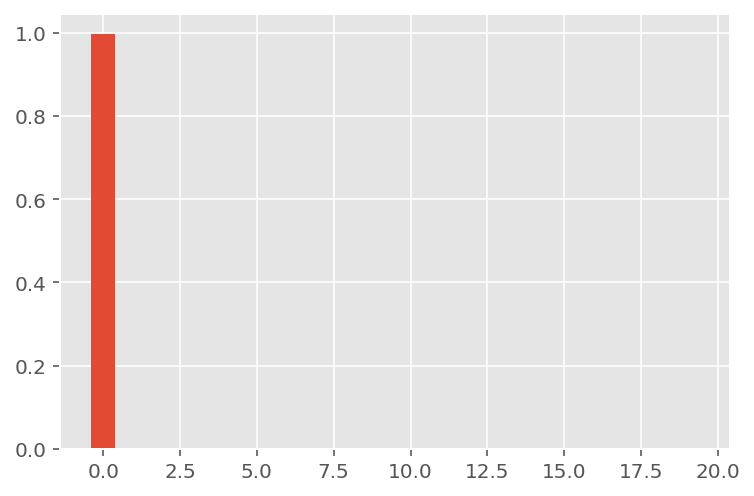

In [10]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)
plt.show()

## Factor Betas

PCA model = B * F + S

the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

Implement factor_betas to get the factor betas from the PCA model.

In [11]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    '''
    从主成分分析模型中得到因子β
    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    '''
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1

    return pd.DataFrame(data=pca.components_.T, index=factor_beta_indices, columns=factor_beta_columns)

In [12]:
    risk_model = {}
    risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))
    risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(3 [AAPL]),2.873639e-04,0.102043,0.009911,-0.045820,-0.065661,-0.033650,0.016648,-0.084471,-0.000953,-0.069254,0.051716,-0.074357,-0.055054,-0.013479,-0.000132,-0.022856,0.077592,0.069169,0.119182,0.021255
Equity(5 [ABT]),2.052810e-04,0.100315,-0.032381,-0.065505,-0.018850,0.012260,0.047939,0.049301,0.025866,0.005371,0.024841,-0.012433,0.025571,0.001265,-0.037041,-0.030797,-0.028660,0.065568,0.022662,-0.057186
Equity(7 [ACN]),2.677606e-04,0.098374,-0.033129,-0.050112,0.011237,-0.012965,0.039710,-0.047730,0.034044,-0.047377,-0.004132,-0.012721,0.026681,-0.006848,-0.010974,-0.011816,-0.049397,0.011046,0.019518,0.041820
Equity(8 [ADBE]),5.045018e-04,0.126165,0.015482,-0.095831,-0.129510,-0.038917,0.028024,-0.085054,-0.043887,-0.188744,0.151286,-0.036746,0.075619,0.006504,-0.032377,-0.012027,-0.098067,-0.072018,0.099084,-0.017560
Equity(9 [ADI]),3.343036e-05,0.121902,0.065333,-0.036916,-0.102759,-0.044690,-0.044284,-0.086334,0.020874,0.053079,-0.011658,-0.031612,-0.040476,0.052796,0.040284,0.139821,-0.000485,0.249584,0.120487,-0.107323
Equity(11 [ADP]),2.907325e-04,0.093102,-0.038332,-0.064500,0.008720,0.006694,0.044823,-0.039147,0.018074,-0.032095,-0.023001,0.016775,0.018600,0.000372,0.015446,0.028133,-0.036478,-0.001482,0.018017,0.007833
Equity(12 [ADSK]),3.690854e-04,0.150389,0.051563,-0.052597,-0.138257,-0.097958,-0.035400,-0.090208,-0.068826,-0.196666,0.096668,-0.077044,0.193795,0.066785,-0.146353,-0.079075,-0.454809,-0.007819,-0.053427,-0.248482
Equity(17 [AGN]),2.591703e-04,0.100023,-0.030515,-0.065557,-0.080150,-0.008478,0.066645,0.283545,-0.070205,0.106845,0.082031,0.038770,-0.048244,-0.040470,-0.186670,-0.184717,0.370970,-0.111746,-0.043074,-0.297635
Equity(18 [AIG]),-9.631306e-05,0.096945,-0.037272,0.014570,0.031036,0.009253,-0.060320,0.055131,0.077148,-0.030204,-0.048582,-0.002956,0.026670,-0.107958,-0.025616,-0.002141,0.019541,-0.015127,-0.040740,0.022261
Equity(25 [AMAT]),1.033962e-04,0.144791,0.087875,-0.037954,-0.147786,-0.106208,-0.041593,-0.119336,-0.036146,0.062917,-0.046663,0.000906,-0.094369,0.055463,0.040091,0.067590,-0.014825,0.350253,0.147384,-0.223985


## Factor Returns

Implement factor_returns to get the factor returns from the PCA model using the returns data.

In [13]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.
    PCA transform 将数据降维到num_factor_exposeures后的数据

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1

    return pd.DataFrame(data=pca.transform(returns), index=factor_return_indices, columns=factor_return_columns)

### View Data

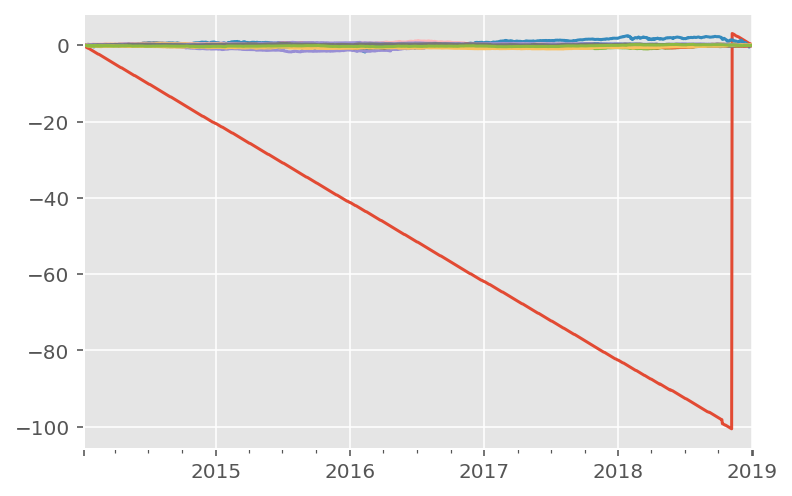

In [14]:
    risk_model['factor_returns'] = factor_returns(
        pca,
        five_year_returns,
        five_year_returns.index,
        np.arange(num_factor_exposures))
    risk_model['factor_returns'].cumsum().plot(legend=None);

## Factor Covariance Matrix

Implement factor_cov_matrix to get the factor covariance matrix.

In [15]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix
    PCA model中不同因素之间的协方差为0，即不相关
    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : DataFrame
        Factor covariance matrix
    """

    return pd.DataFrame(np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor))

### View Data

In [16]:
ann_factor = 252

risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)
risk_model['factor_cov_matrix']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2156.92044,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00000,1.903494,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00000,0.000000,0.357754,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00000,0.000000,0.000000,0.275945,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00000,0.000000,0.000000,0.000000,0.217066,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.00000,0.000000,0.000000,0.000000,0.000000,0.19796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.195793,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.166237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.155691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.130994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Idiosyncratic Variance Matrix

Implement idiosyncratic_var_matrix to get the idiosyncratic variance matrix.

In [17]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    residuals_ = returns - pd.DataFrame(np.dot(factor_returns, factor_betas.T), index=returns.index, columns=returns.columns)
    return pd.DataFrame(np.diag(residuals_.var(axis=0, ddof=1) * ann_factor),returns.columns,returns.columns)

### View Data

In [18]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

,Equity(3 [AAPL]),Equity(5 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),Equity(11 [ADP]),Equity(12 [ADSK]),Equity(17 [AGN]),Equity(18 [AIG]),Equity(25 [AMAT]),...,Equity(306 [UNH]),Equity(308 [UNP]),Equity(309 [UPS]),Equity(310 [UTX]),Equity(311 [V]),Equity(315 [VZ]),Equity(317 [WDC]),Equity(319 [WFC]),Equity(323 [WMB]),Equity(324 [WMT])
Equity(3 [AAPL]),0.032666,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(5 [ABT]),0.000000,0.01788,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(7 [ACN]),0.000000,0.00000,0.015978,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(8 [ADBE]),0.000000,0.00000,0.000000,0.022256,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(9 [ADI]),0.000000,0.00000,0.000000,0.000000,0.021092,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(11 [ADP]),0.000000,0.00000,0.000000,0.000000,0.000000,0.015791,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(12 [ADSK]),0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.02418,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(17 [AGN]),0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.023666,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(18 [AIG]),0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.018468,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Equity(25 [AMAT]),0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.025982,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


## Idiosyncratic Variance Vector

Implement idiosyncratic_var_vector to get the idiosyncratic variance Vector.

In [19]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """

    return pd.DataFrame(np.diag(idiosyncratic_var_matrix), returns.columns)

In [20]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

,0
Equity(3 [AAPL]),3.266556e-02
Equity(5 [ABT]),1.787973e-02
Equity(7 [ACN]),1.597781e-02
Equity(8 [ADBE]),2.225568e-02
Equity(9 [ADI]),2.109202e-02
Equity(11 [ADP]),1.579129e-02
Equity(12 [ADSK]),2.417996e-02
Equity(17 [AGN]),2.366619e-02
Equity(18 [AIG]),1.846777e-02
Equity(25 [AMAT]),2.598150e-02


## Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [21]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    #TODO: Implement function
    
    return np.sqrt(weights.T.dot(factor_betas.dot(factor_cov_matrix.dot(factor_betas.T)) + idiosyncratic_var_matrix).dot(weights)).iloc[0][0]


In [22]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.48963510440927516

# Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:

Momentum 1 Year Factor
Mean Reversion 5 Day Sector Neutral Factor
Mean Reversion 5 Day Sector Neutral Smoothed Factor
Overnight Sentiment Factor
Overnight Sentiment Smoothed Factor

## Momentum 1 Year Factor

Each factor will have a hypothesis that goes with it. For this factor, it is **"Higher past 12-month (252 days) returns are proportional to future return."** Using that hypothesis, we've generated this code:

我没有data.npy的数据，遂移除了根据行业groupby区分做demean的逻辑。

In [23]:
def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe)\
        .demean()\
        .rank()\
        .zscore()

## Mean Reversion 5 Day Sector Neutral Factor
Now it's time for you to implement mean_reversion_5day_sector_neutral using the hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." Use the returns data from universe, demean using the sector data to partition, rank, then converted to a zscore.

In [24]:
def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """

    # TODO: Implement function
    return momentum_1yr(window_length, universe, sector) * -1

### View Data

In [25]:
factor_start_date = universe_end_date - pd.DateOffset(years=2)
window_length = 5

pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral(window_length, universe, ""),
    'Mean_Reversion_5Day_Sector_Neutral')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral
2017-01-03 00:00:00+00:00 Equity(3 [AAPL])                            -0.779462
                          Equity(5 [ABT])                             -1.403031
                          Equity(7 [ACN])                             -1.125889
                          Equity(8 [ADBE])                             1.056604
                          Equity(17 [AGN])                            -1.714816
                          Equity(18 [AIG])                             0.571605
                          Equity(25 [AMAT])                            0.952676
                          Equity(26 [AMD])                             1.160532
                          Equity(27 [AMGN])                           -0.363749
                          Equity(29 [AMT])                            -1.091247
                          Equity(30 [AMZN])                            0.363749
                          Equity(42 [AXP])                             0.017321
                          Equity(44 [BA])                              0.190535
                          Equity(45 [BAC])                             1.229818
                          Equity(54 [BIIB])                            0.259821
                          Equity(55 [BK])                             -0.987318
                          Equity(56 [BLK])                             0.155892
                          Equity(59 [BMY])                             0.987318
                          Equity(62 [C])                               1.333746
                          Equity(66 [CAT])                             0.640891
                          Equity(68 [CBS])                             0.467677
                          Equity(71 [CELG])                            1.403031
                          Equity(74 [CHK])                             1.645531
                          Equity(82 [CMG])                             1.541602
                          Equity(87 [COF])                             1.437674
                          Equity(90 [COP])                             1.299103
                          Equity(91 [COST])                            0.086607
                          Equity(95 [CRM])                             1.091247
                          Equity(97 [CSCO])                           -0.155892
                          Equity(98 [CSX])                             1.021961
...                                                                         ...
2019-01-03 00:00:00+00:00 Equity(235 [NKE])                            0.606248
                          Equity(236 [NOC])                           -1.506960
                          Equity(239 [NSC])                            0.571605
                          Equity(243 [PCL])                            1.368389
                          Equity(244 [PEP])                            0.918033
                          Equity(245 [PFE])                           -0.225178
                          Equity(247 [PG])                             0.675534
                          Equity(254 [PM])                             1.021961
                          Equity(255 [PNC])                           -0.883390
                          Equity(257 [POM])                           -1.714816
                          Equity(274 [RTN])                           -0.606248
                          Equity(278 [SLB])                            0.502320
                          Equity(282 [SO])                             1.299103
                          Equity(283 [SPG])                            1.680173
                          Equity(286 [STZ])                            1.195175
                          Equity(291 [T])                             -1.437674
                          Equity(296 [TGT])                            0.086607
                          Equity(300 [TJX])                            0.259821
                          Equity(301 [TMO])  

## Mean Reversion 5 Day Sector Neutral Smoothed Factor

Taking the output of the previous factor, let's create a smoothed version. Implement mean_reversion_5day_sector_neutral_smoothed to generate a mean reversion 5 day sector neutral smoothed factor. Call the mean_reversion_5day_sector_neutral function to get the unsmoothed factor, then use SimpleMovingAverage function to smooth it. You'll have to apply rank and zscore again.

In [26]:
from zipline.pipeline.factors import SimpleMovingAverage

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """
    
    #TODO: Implement function
    
    return SimpleMovingAverage(inputs=[mean_reversion_5day_sector_neutral(window_length, universe, sector)],window_length=window_length).rank().zscore()

### View Data

In [27]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, ""),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral_Smoothed
2017-01-03 00:00:00+00:00 Equity(3 [AAPL])                                     -0.926092
                          Equity(5 [ABT])                                      -1.303389
                          Equity(7 [ACN])                                       0.788893
                          Equity(8 [ADBE])                                      1.234790
                          Equity(17 [AGN])                                     -1.714986
                          Equity(18 [AIG])                                      0.651695
                          Equity(25 [AMAT])                                    -0.823193
                          Equity(26 [AMD])                                     -1.234790
                          Equity(27 [AMGN])                                    -1.166190
                          Equity(29 [AMT])                                      0.240098
                          Equity(30 [AMZN])                                     0.171499
                          Equity(42 [AXP])                                      0.377297
                          Equity(44 [BA])                                       0.034300
                          Equity(45 [BAC])                                      1.097591
                          Equity(54 [BIIB])                                    -1.509188
                          Equity(55 [BK])                                      -0.994692
                          Equity(56 [BLK])                                      1.509188
                          Equity(59 [BMY])                                     -0.548795
                          Equity(62 [C])                                        0.308697
                          Equity(66 [CAT])                                      0.102899
                          Equity(68 [CBS])                                     -0.583095
                          Equity(71 [CELG])                                    -0.171499
                          Equity(74 [CHK])                                      0.480196
                          Equity(82 [CMG])                                      1.337689
                          Equity(87 [COF])                                      1.577787
                          Equity(90 [COP])                                      1.303389
                          Equity(91 [COST])                                     0.926092
                          Equity(95 [CRM])                                      0.685994
                          Equity(97 [CSCO])                                    -0.480196
                          Equity(98 [CSX])                                     -0.102899
...                                                                                  ...
2019-01-03 00:00:00+00:00 Equity(235 [NKE])                                    -0.891793
                          Equity(236 [NOC])                                     0.137199
                          Equity(239 [NSC])                                    -0.068599
                          Equity(243 [PCL])                                     0.994692
                          Equity(244 [PEP])                                     0.960392
                          Equity(245 [PFE])                                    -0.445896
                          Equity(247 [PG])                                      0.788893
                          Equity(254 [PM])                                      1.612087
                          Equity(255 [PNC])                                    -0.651695
                          Equity(257 [POM])                                     1.303389
                          Equity(274 [RTN])                                     1.166190
                          Equity(278 [SLB])                                     0.857493
                          Equity(282 [SO])                                      1.680686
                          Equity(283 [SP

## Overnight Sentiment Factor

For this factor, were using the hypothesis from the paper Overnight Returns and Firm-Specific Investor Sentiment.

通过继承Returns，对每一个交易日期的重写compute方法从而来创建自定义的factor

In [28]:
class CTO(Returns):
    inputs = [USEquityPricing.open, USEquityPricing.close]

    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        
        这里window_length取2，即取遍历的当日和前一天的数据来计算
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]


class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns

    window_length 是取多少天的数据来计算
    """
    window_safe = True

    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

In [29]:
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Overnight Sentiment Smoothed Factor

Just like the factor you implemented, we'll also smooth this factor.

In [30]:
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Combine the Factors to a single Pipeline

With all the factor implementations done, let's add them to a pipeline.

In [31]:
 # combine factors to a single pipeline
universe_end_date = pd.Timestamp('2019-01-03', tz='UTC')
factor_start_date = universe_end_date - pd.DateOffset(years=2)
universe = AverageDollarVolume(window_length=120).top(100)
sector = ""

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

Mean_Reversion_5Day_Sector_Neutral  \
2017-01-03 00:00:00+00:00 Equity(3 [AAPL])                           -0.779462   
                          Equity(5 [ABT])                            -1.403031   
                          Equity(7 [ACN])                            -1.125889   
                          Equity(8 [ADBE])                            1.056604   
                          Equity(17 [AGN])                           -1.714816   

                                            Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2017-01-03 00:00:00+00:00 Equity(3 [AAPL])                                    -0.926092   
                          Equity(5 [ABT])                                     -1.303389   
                          Equity(7 [ACN])                                      0.788893   
                          Equity(8 [ADBE])                                     1.234790   
                          Equity(17 [AGN])                                    -1.714986   

                                            Momentum_1YR  Overnight_Sentiment  \
2017-01-03 00:00:00+00:00 Equity(3 [AAPL])     -0.329106            -1.647706   
                          Equity(5 [ABT])      -1.403031             1.422764   
                          Equity(7 [ACN])       0.225178             1.434011   
                          Equity(8 [ADBE])     -0.259821            -1.355281   
                          Equity(17 [AGN])     -1.680173             1.265304   

                                            Overnight_Sentiment_Smoothed  
2017-01-03 00:00:00+00:00 Equity(3 [AAPL])                     -1.715189  
                          Equity(5 [ABT])                       1.411516  
                          Equity(7 [ACN])                      -0.624216  
                          Equity(8 [ADBE])                     -1.625212  
                          Equity(17 [AGN])                      1.422764

# Evaluate Alpha Factors
Note: We're evaluating the alpha factors using delay of 1

## Get Pricing Data

In [32]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

## Format alpha factors and pricing for Alphalens
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

函数get_clean_factor_and_forward_returns，它的描述是<b>“将
因子数据、价格数据以及行业分类按照索引对齐地格式化到一个数据表中，这个数
据表的索引是包含日期和资产的多重索引”</b>，我们理解就是获取清洗后的因子及其
未来收益（可以包含行业，也可以不包含行业），并将它们的收益对齐。

In [33]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 1.0% entries from factor data: 1.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.4% entries from factor data: 1.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


# Quantile Analysis
## Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

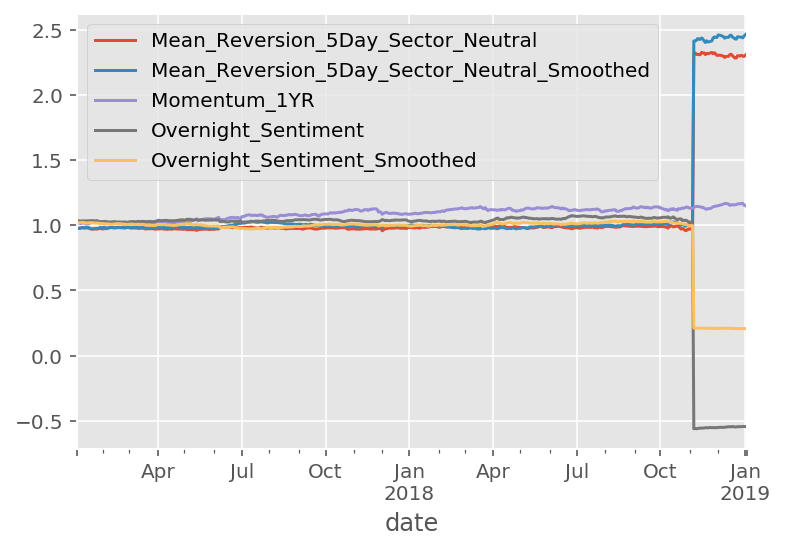

In [34]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot();

## Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

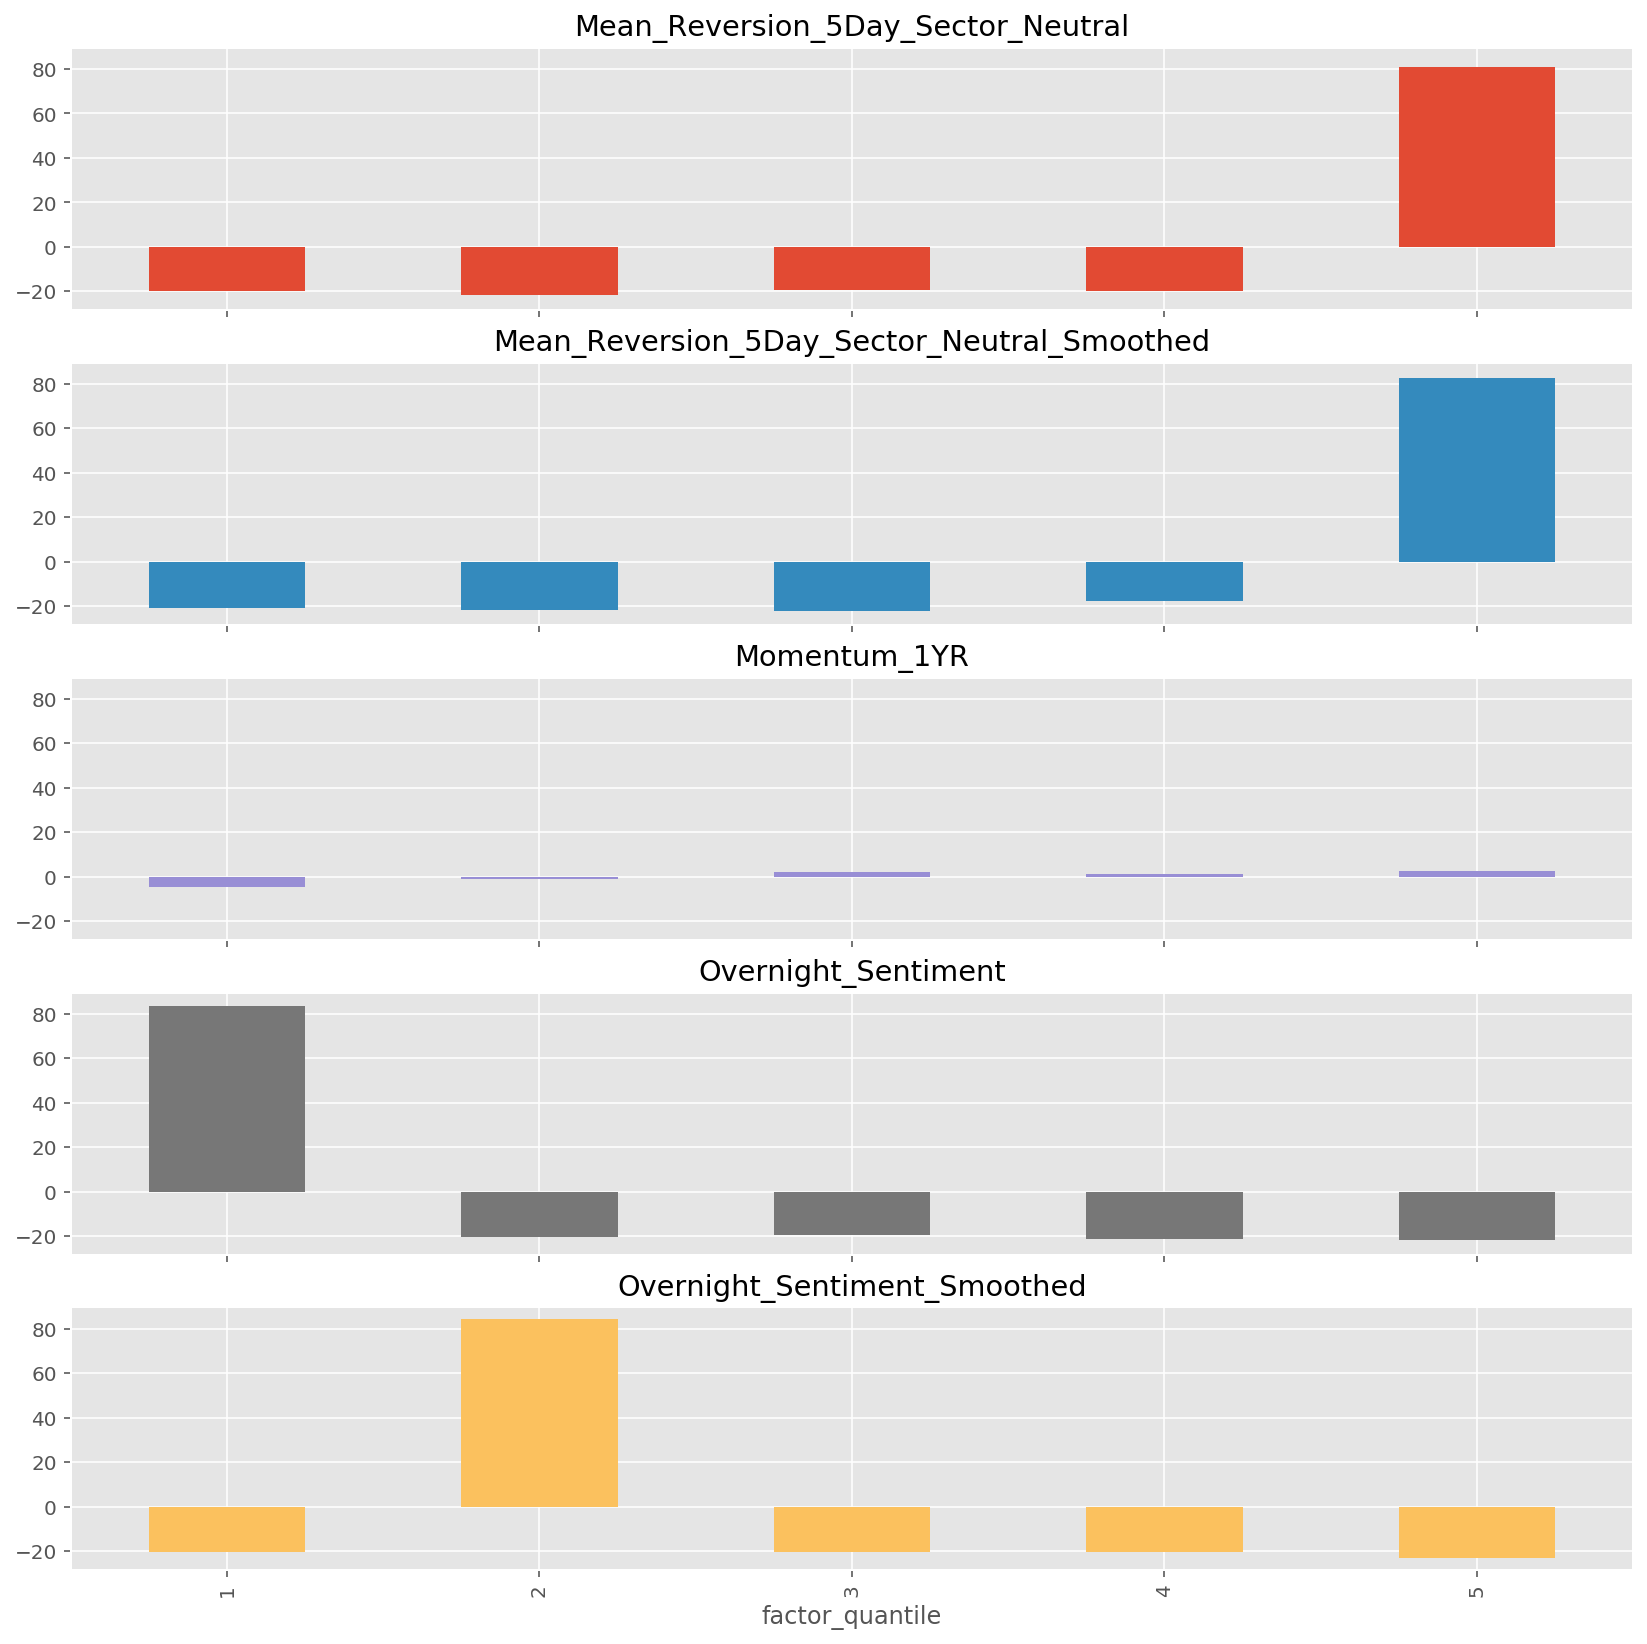

In [35]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,1),
    figsize=(14, 14),
    legend=False);

#### What do you observe?

* None of these alphas are strictly monotonic; this should lead you to question why this is? Further research and refinement of the alphas needs to be done. What is it about these alphas that leads to the highest ranking stocks in all alphas except MR 5D smoothed to not perform the best.

* The majority of the return is coming from the short side in all these alphas. The negative return in quintile 1 is very large in all alphas. This could also a cause for concern becuase when you short stocks, you need to locate the short; shorts can be expensive or not available at all.

* If you look at the magnitude of the return spread (i.e., Q1 minus Q5), we are working with daily returns in the 0.03%, i.e., 3 basis points, neighborhood before all transaction costs, shorting costs, etc.. Assuming 252 days in a year, that's 7.56% return annualized. Transaction costs may cut this in half. As such, it should be clear that these alphas can only survive in an institutional setting and that leverage will likely need to be applied in order to achieve an attractive return.

出现了基本不单调的分位情况，为什么？没有根据行业groupby?

## Turnover Analysis
Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the factor rank autocorrelation (FRA).

What's mean of <b>factor_rank_autocorrelation</b>?

Computes autocorrelation of mean factor ranks in specified time spans. We must compare period to period factor ranks rather than factor values to account for systematic shifts in the factor values of all names or names within a group. This metric is useful for measuring the turnover of a factor. If the value of a factor for each name changes randomly from period to period, we’d expect an autocorrelation of 0.

衡量一个因子的好坏还有一个指标，就是稳定性。因子的稳定性直接决定了你的调仓频率。

factor_rank_autocorrelation 越大或接近1，则证明具有较低的换手率(TurnOver);如果值较低，甚至为负，则证明有较高的换手率

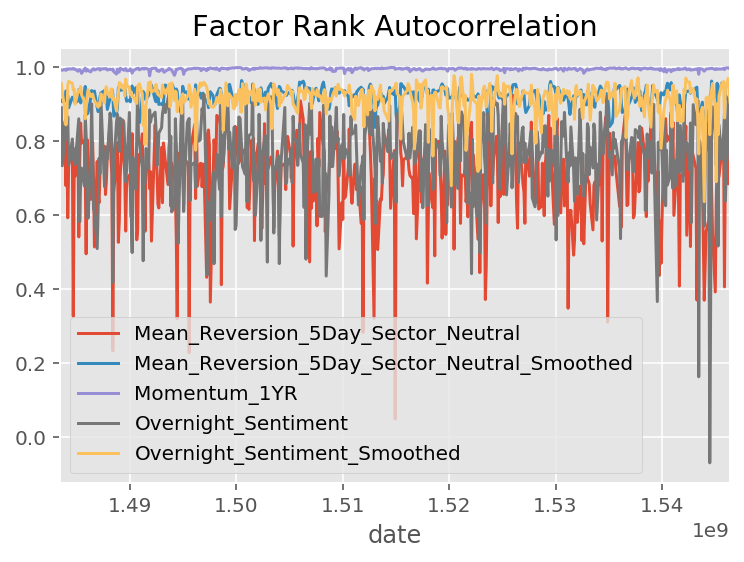

In [36]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation");

## Sharpe Ratio of the Alphas
The last analysis we'll do on the factors will be sharpe ratio. Implement sharpe_ratio to calculate the sharpe ratio of factor returns.

Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [37]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    
    #TODO: Implement function
    
    return annualization_factor*factor_returns.mean()/factor_returns.std()


In [38]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Mean_Reversion_5Day_Sector_Neutral             0.69
Mean_Reversion_5Day_Sector_Neutral_Smoothed    0.73
Momentum_1YR                                   1.14
Overnight_Sentiment                           -0.71
Overnight_Sentiment_Smoothed                  -0.72
dtype: float64

## Information Coeffiecient(IC)

在不考虑交易成本的基础下，IC系数越高，就说明未来资产收益率和alpha factor建议的保持就越一致。我们期望IC系数的均值越大越好，方差越小越好。

In [39]:
ic_factor_returns = pd.DataFrame()
for factor, factor_data in unixt_factor_data.items():
    ic_factor_returns[factor] = al.performance.mean_information_coefficient(factor_data)
    
ic_factor_returns

,Mean_Reversion_5Day_Sector_Neutral,Mean_Reversion_5Day_Sector_Neutral_Smoothed,Momentum_1YR,Overnight_Sentiment,Overnight_Sentiment_Smoothed
1D,-0.004102,0.001205,0.025866,-0.001843,-0.001024


## Question: What do you think would happen if we smooth the momentum factor? Would the performance increase, decrease, or no major change? Why?

Answer:

Based on the graph above, we can see that **the factor rank autocorrelation plot for the Momentum_1YR factor is already fairly flat, stable, and constant across time periods, hovering at a value on or just below 1.0. Smoothing the momentum factor would be taking an already very stable factor, that has very low turnover, and making it ever so slightly less volatile.**

However, it's unlikely that this slight decrease in the factor's turnover, or trading frequency, would be noticeable, since it was already very low and stable prior to smoothing. Therefore, there isn't much that smoothing can do to further lower the amount of trading costs, which means that we expect smoothing to not cause a major change in performance.

## The Combined Alpha Vector
To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [40]:
selected_factors = all_factors.columns[[1, 2, 4]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
last_date = all_factors.index.get_level_values(0)[-1]
alpha_vector = alphas.loc[last_date]

last_date
alpha_vector

Selected Factors: Mean_Reversion_5Day_Sector_Neutral_Smoothed, Momentum_1YR, Overnight_Sentiment_Smoothed


,alpha_vector
Equity(3 [AAPL]),0.124995
Equity(5 [ABT]),-0.417638
Equity(7 [ACN]),-0.080898
Equity(8 [ADBE]),-0.073178
Equity(9 [ADI]),-0.127775
Equity(11 [ADP]),0.140585
Equity(12 [ADSK]),-0.267130
Equity(17 [AGN]),-0.444190
Equity(18 [AIG]),-1.016205
Equity(25 [AMAT]),-0.962889


## Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called AbstractOptimalHoldings.

In [41]:
from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [42]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert (len(alpha_vector.columns) == 1)
        return cvx.Minimize(-alpha_vector.T.values[0]*weights)

    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert (len(factor_betas.shape) == 2)
        return [risk <= np.sqrt(self.risk_cap),
                factor_betas.T * weights <= self.weights_max,
                factor_betas.T * weights >= self.weights_min,
                sum(weights) == 0,
                sum(cvx.abs(weights)) <= 1,
                weights <= self.weights_max,
                weights >= self.weights_min]

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap = risk_cap
        self.factor_max = factor_max
        self.factor_min = factor_min
        self.weights_max = weights_max
        self.weights_min = weights_min



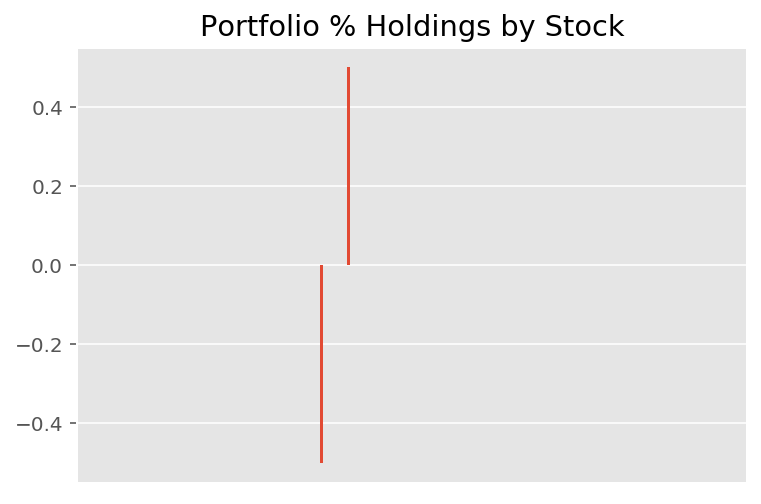

In [43]:
factor_betas = risk_model['factor_betas']
factor_cov_matrix = risk_model['factor_cov_matrix']
idiosyncratic_var_vector = risk_model['idiosyncratic_var_vector']
optimal_weights = OptimalHoldings().find(alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector)
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')

x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Yikes. It put most of the weight in a few stocks.

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

目标是最大化组合收益率和同时分散化投资，追踪指数

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

In [44]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
                
        return cvx.Minimize(-alpha_vector.T.values[0]*weights + self.lambda_reg*cvx.pnorm(weights,2))

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

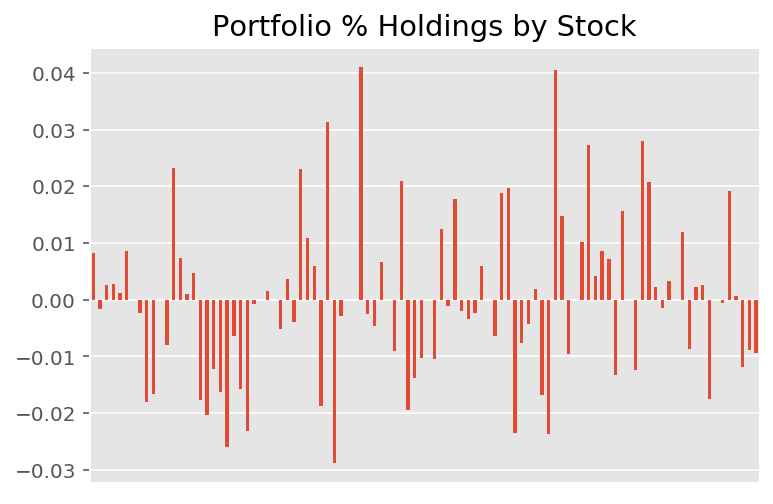

In [45]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

In [46]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        alpha_vec_vals=alpha_vector.values[:,0]
        x_star=(alpha_vec_vals-np.mean(alpha_vec_vals))/sum(abs(alpha_vec_vals))
        return cvx.Minimize(cvx.pnorm(weights-x_star,2))

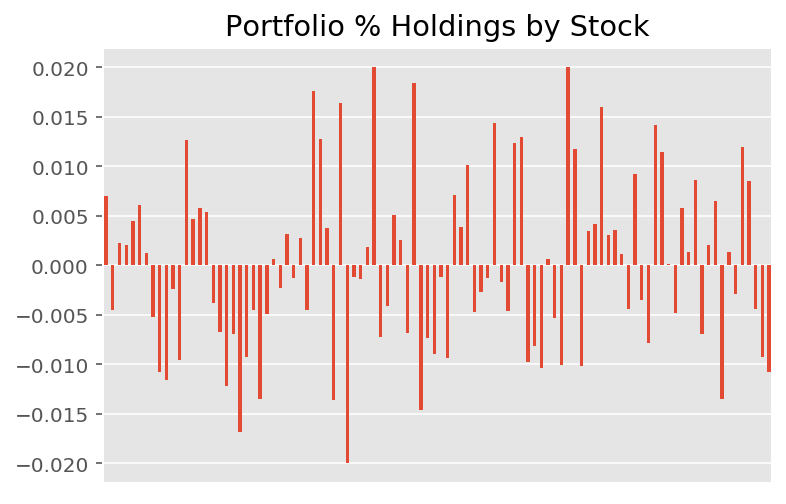

In [47]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)